# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))
        
        
def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result 

# Kaggle Code

## Load Data and Encode


In [3]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(np.float32))
    
    for column in ['height','width','length']:
        df.drop(column,1,inplace=True)
    
    ## encode numeric features
    #for column in ['pack','weight','surface_area']:
    #    encode_numeric_zscore(df,column)

    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  
extract_and_encode_features(df_train)

ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')

# Used before KFold
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)


/Users/jwalker/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [ ]:
print(df_train[0:10])

## Linear Regression (Coefficients)

Final score (RMSE): 32.62861251831055
['surface_area', 'pack', 'weight', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
item-Pencils,-40.993912,False
item-Thumbtacks,-37.697784,False
color-Red,-37.003139,False
color-Green,-24.856337,False
item-Paperweights,-24.808296,False
item-Post It Notes,-20.775148,False
item-Paperclips,-14.083073,False
size-Large,-12.790818,False
color-Blue,-10.408613,False
item-Ink Pens,-7.070616,False


Intercept: [ 23.33177185]


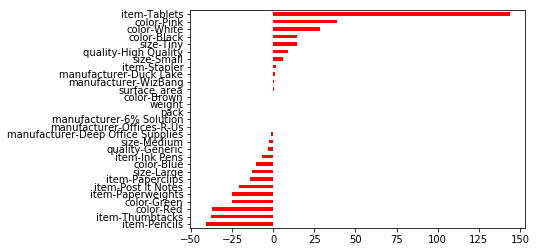

In [4]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

## L1 Regularization (Lasso)

Final score (RMSE): 32.604698181152344


,coef,positive
color-Red,-38.013115,False
item-Pencils,-26.922997,False
color-Green,-25.852888,False
item-Thumbtacks,-22.862341,False
size-Large,-12.912994,False
color-Blue,-11.693470,False
item-Paperweights,-10.087886,False
item-Post It Notes,-6.140296,False
quality-Generic,-4.635633,False
size-Medium,-2.939024,False


Intercept: [ 11.28668213]


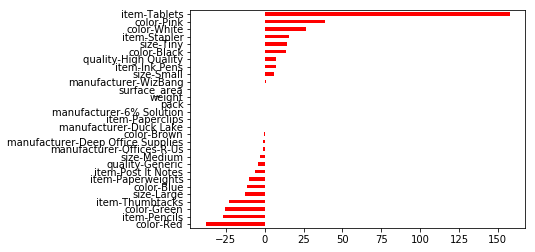

In [5]:


import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.01)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)



## L1 Regularization (Plot LassoCV)

/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

(1e-08, 100000000.0)

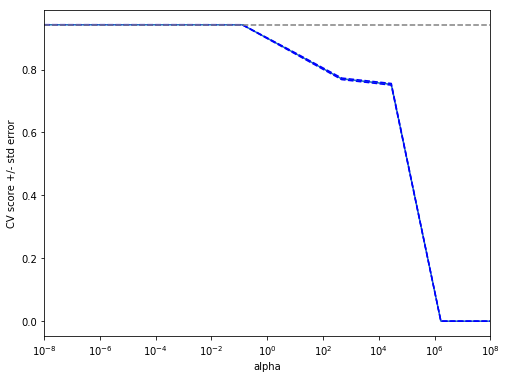

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

## L2 Regularization (Ridge)

Final score (RMSE): 32.602691650390625


/Users/jwalker/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5615852361205995e-11 / 5.960464477539063e-08
  RuntimeWarning)


,coef,positive
item-Pencils,-41.255924,False
color-Red,-38.167084,False
item-Thumbtacks,-37.115662,False
color-Green,-26.019794,False
item-Paperweights,-24.572489,False
item-Post It Notes,-20.477089,False
item-Paperclips,-14.039446,False
size-Large,-13.092483,False
color-Blue,-11.873223,False
item-Ink Pens,-7.117135,False


Intercept: [ 25.55213165]


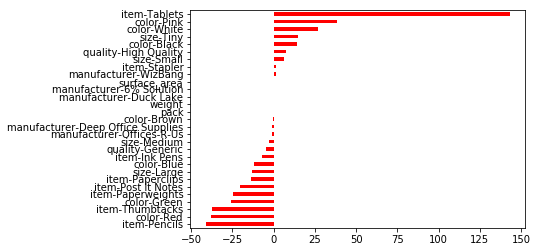

In [7]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")

report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

## ElasticNet Regularization

Final score (RMSE): 32.98986053466797


,coef,positive
item-Pencils,-37.654243,False
color-Red,-35.690369,False
item-Thumbtacks,-30.097212,False
item-Paperweights,-25.119093,False
color-Green,-24.735006,False
size-Large,-18.559225,False
item-Post It Notes,-13.660245,False
color-Blue,-11.465649,False
item-Ink Pens,-9.740009,False
item-Paperclips,-4.943350,False


Intercept: [ 20.59030914]


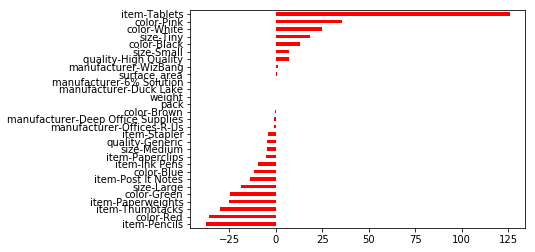

In [8]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.01, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

## Generate Training Model

In [9]:
# Cross-Validate
kf = KFold(5)

checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)

# Turn off KFold
#if (0):
oos_y = []
oos_pred = []
fold = 0
    
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dropout(0.01)) # Dropout Layer 1
    model.add(Dense(50, activation='relu')) # Hidden 2
    #model.add(Dropout(0.01)) # Dropout Layer 2
    model.add(Dense(25, 
                    kernel_regularizer=regularizers.l2(0.01), #L2 regularization
                    activity_regularizer=regularizers.l1(0.01), #L1 Lasso regularization
                    activation='relu')) # Hidden 3 
    model.add(Dense(10, activation='relu')) # Hidden 4
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=1000, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=1,epochs=10000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


Fold #1
Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 1s 126us/step - loss: 6041.9172 - val_loss: 4553.7658
Epoch 2/10000
8000/8000 [==============================] - 1s 65us/step - loss: 4890.7620 - val_loss: 4333.5768
Epoch 3/10000
8000/8000 [==============================] - 1s 69us/step - loss: 4634.6241 - val_loss: 3771.0887
Epoch 4/10000
8000/8000 [==============================] - 1s 79us/step - loss: 4442.6107 - val_loss: 3713.9194
Epoch 5/10000
8000/8000 [==============================] - 1s 69us/step - loss: 4377.7952 - val_loss: 3646.7101
Epoch 6/10000
8000/8000 [==============================] - 1s 84us/step - loss: 4368.1724 - val_loss: 3621.9104
Epoch 7/10000
8000/8000 [==============================] - 1s 79us/step - loss: 4252.0115 - val_loss: 3736.0521
Epoch 8/10000
8000/8000 [==============================] - 1s 73us/step - loss: 4187.6623 - val_loss: 3591.6761
Epoch 9/10000
8000/8000 [======================

Epoch 74/10000
8000/8000 [==============================] - 1s 67us/step - loss: 306.1088 - val_loss: 272.4220
Epoch 75/10000
8000/8000 [==============================] - 1s 66us/step - loss: 344.3191 - val_loss: 324.1982
Epoch 76/10000
8000/8000 [==============================] - 1s 65us/step - loss: 442.7260 - val_loss: 595.2649
Epoch 77/10000
8000/8000 [==============================] - 1s 70us/step - loss: 362.0991 - val_loss: 242.4523
Epoch 78/10000
8000/8000 [==============================] - 1s 66us/step - loss: 408.6907 - val_loss: 359.1419
Epoch 79/10000
8000/8000 [==============================] - 1s 67us/step - loss: 400.0809 - val_loss: 317.7552
Epoch 80/10000
8000/8000 [==============================] - 1s 69us/step - loss: 306.7548 - val_loss: 595.5576
Epoch 81/10000
8000/8000 [==============================] - 1s 69us/step - loss: 324.2731 - val_loss: 292.5844
Epoch 82/10000
8000/8000 [==============================] - 1s 69us/step - loss: 395.3265 - val_loss: 231.5367
E

8000/8000 [==============================] - 0s 61us/step - loss: 235.2635 - val_loss: 205.7141
Epoch 148/10000
8000/8000 [==============================] - 1s 87us/step - loss: 224.2041 - val_loss: 194.3339
Epoch 149/10000
8000/8000 [==============================] - 0s 57us/step - loss: 260.0902 - val_loss: 223.5703
Epoch 150/10000
8000/8000 [==============================] - 0s 57us/step - loss: 265.1966 - val_loss: 201.5501
Epoch 151/10000
8000/8000 [==============================] - 1s 67us/step - loss: 239.6523 - val_loss: 391.8299
Epoch 152/10000
8000/8000 [==============================] - 0s 53us/step - loss: 380.7469 - val_loss: 199.6278
Epoch 153/10000
8000/8000 [==============================] - 1s 71us/step - loss: 303.2612 - val_loss: 222.8623
Epoch 154/10000
8000/8000 [==============================] - 0s 59us/step - loss: 305.9623 - val_loss: 218.6218
Epoch 155/10000
8000/8000 [==============================] - 0s 59us/step - loss: 230.6914 - val_loss: 184.3119
Epoch 15

8000/8000 [==============================] - 1s 83us/step - loss: 551.4890 - val_loss: 398.7224
Epoch 221/10000
8000/8000 [==============================] - 1s 73us/step - loss: 273.3253 - val_loss: 194.7622
Epoch 222/10000
8000/8000 [==============================] - 1s 148us/step - loss: 198.9135 - val_loss: 222.4452
Epoch 223/10000
8000/8000 [==============================] - 1s 138us/step - loss: 258.5510 - val_loss: 166.8095
Epoch 224/10000
8000/8000 [==============================] - 1s 158us/step - loss: 264.5242 - val_loss: 246.8424
Epoch 225/10000
8000/8000 [==============================] - 1s 109us/step - loss: 252.9449 - val_loss: 191.6216
Epoch 226/10000
8000/8000 [==============================] - 0s 59us/step - loss: 214.6567 - val_loss: 185.4944
Epoch 227/10000
8000/8000 [==============================] - 0s 57us/step - loss: 228.2689 - val_loss: 655.6725
Epoch 228/10000
8000/8000 [==============================] - 1s 66us/step - loss: 246.9492 - val_loss: 211.3896
Epoc

8000/8000 [==============================] - 0s 62us/step - loss: 345.2738 - val_loss: 291.4638
Epoch 294/10000
8000/8000 [==============================] - 0s 60us/step - loss: 259.4477 - val_loss: 176.5078
Epoch 295/10000
8000/8000 [==============================] - 0s 60us/step - loss: 174.1367 - val_loss: 170.8535
Epoch 296/10000
8000/8000 [==============================] - 0s 59us/step - loss: 174.3519 - val_loss: 196.3092
Epoch 297/10000
8000/8000 [==============================] - 0s 58us/step - loss: 233.6596 - val_loss: 648.2276
Epoch 298/10000
8000/8000 [==============================] - 0s 55us/step - loss: 194.8185 - val_loss: 162.4419
Epoch 299/10000
8000/8000 [==============================] - 0s 53us/step - loss: 178.8550 - val_loss: 160.1965
Epoch 300/10000
8000/8000 [==============================] - 0s 57us/step - loss: 183.2055 - val_loss: 184.4607
Epoch 301/10000
8000/8000 [==============================] - 1s 65us/step - loss: 194.1926 - val_loss: 314.5765
Epoch 30

8000/8000 [==============================] - 0s 58us/step - loss: 196.7764 - val_loss: 161.1755
Epoch 367/10000
8000/8000 [==============================] - 0s 54us/step - loss: 193.1724 - val_loss: 258.2696
Epoch 368/10000
8000/8000 [==============================] - 0s 50us/step - loss: 221.6520 - val_loss: 294.0042
Epoch 369/10000
8000/8000 [==============================] - 0s 56us/step - loss: 180.5164 - val_loss: 186.1843
Epoch 370/10000
8000/8000 [==============================] - 0s 60us/step - loss: 174.2310 - val_loss: 220.6639
Epoch 371/10000
8000/8000 [==============================] - 0s 54us/step - loss: 183.5668 - val_loss: 173.8996
Epoch 372/10000
8000/8000 [==============================] - 0s 51us/step - loss: 181.8489 - val_loss: 159.8559
Epoch 373/10000
8000/8000 [==============================] - 0s 52us/step - loss: 223.1604 - val_loss: 226.2929
Epoch 374/10000
8000/8000 [==============================] - 0s 53us/step - loss: 182.6977 - val_loss: 202.8136
Epoch 37

8000/8000 [==============================] - 0s 53us/step - loss: 194.2772 - val_loss: 188.2971
Epoch 440/10000
8000/8000 [==============================] - 0s 52us/step - loss: 161.4018 - val_loss: 238.3362
Epoch 441/10000
8000/8000 [==============================] - 0s 53us/step - loss: 192.2316 - val_loss: 240.4871
Epoch 442/10000
8000/8000 [==============================] - 0s 60us/step - loss: 236.5966 - val_loss: 211.3831
Epoch 443/10000
8000/8000 [==============================] - 1s 65us/step - loss: 201.6291 - val_loss: 284.9658
Epoch 444/10000
8000/8000 [==============================] - 0s 54us/step - loss: 197.8150 - val_loss: 311.6597
Epoch 445/10000
8000/8000 [==============================] - 0s 56us/step - loss: 174.4067 - val_loss: 287.6337
Epoch 446/10000
8000/8000 [==============================] - 0s 57us/step - loss: 229.3715 - val_loss: 158.2598
Epoch 447/10000
8000/8000 [==============================] - 0s 52us/step - loss: 182.7473 - val_loss: 198.1069
Epoch 44

8000/8000 [==============================] - 0s 55us/step - loss: 201.6001 - val_loss: 158.0503
Epoch 513/10000
8000/8000 [==============================] - 0s 61us/step - loss: 180.4068 - val_loss: 155.4689
Epoch 514/10000
8000/8000 [==============================] - 0s 53us/step - loss: 193.2909 - val_loss: 159.8630
Epoch 515/10000
8000/8000 [==============================] - 0s 51us/step - loss: 214.8981 - val_loss: 384.1682
Epoch 516/10000
8000/8000 [==============================] - 0s 51us/step - loss: 202.0017 - val_loss: 507.8693
Epoch 517/10000
8000/8000 [==============================] - 0s 52us/step - loss: 185.5150 - val_loss: 166.8944
Epoch 518/10000
8000/8000 [==============================] - 0s 57us/step - loss: 210.7232 - val_loss: 153.0958
Epoch 519/10000
8000/8000 [==============================] - 1s 64us/step - loss: 265.0620 - val_loss: 267.5100
Epoch 520/10000
8000/8000 [==============================] - 0s 58us/step - loss: 238.7617 - val_loss: 172.2325
Epoch 52

8000/8000 [==============================] - 0s 54us/step - loss: 155.7178 - val_loss: 181.3738
Epoch 586/10000
8000/8000 [==============================] - 0s 54us/step - loss: 176.0513 - val_loss: 151.3008
Epoch 587/10000
8000/8000 [==============================] - 0s 59us/step - loss: 173.1184 - val_loss: 141.7180
Epoch 588/10000
8000/8000 [==============================] - 0s 54us/step - loss: 176.4079 - val_loss: 295.3463
Epoch 589/10000
8000/8000 [==============================] - 0s 55us/step - loss: 195.3453 - val_loss: 205.5686
Epoch 590/10000
8000/8000 [==============================] - ETA: 0s - loss: 159.959 - 0s 51us/step - loss: 158.3953 - val_loss: 205.5899
Epoch 591/10000
8000/8000 [==============================] - 0s 52us/step - loss: 165.7009 - val_loss: 143.7344
Epoch 592/10000
8000/8000 [==============================] - 0s 51us/step - loss: 259.9020 - val_loss: 264.0071
Epoch 593/10000
8000/8000 [==============================] - 0s 53us/step - loss: 216.6417 - v

8000/8000 [==============================] - 0s 52us/step - loss: 181.1134 - val_loss: 156.9619
Epoch 659/10000
8000/8000 [==============================] - 0s 57us/step - loss: 162.6746 - val_loss: 149.9592
Epoch 660/10000
8000/8000 [==============================] - 1s 69us/step - loss: 177.5921 - val_loss: 291.9674
Epoch 661/10000
8000/8000 [==============================] - 0s 56us/step - loss: 286.1611 - val_loss: 152.7066
Epoch 662/10000
8000/8000 [==============================] - 1s 82us/step - loss: 166.5803 - val_loss: 147.4010
Epoch 663/10000
8000/8000 [==============================] - 0s 58us/step - loss: 170.1117 - val_loss: 198.9313
Epoch 664/10000
8000/8000 [==============================] - 1s 67us/step - loss: 168.2908 - val_loss: 162.5989
Epoch 665/10000
8000/8000 [==============================] - 1s 75us/step - loss: 159.9849 - val_loss: 167.0246
Epoch 666/10000
8000/8000 [==============================] - 1s 89us/step - loss: 163.4505 - val_loss: 174.3013
Epoch 66

8000/8000 [==============================] - 1s 63us/step - loss: 205.8020 - val_loss: 164.6992
Epoch 732/10000
8000/8000 [==============================] - 1s 73us/step - loss: 190.7431 - val_loss: 156.4024
Epoch 733/10000
8000/8000 [==============================] - 1s 70us/step - loss: 153.5022 - val_loss: 163.3599
Epoch 734/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.0305 - val_loss: 174.2422
Epoch 735/10000
8000/8000 [==============================] - 0s 53us/step - loss: 205.4197 - val_loss: 166.3990
Epoch 736/10000
8000/8000 [==============================] - 0s 57us/step - loss: 243.6302 - val_loss: 156.9869
Epoch 737/10000
8000/8000 [==============================] - 0s 54us/step - loss: 223.1002 - val_loss: 214.1892
Epoch 738/10000
8000/8000 [==============================] - 0s 59us/step - loss: 285.1786 - val_loss: 170.6745
Epoch 739/10000
8000/8000 [==============================] - 0s 54us/step - loss: 187.3716 - val_loss: 180.6428
Epoch 74

8000/8000 [==============================] - 0s 57us/step - loss: 204.8345 - val_loss: 195.2139
Epoch 805/10000
8000/8000 [==============================] - 0s 52us/step - loss: 185.1204 - val_loss: 159.3513
Epoch 806/10000
8000/8000 [==============================] - 0s 51us/step - loss: 186.3132 - val_loss: 156.0781
Epoch 807/10000
8000/8000 [==============================] - 0s 50us/step - loss: 184.0899 - val_loss: 170.3404
Epoch 808/10000
8000/8000 [==============================] - 0s 52us/step - loss: 188.8499 - val_loss: 155.6924
Epoch 809/10000
8000/8000 [==============================] - 0s 51us/step - loss: 184.6319 - val_loss: 158.3262
Epoch 810/10000
8000/8000 [==============================] - 0s 51us/step - loss: 214.8304 - val_loss: 188.8670
Epoch 811/10000
8000/8000 [==============================] - 0s 51us/step - loss: 164.5714 - val_loss: 203.1760
Epoch 812/10000
8000/8000 [==============================] - 0s 51us/step - loss: 167.7494 - val_loss: 149.8084
Epoch 81

8000/8000 [==============================] - 0s 54us/step - loss: 161.5082 - val_loss: 200.8370
Epoch 878/10000
8000/8000 [==============================] - 0s 54us/step - loss: 178.1124 - val_loss: 165.0263
Epoch 879/10000
8000/8000 [==============================] - 0s 51us/step - loss: 189.0669 - val_loss: 167.0528
Epoch 880/10000
8000/8000 [==============================] - 0s 53us/step - loss: 249.0546 - val_loss: 909.7674
Epoch 881/10000
8000/8000 [==============================] - 0s 54us/step - loss: 211.1866 - val_loss: 174.1290
Epoch 882/10000
8000/8000 [==============================] - 0s 52us/step - loss: 183.7082 - val_loss: 149.0427
Epoch 883/10000
8000/8000 [==============================] - 0s 56us/step - loss: 175.2939 - val_loss: 150.7827
Epoch 884/10000
8000/8000 [==============================] - 1s 66us/step - loss: 163.2018 - val_loss: 149.3421
Epoch 885/10000
8000/8000 [==============================] - 1s 67us/step - loss: 153.6405 - val_loss: 161.4135
Epoch 88

8000/8000 [==============================] - 0s 52us/step - loss: 203.8534 - val_loss: 283.3715
Epoch 951/10000
8000/8000 [==============================] - 0s 52us/step - loss: 176.1706 - val_loss: 145.7434
Epoch 952/10000
8000/8000 [==============================] - 1s 66us/step - loss: 161.0150 - val_loss: 144.7704
Epoch 953/10000
8000/8000 [==============================] - 1s 70us/step - loss: 167.9937 - val_loss: 157.1005
Epoch 954/10000
8000/8000 [==============================] - 1s 70us/step - loss: 294.7577 - val_loss: 238.1374
Epoch 955/10000
8000/8000 [==============================] - 0s 61us/step - loss: 245.8241 - val_loss: 164.2404
Epoch 956/10000
8000/8000 [==============================] - 0s 52us/step - loss: 187.0584 - val_loss: 185.7860
Epoch 957/10000
8000/8000 [==============================] - 0s 52us/step - loss: 153.8972 - val_loss: 165.0203
Epoch 958/10000
8000/8000 [==============================] - 0s 56us/step - loss: 166.7590 - val_loss: 146.1312
Epoch 95

8000/8000 [==============================] - 0s 52us/step - loss: 177.0482 - val_loss: 158.7280
Epoch 1024/10000
8000/8000 [==============================] - 0s 52us/step - loss: 197.9555 - val_loss: 171.1811
Epoch 1025/10000
8000/8000 [==============================] - 0s 51us/step - loss: 215.3612 - val_loss: 408.7514
Epoch 1026/10000
8000/8000 [==============================] - 0s 58us/step - loss: 177.4720 - val_loss: 157.1155
Epoch 1027/10000
8000/8000 [==============================] - 0s 56us/step - loss: 186.4397 - val_loss: 158.6302
Epoch 1028/10000
8000/8000 [==============================] - 0s 57us/step - loss: 200.7690 - val_loss: 193.1669
Epoch 1029/10000
8000/8000 [==============================] - 0s 60us/step - loss: 193.7199 - val_loss: 186.7895
Epoch 1030/10000
8000/8000 [==============================] - 0s 55us/step - loss: 190.3535 - val_loss: 192.1218
Epoch 1031/10000
8000/8000 [==============================] - 0s 54us/step - loss: 164.7127 - val_loss: 260.6392


8000/8000 [==============================] - 0s 54us/step - loss: 171.1337 - val_loss: 173.7403
Epoch 1096/10000
8000/8000 [==============================] - 0s 56us/step - loss: 190.1557 - val_loss: 197.1916
Epoch 1097/10000
8000/8000 [==============================] - 0s 55us/step - loss: 186.1197 - val_loss: 200.3255
Epoch 1098/10000
8000/8000 [==============================] - 0s 56us/step - loss: 165.1539 - val_loss: 149.1180
Epoch 1099/10000
8000/8000 [==============================] - 0s 59us/step - loss: 169.9398 - val_loss: 219.5992
Epoch 1100/10000
8000/8000 [==============================] - 0s 53us/step - loss: 163.7446 - val_loss: 152.0378
Epoch 1101/10000
8000/8000 [==============================] - 0s 55us/step - loss: 172.5393 - val_loss: 175.6994
Epoch 1102/10000
8000/8000 [==============================] - 0s 53us/step - loss: 180.3812 - val_loss: 148.2599
Epoch 1103/10000
8000/8000 [==============================] - 0s 53us/step - loss: 168.0468 - val_loss: 166.9992


8000/8000 [==============================] - 0s 57us/step - loss: 249.2426 - val_loss: 179.8305
Epoch 1168/10000
8000/8000 [==============================] - 0s 52us/step - loss: 195.6693 - val_loss: 232.4981
Epoch 1169/10000
8000/8000 [==============================] - 0s 55us/step - loss: 252.9597 - val_loss: 257.4139
Epoch 1170/10000
8000/8000 [==============================] - 0s 57us/step - loss: 232.0228 - val_loss: 172.9768
Epoch 1171/10000
8000/8000 [==============================] - 0s 54us/step - loss: 209.5829 - val_loss: 171.7955
Epoch 1172/10000
8000/8000 [==============================] - 0s 52us/step - loss: 197.4363 - val_loss: 179.4115
Epoch 1173/10000
8000/8000 [==============================] - 0s 57us/step - loss: 214.7219 - val_loss: 218.2527
Epoch 1174/10000
8000/8000 [==============================] - 0s 51us/step - loss: 267.4806 - val_loss: 204.4091
Epoch 1175/10000
8000/8000 [==============================] - 0s 52us/step - loss: 205.9719 - val_loss: 176.9216


8000/8000 [==============================] - 0s 51us/step - loss: 184.4488 - val_loss: 151.4672
Epoch 1240/10000
8000/8000 [==============================] - 0s 52us/step - loss: 162.3987 - val_loss: 192.4764
Epoch 1241/10000
8000/8000 [==============================] - 0s 53us/step - loss: 185.5186 - val_loss: 163.3799
Epoch 1242/10000
8000/8000 [==============================] - 0s 52us/step - loss: 181.7888 - val_loss: 154.3622
Epoch 1243/10000
8000/8000 [==============================] - 0s 50us/step - loss: 161.5469 - val_loss: 197.8428
Epoch 1244/10000
8000/8000 [==============================] - 0s 54us/step - loss: 171.5562 - val_loss: 147.3867
Epoch 1245/10000
8000/8000 [==============================] - 1s 63us/step - loss: 153.5273 - val_loss: 159.2371
Epoch 1246/10000
8000/8000 [==============================] - 0s 59us/step - loss: 176.4540 - val_loss: 163.3524
Epoch 1247/10000
8000/8000 [==============================] - 0s 58us/step - loss: 160.3120 - val_loss: 173.0312


8000/8000 [==============================] - 1s 79us/step - loss: 180.2430 - val_loss: 154.9709
Epoch 1312/10000
8000/8000 [==============================] - 1s 75us/step - loss: 150.4468 - val_loss: 168.0759
Epoch 1313/10000
8000/8000 [==============================] - 0s 54us/step - loss: 193.0789 - val_loss: 275.1222
Epoch 1314/10000
8000/8000 [==============================] - 0s 58us/step - loss: 179.6598 - val_loss: 214.1135
Epoch 1315/10000
8000/8000 [==============================] - 1s 68us/step - loss: 168.2423 - val_loss: 151.2736
Epoch 1316/10000
8000/8000 [==============================] - 0s 57us/step - loss: 159.6997 - val_loss: 173.9817
Epoch 1317/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.2466 - val_loss: 162.0038
Epoch 1318/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.1598 - val_loss: 146.4879
Epoch 1319/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.3792 - val_loss: 148.1033


8000/8000 [==============================] - 0s 50us/step - loss: 150.1686 - val_loss: 172.8680
Epoch 1384/10000
8000/8000 [==============================] - 0s 53us/step - loss: 161.2747 - val_loss: 145.0091
Epoch 1385/10000
8000/8000 [==============================] - 0s 50us/step - loss: 156.6609 - val_loss: 162.7866
Epoch 1386/10000
8000/8000 [==============================] - 1s 69us/step - loss: 186.1350 - val_loss: 167.4843
Epoch 1387/10000
8000/8000 [==============================] - 0s 55us/step - loss: 155.2943 - val_loss: 145.4784
Epoch 1388/10000
8000/8000 [==============================] - 0s 50us/step - loss: 168.1747 - val_loss: 167.4292
Epoch 1389/10000
8000/8000 [==============================] - 0s 51us/step - loss: 159.3186 - val_loss: 169.6925
Epoch 1390/10000
8000/8000 [==============================] - 1s 71us/step - loss: 252.9572 - val_loss: 177.8217
Epoch 1391/10000
8000/8000 [==============================] - 1s 73us/step - loss: 206.4200 - val_loss: 210.3521


8000/8000 [==============================] - 0s 53us/step - loss: 159.3488 - val_loss: 157.5262
Epoch 1456/10000
8000/8000 [==============================] - 0s 52us/step - loss: 151.5965 - val_loss: 142.1093
Epoch 1457/10000
8000/8000 [==============================] - 0s 57us/step - loss: 146.9038 - val_loss: 157.6488
Epoch 1458/10000
8000/8000 [==============================] - 0s 55us/step - loss: 155.3643 - val_loss: 164.1584
Epoch 1459/10000
8000/8000 [==============================] - 0s 55us/step - loss: 143.3491 - val_loss: 142.8361
Epoch 1460/10000
8000/8000 [==============================] - 0s 56us/step - loss: 148.4138 - val_loss: 187.6749
Epoch 1461/10000
8000/8000 [==============================] - 0s 60us/step - loss: 142.6719 - val_loss: 165.5780
Epoch 1462/10000
8000/8000 [==============================] - 1s 70us/step - loss: 245.4786 - val_loss: 153.7972
Epoch 1463/10000
8000/8000 [==============================] - 1s 73us/step - loss: 143.7607 - val_loss: 162.3325


8000/8000 [==============================] - 0s 52us/step - loss: 148.3258 - val_loss: 140.1202
Epoch 1528/10000
8000/8000 [==============================] - 0s 62us/step - loss: 184.4576 - val_loss: 147.9342
Epoch 1529/10000
8000/8000 [==============================] - 1s 76us/step - loss: 146.2208 - val_loss: 138.2667
Epoch 1530/10000
8000/8000 [==============================] - 1s 70us/step - loss: 186.2025 - val_loss: 144.2654
Epoch 1531/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.9477 - val_loss: 150.0856
Epoch 1532/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.5615 - val_loss: 147.2166
Epoch 1533/10000
8000/8000 [==============================] - 0s 54us/step - loss: 143.8302 - val_loss: 149.7369
Epoch 1534/10000
8000/8000 [==============================] - 0s 54us/step - loss: 172.9563 - val_loss: 144.2452
Epoch 1535/10000
8000/8000 [==============================] - 0s 54us/step - loss: 152.9489 - val_loss: 143.5086


8000/8000 [==============================] - 1s 84us/step - loss: 155.4740 - val_loss: 146.9101
Epoch 1600/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.4291 - val_loss: 183.0324
Epoch 1601/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.6243 - val_loss: 147.2197
Epoch 1602/10000
8000/8000 [==============================] - 0s 56us/step - loss: 153.3358 - val_loss: 149.4006
Epoch 1603/10000
8000/8000 [==============================] - 0s 53us/step - loss: 164.4277 - val_loss: 148.1940
Epoch 1604/10000
8000/8000 [==============================] - 0s 57us/step - loss: 150.2539 - val_loss: 147.0955
Epoch 1605/10000
8000/8000 [==============================] - 1s 63us/step - loss: 141.3042 - val_loss: 183.8513
Epoch 1606/10000
8000/8000 [==============================] - 1s 64us/step - loss: 185.1325 - val_loss: 194.7702
Epoch 1607/10000
8000/8000 [==============================] - 0s 60us/step - loss: 164.1693 - val_loss: 146.6077


8000/8000 [==============================] - 0s 61us/step - loss: 143.6414 - val_loss: 145.7617
Epoch 1672/10000
8000/8000 [==============================] - 0s 55us/step - loss: 154.9528 - val_loss: 162.6055
Epoch 1673/10000
8000/8000 [==============================] - 0s 58us/step - loss: 156.7961 - val_loss: 148.0122
Epoch 1674/10000
8000/8000 [==============================] - 0s 56us/step - loss: 151.1967 - val_loss: 150.3104
Epoch 1675/10000
8000/8000 [==============================] - 0s 56us/step - loss: 148.5922 - val_loss: 141.8605
Epoch 1676/10000
8000/8000 [==============================] - 0s 58us/step - loss: 205.2657 - val_loss: 192.2537
Epoch 1677/10000
8000/8000 [==============================] - ETA: 0s - loss: 153.628 - 0s 57us/step - loss: 155.4736 - val_loss: 155.5087
Epoch 1678/10000
8000/8000 [==============================] - 0s 58us/step - loss: 144.5536 - val_loss: 152.3576
Epoch 1679/10000
8000/8000 [==============================] - 0s 57us/step - loss: 146.

8000/8000 [==============================] - 0s 56us/step - loss: 167.4730 - val_loss: 203.9553
Epoch 1744/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.3335 - val_loss: 150.6770
Epoch 1745/10000
8000/8000 [==============================] - 0s 55us/step - loss: 138.7502 - val_loss: 141.9206
Epoch 1746/10000
8000/8000 [==============================] - 0s 60us/step - loss: 149.9315 - val_loss: 182.6508
Epoch 1747/10000
8000/8000 [==============================] - 0s 57us/step - loss: 164.3614 - val_loss: 248.1943
Epoch 1748/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.7246 - val_loss: 172.1771
Epoch 1749/10000
8000/8000 [==============================] - 1s 63us/step - loss: 176.6861 - val_loss: 137.1747
Epoch 1750/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.2767 - val_loss: 161.1238
Epoch 1751/10000
8000/8000 [==============================] - 0s 59us/step - loss: 143.2378 - val_loss: 145.0165


8000/8000 [==============================] - 0s 57us/step - loss: 150.1058 - val_loss: 152.2027
Epoch 1816/10000
8000/8000 [==============================] - 0s 52us/step - loss: 150.5056 - val_loss: 166.1533
Epoch 1817/10000
8000/8000 [==============================] - 1s 83us/step - loss: 141.1729 - val_loss: 171.4026
Epoch 1818/10000
8000/8000 [==============================] - 0s 55us/step - loss: 146.1570 - val_loss: 141.1254
Epoch 1819/10000
8000/8000 [==============================] - 0s 58us/step - loss: 142.5172 - val_loss: 177.4827
Epoch 1820/10000
8000/8000 [==============================] - 0s 52us/step - loss: 157.8061 - val_loss: 334.5280
Epoch 1821/10000
8000/8000 [==============================] - 0s 62us/step - loss: 154.0100 - val_loss: 203.6769
Epoch 1822/10000
8000/8000 [==============================] - 0s 54us/step - loss: 158.2024 - val_loss: 146.6092
Epoch 1823/10000
8000/8000 [==============================] - 1s 67us/step - loss: 143.5209 - val_loss: 244.1769


8000/8000 [==============================] - 1s 63us/step - loss: 177.9978 - val_loss: 142.3582
Epoch 1888/10000
8000/8000 [==============================] - 0s 53us/step - loss: 148.0329 - val_loss: 138.9292
Epoch 1889/10000
8000/8000 [==============================] - 0s 53us/step - loss: 142.5305 - val_loss: 141.2545
Epoch 1890/10000
8000/8000 [==============================] - 0s 55us/step - loss: 210.0569 - val_loss: 191.4306
Epoch 1891/10000
8000/8000 [==============================] - 0s 50us/step - loss: 198.1544 - val_loss: 142.6139
Epoch 1892/10000
8000/8000 [==============================] - 0s 52us/step - loss: 147.3107 - val_loss: 146.7484
Epoch 1893/10000
8000/8000 [==============================] - 0s 53us/step - loss: 163.7410 - val_loss: 143.7472
Epoch 1894/10000
8000/8000 [==============================] - 0s 52us/step - loss: 158.5278 - val_loss: 198.2418
Epoch 1895/10000
8000/8000 [==============================] - 0s 52us/step - loss: 146.9705 - val_loss: 183.0701


8000/8000 [==============================] - 0s 52us/step - loss: 156.3637 - val_loss: 137.1913
Epoch 1960/10000
8000/8000 [==============================] - 0s 54us/step - loss: 149.7345 - val_loss: 139.7950
Epoch 1961/10000
8000/8000 [==============================] - 0s 53us/step - loss: 150.1768 - val_loss: 144.7446
Epoch 1962/10000
8000/8000 [==============================] - 0s 54us/step - loss: 146.5773 - val_loss: 167.2205
Epoch 1963/10000
8000/8000 [==============================] - 0s 52us/step - loss: 138.9216 - val_loss: 138.8490
Epoch 1964/10000
8000/8000 [==============================] - 0s 53us/step - loss: 165.1584 - val_loss: 150.2029
Epoch 1965/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.7933 - val_loss: 148.4787
Epoch 1966/10000
8000/8000 [==============================] - 0s 52us/step - loss: 144.6534 - val_loss: 140.2019
Epoch 1967/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.1535 - val_loss: 138.5044


8000/8000 [==============================] - 0s 53us/step - loss: 139.4837 - val_loss: 163.9465
Epoch 2032/10000
8000/8000 [==============================] - 0s 51us/step - loss: 167.7135 - val_loss: 147.4397
Epoch 2033/10000
8000/8000 [==============================] - 0s 53us/step - loss: 144.8135 - val_loss: 157.9009
Epoch 2034/10000
8000/8000 [==============================] - 0s 51us/step - loss: 146.4087 - val_loss: 147.7930
Epoch 2035/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.1684 - val_loss: 149.9524
Epoch 2036/10000
8000/8000 [==============================] - 0s 54us/step - loss: 144.9542 - val_loss: 147.8186
Epoch 2037/10000
8000/8000 [==============================] - 0s 55us/step - loss: 144.8922 - val_loss: 153.2363
Epoch 2038/10000
8000/8000 [==============================] - 0s 56us/step - loss: 152.6222 - val_loss: 150.1953
Epoch 2039/10000
8000/8000 [==============================] - 0s 58us/step - loss: 144.1674 - val_loss: 163.3483


8000/8000 [==============================] - 0s 56us/step - loss: 142.8122 - val_loss: 161.6891
Epoch 2104/10000
8000/8000 [==============================] - 0s 53us/step - loss: 135.2075 - val_loss: 196.5655
Epoch 2105/10000
8000/8000 [==============================] - 0s 53us/step - loss: 151.7905 - val_loss: 138.1778
Epoch 2106/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.9592 - val_loss: 150.7548
Epoch 2107/10000
8000/8000 [==============================] - 0s 52us/step - loss: 145.3205 - val_loss: 145.1370
Epoch 2108/10000
8000/8000 [==============================] - 0s 52us/step - loss: 139.4834 - val_loss: 145.2511
Epoch 2109/10000
8000/8000 [==============================] - 0s 54us/step - loss: 139.6519 - val_loss: 137.2127
Epoch 2110/10000
8000/8000 [==============================] - 0s 51us/step - loss: 147.4555 - val_loss: 157.6194
Epoch 2111/10000
8000/8000 [==============================] - 0s 51us/step - loss: 142.5985 - val_loss: 169.9379


8000/8000 [==============================] - 0s 52us/step - loss: 152.8561 - val_loss: 277.8541
Epoch 2176/10000
8000/8000 [==============================] - ETA: 0s - loss: 139.365 - 0s 51us/step - loss: 138.2862 - val_loss: 220.1842
Epoch 2177/10000
8000/8000 [==============================] - 0s 52us/step - loss: 149.1518 - val_loss: 150.5504
Epoch 2178/10000
8000/8000 [==============================] - 0s 52us/step - loss: 134.3037 - val_loss: 138.4852
Epoch 2179/10000
8000/8000 [==============================] - 0s 52us/step - loss: 175.9280 - val_loss: 156.3944
Epoch 2180/10000
8000/8000 [==============================] - 0s 52us/step - loss: 175.2446 - val_loss: 139.9039
Epoch 2181/10000
8000/8000 [==============================] - 0s 51us/step - loss: 147.3150 - val_loss: 158.7077
Epoch 2182/10000
8000/8000 [==============================] - 0s 51us/step - loss: 154.5781 - val_loss: 173.0835
Epoch 2183/10000
8000/8000 [==============================] - 0s 52us/step - loss: 145.

8000/8000 [==============================] - 0s 58us/step - loss: 176.0352 - val_loss: 144.4766
Epoch 2248/10000
8000/8000 [==============================] - 0s 56us/step - loss: 152.2261 - val_loss: 138.9196
Epoch 2249/10000
8000/8000 [==============================] - 0s 53us/step - loss: 137.1102 - val_loss: 148.9961
Epoch 2250/10000
8000/8000 [==============================] - 0s 51us/step - loss: 150.9867 - val_loss: 177.0402
Epoch 2251/10000
8000/8000 [==============================] - 0s 52us/step - loss: 141.6631 - val_loss: 140.4806
Epoch 2252/10000
8000/8000 [==============================] - 0s 52us/step - loss: 139.0659 - val_loss: 162.1022
Epoch 2253/10000
8000/8000 [==============================] - 1s 67us/step - loss: 138.0341 - val_loss: 141.0045
Epoch 2254/10000
8000/8000 [==============================] - 0s 62us/step - loss: 132.6590 - val_loss: 139.7863
Epoch 2255/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.6439 - val_loss: 249.7637


8000/8000 [==============================] - 0s 57us/step - loss: 148.5740 - val_loss: 173.8940
Epoch 2320/10000
8000/8000 [==============================] - 0s 51us/step - loss: 161.1123 - val_loss: 149.0342
Epoch 2321/10000
8000/8000 [==============================] - 0s 52us/step - loss: 151.4087 - val_loss: 147.0845
Epoch 2322/10000
8000/8000 [==============================] - 0s 55us/step - loss: 138.7088 - val_loss: 166.6071
Epoch 2323/10000
8000/8000 [==============================] - 0s 51us/step - loss: 144.6544 - val_loss: 189.0351
Epoch 2324/10000
8000/8000 [==============================] - 0s 55us/step - loss: 141.8111 - val_loss: 202.3797
Epoch 2325/10000
8000/8000 [==============================] - 0s 53us/step - loss: 144.9980 - val_loss: 149.9964
Epoch 2326/10000
8000/8000 [==============================] - 0s 53us/step - loss: 155.0782 - val_loss: 169.9508
Epoch 2327/10000
8000/8000 [==============================] - 0s 54us/step - loss: 132.2773 - val_loss: 144.6472


8000/8000 [==============================] - 0s 53us/step - loss: 219.3400 - val_loss: 158.7074
Epoch 2392/10000
8000/8000 [==============================] - 0s 54us/step - loss: 144.2130 - val_loss: 140.9948
Epoch 2393/10000
8000/8000 [==============================] - 0s 54us/step - loss: 146.2408 - val_loss: 146.4499
Epoch 2394/10000
8000/8000 [==============================] - 0s 52us/step - loss: 144.1818 - val_loss: 184.3001
Epoch 2395/10000
8000/8000 [==============================] - 0s 54us/step - loss: 141.6691 - val_loss: 175.3658
Epoch 2396/10000
8000/8000 [==============================] - 0s 56us/step - loss: 137.2810 - val_loss: 153.3818
Epoch 2397/10000
8000/8000 [==============================] - 0s 53us/step - loss: 137.0355 - val_loss: 155.2891
Epoch 2398/10000
8000/8000 [==============================] - 0s 55us/step - loss: 141.0750 - val_loss: 181.5397
Epoch 2399/10000
8000/8000 [==============================] - 0s 57us/step - loss: 145.2402 - val_loss: 170.1993


8000/8000 [==============================] - 0s 53us/step - loss: 152.1637 - val_loss: 192.5969
Epoch 2464/10000
8000/8000 [==============================] - 0s 59us/step - loss: 157.3798 - val_loss: 151.3931
Epoch 2465/10000
8000/8000 [==============================] - 0s 56us/step - loss: 142.5708 - val_loss: 154.2004
Epoch 2466/10000
8000/8000 [==============================] - 0s 53us/step - loss: 225.8688 - val_loss: 154.4323
Epoch 2467/10000
8000/8000 [==============================] - 0s 54us/step - loss: 162.1932 - val_loss: 160.5838
Epoch 2468/10000
8000/8000 [==============================] - 0s 56us/step - loss: 139.0833 - val_loss: 145.1555
Epoch 2469/10000
8000/8000 [==============================] - 0s 55us/step - loss: 144.4126 - val_loss: 148.3447
Epoch 2470/10000
8000/8000 [==============================] - 0s 54us/step - loss: 139.0837 - val_loss: 140.9970
Epoch 2471/10000
8000/8000 [==============================] - 0s 57us/step - loss: 136.0065 - val_loss: 161.5370


8000/8000 [==============================] - 0s 58us/step - loss: 134.0672 - val_loss: 139.2747
Epoch 2536/10000
8000/8000 [==============================] - 0s 55us/step - loss: 147.9663 - val_loss: 150.0680
Epoch 2537/10000
8000/8000 [==============================] - 0s 52us/step - loss: 142.1719 - val_loss: 165.9465
Epoch 2538/10000
8000/8000 [==============================] - 0s 53us/step - loss: 157.0973 - val_loss: 153.0048
Epoch 2539/10000
8000/8000 [==============================] - 0s 54us/step - loss: 129.0860 - val_loss: 235.5257
Epoch 2540/10000
8000/8000 [==============================] - 0s 54us/step - loss: 148.8887 - val_loss: 140.7747
Epoch 2541/10000
8000/8000 [==============================] - 0s 52us/step - loss: 141.1854 - val_loss: 137.6141
Epoch 2542/10000
8000/8000 [==============================] - 0s 57us/step - loss: 139.0689 - val_loss: 181.8482
Epoch 2543/10000
8000/8000 [==============================] - 1s 75us/step - loss: 139.5206 - val_loss: 137.5897


8000/8000 [==============================] - 1s 96us/step - loss: 138.9441 - val_loss: 141.4850
Epoch 2608/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.6890 - val_loss: 145.6444
Epoch 2609/10000
8000/8000 [==============================] - 0s 52us/step - loss: 140.8432 - val_loss: 146.0835
Epoch 2610/10000
8000/8000 [==============================] - 0s 52us/step - loss: 176.2056 - val_loss: 157.2765
Epoch 2611/10000
8000/8000 [==============================] - 0s 51us/step - loss: 142.6383 - val_loss: 187.9151
Epoch 2612/10000
8000/8000 [==============================] - 0s 51us/step - loss: 137.7434 - val_loss: 143.1831
Epoch 2613/10000
8000/8000 [==============================] - 0s 51us/step - loss: 134.7559 - val_loss: 145.2565
Epoch 2614/10000
8000/8000 [==============================] - 0s 50us/step - loss: 132.2431 - val_loss: 145.9346
Epoch 2615/10000
8000/8000 [==============================] - 0s 53us/step - loss: 139.7688 - val_loss: 138.1150


8000/8000 [==============================] - 1s 64us/step - loss: 136.2675 - val_loss: 151.2652
Epoch 2680/10000
8000/8000 [==============================] - 0s 58us/step - loss: 139.0120 - val_loss: 143.1659
Epoch 2681/10000
8000/8000 [==============================] - 0s 56us/step - loss: 160.3368 - val_loss: 146.1586
Epoch 2682/10000
8000/8000 [==============================] - 0s 54us/step - loss: 137.0400 - val_loss: 159.6326
Epoch 2683/10000
8000/8000 [==============================] - 0s 55us/step - loss: 152.4212 - val_loss: 146.1582
Epoch 2684/10000
8000/8000 [==============================] - 0s 56us/step - loss: 134.0132 - val_loss: 140.2689
Epoch 2685/10000
8000/8000 [==============================] - 0s 57us/step - loss: 135.6033 - val_loss: 145.8522
Epoch 2686/10000
8000/8000 [==============================] - 0s 55us/step - loss: 152.9559 - val_loss: 147.4052
Epoch 2687/10000
8000/8000 [==============================] - 0s 55us/step - loss: 140.3769 - val_loss: 150.5936


8000/8000 [==============================] - 0s 52us/step - loss: 132.5915 - val_loss: 154.1966
Epoch 2752/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.4687 - val_loss: 152.4059
Epoch 2753/10000
8000/8000 [==============================] - 1s 75us/step - loss: 179.1336 - val_loss: 153.6754
Epoch 2754/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.5029 - val_loss: 182.7395
Epoch 2755/10000
8000/8000 [==============================] - 1s 68us/step - loss: 130.1942 - val_loss: 142.6991
Epoch 2756/10000
8000/8000 [==============================] - 1s 128us/step - loss: 137.3755 - val_loss: 147.1253
Epoch 2757/10000
8000/8000 [==============================] - 1s 130us/step - loss: 152.2403 - val_loss: 145.2696
Epoch 2758/10000
8000/8000 [==============================] - 1s 91us/step - loss: 128.9385 - val_loss: 141.0408
Epoch 2759/10000
8000/8000 [==============================] - 1s 110us/step - loss: 139.1385 - val_loss: 154.34

8000/8000 [==============================] - 0s 55us/step - loss: 133.4677 - val_loss: 146.7769
Epoch 2824/10000
8000/8000 [==============================] - 0s 54us/step - loss: 138.3589 - val_loss: 144.3515
Epoch 2825/10000
8000/8000 [==============================] - 0s 55us/step - loss: 181.6705 - val_loss: 145.0335
Epoch 2826/10000
8000/8000 [==============================] - 0s 52us/step - loss: 159.0520 - val_loss: 152.9389
Epoch 2827/10000
8000/8000 [==============================] - 0s 55us/step - loss: 135.0020 - val_loss: 133.4857
Epoch 2828/10000
8000/8000 [==============================] - 0s 53us/step - loss: 138.2140 - val_loss: 140.5522
Epoch 2829/10000
8000/8000 [==============================] - 0s 51us/step - loss: 131.9982 - val_loss: 168.4529
Epoch 2830/10000
8000/8000 [==============================] - 0s 62us/step - loss: 137.4278 - val_loss: 233.1808
Epoch 2831/10000
8000/8000 [==============================] - 1s 69us/step - loss: 157.3028 - val_loss: 143.0341


8000/8000 [==============================] - 1s 79us/step - loss: 150.9311 - val_loss: 168.2037
Epoch 2896/10000
8000/8000 [==============================] - 1s 75us/step - loss: 228.0872 - val_loss: 167.3604
Epoch 2897/10000
8000/8000 [==============================] - 1s 70us/step - loss: 169.4597 - val_loss: 358.9881
Epoch 2898/10000
8000/8000 [==============================] - 0s 57us/step - loss: 154.8628 - val_loss: 144.8333
Epoch 2899/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.2710 - val_loss: 142.8907
Epoch 2900/10000
8000/8000 [==============================] - 1s 74us/step - loss: 132.5549 - val_loss: 152.7191
Epoch 2901/10000
8000/8000 [==============================] - 0s 56us/step - loss: 134.7853 - val_loss: 143.5102
Epoch 2902/10000
8000/8000 [==============================] - 1s 69us/step - loss: 134.1164 - val_loss: 164.1459
Epoch 2903/10000
8000/8000 [==============================] - 0s 55us/step - loss: 128.4365 - val_loss: 156.7618


8000/8000 [==============================] - 0s 56us/step - loss: 128.0273 - val_loss: 181.0760
Epoch 2968/10000
8000/8000 [==============================] - 0s 58us/step - loss: 151.4811 - val_loss: 153.6018
Epoch 2969/10000
8000/8000 [==============================] - 0s 59us/step - loss: 143.3931 - val_loss: 186.1659
Epoch 2970/10000
8000/8000 [==============================] - 0s 58us/step - loss: 135.4437 - val_loss: 148.0382
Epoch 2971/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.7846 - val_loss: 219.5365
Epoch 2972/10000
8000/8000 [==============================] - 0s 55us/step - loss: 141.8844 - val_loss: 139.5096
Epoch 2973/10000
8000/8000 [==============================] - 0s 57us/step - loss: 130.5485 - val_loss: 137.4495
Epoch 2974/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.4966 - val_loss: 137.8204
Epoch 2975/10000
8000/8000 [==============================] - 0s 57us/step - loss: 147.7009 - val_loss: 156.7617


8000/8000 [==============================] - 0s 52us/step - loss: 143.3265 - val_loss: 137.7912
Epoch 3040/10000
8000/8000 [==============================] - 0s 52us/step - loss: 140.5515 - val_loss: 146.5756
Epoch 3041/10000
8000/8000 [==============================] - 0s 51us/step - loss: 153.4687 - val_loss: 150.1427
Epoch 3042/10000
8000/8000 [==============================] - 0s 58us/step - loss: 132.1452 - val_loss: 177.3909
Epoch 3043/10000
8000/8000 [==============================] - 1s 74us/step - loss: 139.0472 - val_loss: 145.5696
Epoch 3044/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.3555 - val_loss: 147.6053
Epoch 3045/10000
8000/8000 [==============================] - 1s 72us/step - loss: 143.7761 - val_loss: 137.1862
Epoch 3046/10000
8000/8000 [==============================] - 1s 65us/step - loss: 140.1120 - val_loss: 147.9881
Epoch 3047/10000
8000/8000 [==============================] - 0s 62us/step - loss: 132.0853 - val_loss: 140.0511


8000/8000 [==============================] - 0s 58us/step - loss: 131.0220 - val_loss: 168.6682
Epoch 3112/10000
8000/8000 [==============================] - 0s 62us/step - loss: 146.7826 - val_loss: 142.5524
Epoch 3113/10000
8000/8000 [==============================] - 0s 54us/step - loss: 133.6426 - val_loss: 147.2781
Epoch 3114/10000
8000/8000 [==============================] - 0s 55us/step - loss: 195.9504 - val_loss: 442.8878
Epoch 3115/10000
8000/8000 [==============================] - 0s 54us/step - loss: 156.5698 - val_loss: 143.7481
Epoch 3116/10000
8000/8000 [==============================] - 0s 53us/step - loss: 139.4841 - val_loss: 193.6201
Epoch 3117/10000
8000/8000 [==============================] - 0s 53us/step - loss: 135.8382 - val_loss: 144.0964
Epoch 3118/10000
8000/8000 [==============================] - 0s 50us/step - loss: 141.0961 - val_loss: 142.7054
Epoch 3119/10000
8000/8000 [==============================] - 0s 55us/step - loss: 173.5522 - val_loss: 239.4024


8000/8000 [==============================] - 0s 57us/step - loss: 133.4107 - val_loss: 152.4952
Epoch 3184/10000
8000/8000 [==============================] - 0s 56us/step - loss: 139.8939 - val_loss: 137.6175
Epoch 3185/10000
8000/8000 [==============================] - ETA: 0s - loss: 131.726 - 0s 57us/step - loss: 132.8457 - val_loss: 143.8374
Epoch 3186/10000
8000/8000 [==============================] - 0s 58us/step - loss: 130.8311 - val_loss: 168.9177
Epoch 3187/10000
8000/8000 [==============================] - 0s 56us/step - loss: 149.2704 - val_loss: 153.1593
Epoch 3188/10000
8000/8000 [==============================] - 0s 56us/step - loss: 126.7561 - val_loss: 147.9592
Epoch 3189/10000
8000/8000 [==============================] - 0s 57us/step - loss: 160.6911 - val_loss: 176.8665
Epoch 3190/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.8819 - val_loss: 139.9884
Epoch 3191/10000
8000/8000 [==============================] - 0s 61us/step - loss: 128.

8000/8000 [==============================] - 0s 52us/step - loss: 129.2131 - val_loss: 171.4620
Epoch 3256/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.6665 - val_loss: 157.5325
Epoch 3257/10000
8000/8000 [==============================] - 0s 52us/step - loss: 133.8161 - val_loss: 138.0098
Epoch 3258/10000
8000/8000 [==============================] - 0s 52us/step - loss: 132.8543 - val_loss: 161.4425
Epoch 3259/10000
8000/8000 [==============================] - 0s 50us/step - loss: 135.9083 - val_loss: 137.0573
Epoch 3260/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.5490 - val_loss: 139.4693
Epoch 3261/10000
8000/8000 [==============================] - 0s 52us/step - loss: 132.4261 - val_loss: 152.5877
Epoch 3262/10000
8000/8000 [==============================] - 0s 56us/step - loss: 125.9946 - val_loss: 152.4211
Epoch 3263/10000
8000/8000 [==============================] - 0s 58us/step - loss: 146.1257 - val_loss: 143.2040


8000/8000 [==============================] - 0s 52us/step - loss: 135.9798 - val_loss: 137.5729
Epoch 3328/10000
8000/8000 [==============================] - 0s 52us/step - loss: 149.4740 - val_loss: 167.6066
Epoch 3329/10000
8000/8000 [==============================] - 0s 52us/step - loss: 136.1431 - val_loss: 138.3671
Epoch 3330/10000
8000/8000 [==============================] - 0s 55us/step - loss: 127.2340 - val_loss: 185.0135
Epoch 3331/10000
8000/8000 [==============================] - 0s 52us/step - loss: 133.3074 - val_loss: 135.1601
Epoch 3332/10000
8000/8000 [==============================] - 0s 52us/step - loss: 131.3981 - val_loss: 205.4171
Epoch 3333/10000
8000/8000 [==============================] - 0s 53us/step - loss: 132.1201 - val_loss: 162.5714
Epoch 3334/10000
8000/8000 [==============================] - 0s 52us/step - loss: 135.7486 - val_loss: 232.2636
Epoch 3335/10000
8000/8000 [==============================] - 0s 55us/step - loss: 126.5100 - val_loss: 139.9641


8000/8000 [==============================] - 0s 54us/step - loss: 127.9517 - val_loss: 156.3970
Epoch 3400/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.7638 - val_loss: 144.2314
Epoch 3401/10000
8000/8000 [==============================] - 0s 50us/step - loss: 134.8288 - val_loss: 141.5799
Epoch 3402/10000
8000/8000 [==============================] - 0s 53us/step - loss: 145.0553 - val_loss: 153.9099
Epoch 3403/10000
8000/8000 [==============================] - 0s 53us/step - loss: 148.0690 - val_loss: 154.5623
Epoch 3404/10000
8000/8000 [==============================] - 0s 53us/step - loss: 132.0794 - val_loss: 141.0218
Epoch 3405/10000
8000/8000 [==============================] - 0s 53us/step - loss: 124.2792 - val_loss: 144.3862
Epoch 3406/10000
8000/8000 [==============================] - 0s 52us/step - loss: 133.3871 - val_loss: 176.0150
Epoch 3407/10000
8000/8000 [==============================] - 0s 53us/step - loss: 137.2675 - val_loss: 153.7656


8000/8000 [==============================] - 0s 54us/step - loss: 140.4327 - val_loss: 248.9497
Epoch 3472/10000
8000/8000 [==============================] - 0s 52us/step - loss: 128.2510 - val_loss: 141.6234
Epoch 3473/10000
8000/8000 [==============================] - 0s 52us/step - loss: 135.3792 - val_loss: 143.0283
Epoch 3474/10000
8000/8000 [==============================] - 0s 52us/step - loss: 152.7354 - val_loss: 146.8083
Epoch 3475/10000
8000/8000 [==============================] - 0s 53us/step - loss: 128.0344 - val_loss: 143.2132
Epoch 3476/10000
8000/8000 [==============================] - 0s 58us/step - loss: 147.3197 - val_loss: 141.3627
Epoch 3477/10000
8000/8000 [==============================] - 0s 52us/step - loss: 143.9558 - val_loss: 182.7015
Epoch 3478/10000
8000/8000 [==============================] - 0s 53us/step - loss: 129.7929 - val_loss: 144.2878
Epoch 3479/10000
8000/8000 [==============================] - 0s 53us/step - loss: 130.4433 - val_loss: 144.8544


8000/8000 [==============================] - 0s 52us/step - loss: 129.9409 - val_loss: 185.1410
Epoch 3544/10000
8000/8000 [==============================] - 0s 52us/step - loss: 129.0297 - val_loss: 140.8377
Epoch 3545/10000
8000/8000 [==============================] - 0s 51us/step - loss: 154.3407 - val_loss: 141.2304
Epoch 3546/10000
8000/8000 [==============================] - 0s 52us/step - loss: 144.2426 - val_loss: 140.3804
Epoch 3547/10000
8000/8000 [==============================] - 0s 52us/step - loss: 125.3405 - val_loss: 142.4582
Epoch 3548/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.7288 - val_loss: 186.3173
Epoch 3549/10000
8000/8000 [==============================] - 0s 52us/step - loss: 135.6323 - val_loss: 140.1197
Epoch 3550/10000
8000/8000 [==============================] - 0s 54us/step - loss: 132.2733 - val_loss: 183.8694
Epoch 3551/10000
8000/8000 [==============================] - 0s 53us/step - loss: 128.6196 - val_loss: 140.8705


8000/8000 [==============================] - 0s 53us/step - loss: 128.8924 - val_loss: 177.7030
Epoch 3616/10000
8000/8000 [==============================] - 0s 55us/step - loss: 153.0074 - val_loss: 155.2717
Epoch 3617/10000
8000/8000 [==============================] - 0s 54us/step - loss: 134.8228 - val_loss: 135.7978
Epoch 3618/10000
8000/8000 [==============================] - 0s 52us/step - loss: 128.5115 - val_loss: 137.1697
Epoch 3619/10000
8000/8000 [==============================] - 0s 52us/step - loss: 133.2426 - val_loss: 149.5941
Epoch 3620/10000
8000/8000 [==============================] - 0s 52us/step - loss: 131.6634 - val_loss: 178.3954
Epoch 3621/10000
8000/8000 [==============================] - 0s 52us/step - loss: 134.1495 - val_loss: 145.1725
Epoch 3622/10000
8000/8000 [==============================] - 0s 55us/step - loss: 134.3391 - val_loss: 134.8795
Epoch 3623/10000
8000/8000 [==============================] - 0s 54us/step - loss: 130.1752 - val_loss: 144.2004


8000/8000 [==============================] - 0s 55us/step - loss: 132.1436 - val_loss: 161.7373
Epoch 3688/10000
8000/8000 [==============================] - 0s 55us/step - loss: 126.1961 - val_loss: 170.3240
Epoch 3689/10000
8000/8000 [==============================] - 0s 50us/step - loss: 132.1122 - val_loss: 196.1625
Epoch 3690/10000
8000/8000 [==============================] - 0s 51us/step - loss: 134.5775 - val_loss: 156.3972
Epoch 3691/10000
8000/8000 [==============================] - 0s 51us/step - loss: 150.9985 - val_loss: 138.9874
Epoch 3692/10000
8000/8000 [==============================] - 0s 50us/step - loss: 130.1622 - val_loss: 135.1353
Epoch 3693/10000
8000/8000 [==============================] - 0s 53us/step - loss: 135.3442 - val_loss: 144.3081
Epoch 3694/10000
8000/8000 [==============================] - 0s 53us/step - loss: 129.4902 - val_loss: 167.1142
Epoch 3695/10000
8000/8000 [==============================] - 1s 69us/step - loss: 133.8113 - val_loss: 149.1672


8000/8000 [==============================] - 0s 53us/step - loss: 182.1263 - val_loss: 173.2894
Epoch 3760/10000
8000/8000 [==============================] - 0s 54us/step - loss: 143.5143 - val_loss: 142.4960
Epoch 3761/10000
8000/8000 [==============================] - 0s 52us/step - loss: 133.9537 - val_loss: 137.8663
Epoch 3762/10000
8000/8000 [==============================] - 0s 52us/step - loss: 138.4615 - val_loss: 148.2624
Epoch 3763/10000
8000/8000 [==============================] - 0s 53us/step - loss: 140.3568 - val_loss: 143.0458
Epoch 3764/10000
8000/8000 [==============================] - 0s 62us/step - loss: 140.2029 - val_loss: 139.3141
Epoch 3765/10000
8000/8000 [==============================] - 1s 67us/step - loss: 136.1086 - val_loss: 150.7089
Epoch 3766/10000
8000/8000 [==============================] - 1s 80us/step - loss: 163.9457 - val_loss: 209.6688
Epoch 3767/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.0849 - val_loss: 144.2464


8000/8000 [==============================] - 0s 52us/step - loss: 4568.6206 - val_loss: 4809.2409
Epoch 4/10000
8000/8000 [==============================] - 0s 54us/step - loss: 4321.9971 - val_loss: 4594.1867
Epoch 5/10000
8000/8000 [==============================] - 0s 54us/step - loss: 4184.0522 - val_loss: 4601.6693
Epoch 6/10000
8000/8000 [==============================] - 0s 50us/step - loss: 4109.7419 - val_loss: 4438.4839
Epoch 7/10000
8000/8000 [==============================] - 0s 52us/step - loss: 4006.9898 - val_loss: 4221.3467
Epoch 8/10000
8000/8000 [==============================] - 0s 53us/step - loss: 3944.2935 - val_loss: 4255.9494
Epoch 9/10000
8000/8000 [==============================] - 0s 50us/step - loss: 3844.0652 - val_loss: 4159.2088
Epoch 10/10000
8000/8000 [==============================] - 0s 52us/step - loss: 3785.3024 - val_loss: 4106.5037
Epoch 11/10000
8000/8000 [==============================] - 0s 51us/step - loss: 3816.2628 - val_loss: 3922.7523
Epoc

8000/8000 [==============================] - 0s 52us/step - loss: 332.1233 - val_loss: 311.7369
Epoch 77/10000
8000/8000 [==============================] - 0s 52us/step - loss: 319.5656 - val_loss: 315.2072
Epoch 78/10000
8000/8000 [==============================] - 0s 52us/step - loss: 362.2752 - val_loss: 604.8705
Epoch 79/10000
8000/8000 [==============================] - 0s 51us/step - loss: 377.6541 - val_loss: 353.4505
Epoch 80/10000
8000/8000 [==============================] - 0s 51us/step - loss: 322.2804 - val_loss: 314.8541
Epoch 81/10000
8000/8000 [==============================] - 0s 51us/step - loss: 366.5429 - val_loss: 245.6032
Epoch 82/10000
8000/8000 [==============================] - 0s 53us/step - loss: 302.8778 - val_loss: 353.1274
Epoch 83/10000
8000/8000 [==============================] - 0s 52us/step - loss: 347.3738 - val_loss: 718.4597
Epoch 84/10000
8000/8000 [==============================] - 0s 51us/step - loss: 419.4839 - val_loss: 281.6792
Epoch 85/10000
8

8000/8000 [==============================] - 0s 51us/step - loss: 256.7978 - val_loss: 244.9328
Epoch 150/10000
8000/8000 [==============================] - 0s 53us/step - loss: 318.3164 - val_loss: 402.4203
Epoch 151/10000
8000/8000 [==============================] - 0s 58us/step - loss: 228.8346 - val_loss: 190.9039
Epoch 152/10000
8000/8000 [==============================] - 0s 55us/step - loss: 261.4820 - val_loss: 458.6930
Epoch 153/10000
8000/8000 [==============================] - 0s 52us/step - loss: 237.9180 - val_loss: 342.5496
Epoch 154/10000
8000/8000 [==============================] - 0s 52us/step - loss: 249.9675 - val_loss: 196.5960
Epoch 155/10000
8000/8000 [==============================] - 0s 51us/step - loss: 220.5055 - val_loss: 201.1351
Epoch 156/10000
8000/8000 [==============================] - 0s 52us/step - loss: 262.7870 - val_loss: 200.9126
Epoch 157/10000
8000/8000 [==============================] - 0s 50us/step - loss: 374.6074 - val_loss: 252.8041
Epoch 15

8000/8000 [==============================] - 0s 56us/step - loss: 251.9263 - val_loss: 219.5512
Epoch 223/10000
8000/8000 [==============================] - 0s 50us/step - loss: 226.7454 - val_loss: 236.2588
Epoch 224/10000
8000/8000 [==============================] - 0s 51us/step - loss: 279.0620 - val_loss: 230.1978
Epoch 225/10000
8000/8000 [==============================] - 0s 53us/step - loss: 222.9250 - val_loss: 226.3886
Epoch 226/10000
8000/8000 [==============================] - 0s 53us/step - loss: 219.5370 - val_loss: 258.4969
Epoch 227/10000
8000/8000 [==============================] - 0s 53us/step - loss: 189.2258 - val_loss: 326.9544
Epoch 228/10000
8000/8000 [==============================] - 0s 53us/step - loss: 207.9598 - val_loss: 174.4390
Epoch 229/10000
8000/8000 [==============================] - 0s 56us/step - loss: 219.2408 - val_loss: 222.9658
Epoch 230/10000
8000/8000 [==============================] - 1s 64us/step - loss: 265.5096 - val_loss: 209.5323
Epoch 23

Epoch 295/10000
8000/8000 [==============================] - 0s 52us/step - loss: 215.9611 - val_loss: 176.1446
Epoch 296/10000
8000/8000 [==============================] - 0s 53us/step - loss: 176.4300 - val_loss: 175.0679
Epoch 297/10000
8000/8000 [==============================] - 0s 51us/step - loss: 237.7524 - val_loss: 173.6762
Epoch 298/10000
8000/8000 [==============================] - 0s 54us/step - loss: 190.0028 - val_loss: 191.9383
Epoch 299/10000
8000/8000 [==============================] - 0s 53us/step - loss: 175.2026 - val_loss: 155.6360
Epoch 300/10000
8000/8000 [==============================] - 0s 59us/step - loss: 175.6445 - val_loss: 165.4456
Epoch 301/10000
8000/8000 [==============================] - 0s 52us/step - loss: 187.7124 - val_loss: 182.8705
Epoch 302/10000
8000/8000 [==============================] - 0s 51us/step - loss: 169.0405 - val_loss: 180.5604
Epoch 303/10000
8000/8000 [==============================] - 0s 56us/step - loss: 247.1466 - val_loss: 2

8000/8000 [==============================] - 0s 50us/step - loss: 250.6428 - val_loss: 592.7802
Epoch 369/10000
8000/8000 [==============================] - 0s 52us/step - loss: 222.1208 - val_loss: 170.6985
Epoch 370/10000
8000/8000 [==============================] - 0s 50us/step - loss: 192.1041 - val_loss: 182.4842
Epoch 371/10000
8000/8000 [==============================] - 0s 50us/step - loss: 195.1771 - val_loss: 211.9267
Epoch 372/10000
8000/8000 [==============================] - 1s 63us/step - loss: 233.3195 - val_loss: 179.6825
Epoch 373/10000
8000/8000 [==============================] - 0s 54us/step - loss: 194.7611 - val_loss: 229.2948
Epoch 374/10000
8000/8000 [==============================] - 0s 52us/step - loss: 206.0321 - val_loss: 171.2146
Epoch 375/10000
8000/8000 [==============================] - 0s 51us/step - loss: 195.3071 - val_loss: 207.8681
Epoch 376/10000
8000/8000 [==============================] - 0s 51us/step - loss: 205.0159 - val_loss: 197.4389
Epoch 37

8000/8000 [==============================] - 0s 51us/step - loss: 206.0868 - val_loss: 184.2678
Epoch 442/10000
8000/8000 [==============================] - 0s 54us/step - loss: 203.5225 - val_loss: 206.7519
Epoch 443/10000
8000/8000 [==============================] - 0s 50us/step - loss: 159.8472 - val_loss: 244.8097
Epoch 444/10000
8000/8000 [==============================] - 0s 54us/step - loss: 192.7864 - val_loss: 176.7647
Epoch 445/10000
8000/8000 [==============================] - 0s 53us/step - loss: 174.4301 - val_loss: 166.9456
Epoch 446/10000
8000/8000 [==============================] - 0s 55us/step - loss: 189.0952 - val_loss: 190.4824
Epoch 447/10000
8000/8000 [==============================] - 0s 54us/step - loss: 158.0481 - val_loss: 167.3145
Epoch 448/10000
8000/8000 [==============================] - 0s 51us/step - loss: 212.9689 - val_loss: 222.2538
Epoch 449/10000
8000/8000 [==============================] - 0s 54us/step - loss: 166.4907 - val_loss: 177.7157
Epoch 45

8000/8000 [==============================] - 0s 57us/step - loss: 155.9700 - val_loss: 168.1864
Epoch 515/10000
8000/8000 [==============================] - 0s 59us/step - loss: 409.2029 - val_loss: 605.9484
Epoch 516/10000
8000/8000 [==============================] - 0s 62us/step - loss: 304.8059 - val_loss: 195.7116
Epoch 517/10000
8000/8000 [==============================] - 1s 68us/step - loss: 223.6206 - val_loss: 177.1117
Epoch 518/10000
8000/8000 [==============================] - 1s 72us/step - loss: 184.8764 - val_loss: 172.3955
Epoch 519/10000
8000/8000 [==============================] - 1s 67us/step - loss: 188.2777 - val_loss: 195.3035
Epoch 520/10000
8000/8000 [==============================] - 0s 54us/step - loss: 189.9077 - val_loss: 200.6791
Epoch 521/10000
8000/8000 [==============================] - 0s 55us/step - loss: 218.8880 - val_loss: 255.5413
Epoch 522/10000
8000/8000 [==============================] - 0s 53us/step - loss: 183.4841 - val_loss: 183.0547
Epoch 52

8000/8000 [==============================] - 0s 51us/step - loss: 170.4306 - val_loss: 165.2791
Epoch 588/10000
8000/8000 [==============================] - 0s 53us/step - loss: 185.5749 - val_loss: 189.2803
Epoch 589/10000
8000/8000 [==============================] - 0s 54us/step - loss: 185.2152 - val_loss: 186.2970
Epoch 590/10000
8000/8000 [==============================] - 0s 51us/step - loss: 276.9158 - val_loss: 166.3780
Epoch 591/10000
8000/8000 [==============================] - 0s 52us/step - loss: 155.8591 - val_loss: 160.5817
Epoch 592/10000
8000/8000 [==============================] - 0s 52us/step - loss: 153.0582 - val_loss: 220.9360
Epoch 593/10000
8000/8000 [==============================] - 0s 54us/step - loss: 158.3019 - val_loss: 172.2782
Epoch 594/10000
8000/8000 [==============================] - 0s 53us/step - loss: 198.8361 - val_loss: 290.5913
Epoch 595/10000
8000/8000 [==============================] - 0s 52us/step - loss: 609.9902 - val_loss: 269.9361
Epoch 59

8000/8000 [==============================] - 1s 76us/step - loss: 160.4618 - val_loss: 232.2643
Epoch 661/10000
8000/8000 [==============================] - 0s 55us/step - loss: 150.5459 - val_loss: 150.5190
Epoch 662/10000
8000/8000 [==============================] - 0s 57us/step - loss: 151.3601 - val_loss: 166.0807
Epoch 663/10000
8000/8000 [==============================] - 0s 52us/step - loss: 159.9779 - val_loss: 155.3169
Epoch 664/10000
8000/8000 [==============================] - 0s 57us/step - loss: 151.7009 - val_loss: 183.0835
Epoch 665/10000
8000/8000 [==============================] - 0s 52us/step - loss: 418.3819 - val_loss: 1786.7679
Epoch 666/10000
8000/8000 [==============================] - 0s 53us/step - loss: 228.5798 - val_loss: 193.4775
Epoch 667/10000
8000/8000 [==============================] - 0s 52us/step - loss: 148.4685 - val_loss: 157.9264
Epoch 668/10000
8000/8000 [==============================] - 0s 51us/step - loss: 146.9134 - val_loss: 192.7555
Epoch 6

8000/8000 [==============================] - 0s 56us/step - loss: 262.6072 - val_loss: 236.6958
Epoch 734/10000
8000/8000 [==============================] - 0s 61us/step - loss: 234.9859 - val_loss: 271.8187
Epoch 735/10000
8000/8000 [==============================] - 0s 59us/step - loss: 251.5665 - val_loss: 241.8980
Epoch 736/10000
8000/8000 [==============================] - 0s 61us/step - loss: 206.1015 - val_loss: 211.7483
Epoch 737/10000
8000/8000 [==============================] - 0s 56us/step - loss: 213.1994 - val_loss: 199.6234
Epoch 738/10000
8000/8000 [==============================] - 0s 61us/step - loss: 253.9927 - val_loss: 230.8461
Epoch 739/10000
8000/8000 [==============================] - 0s 58us/step - loss: 209.9235 - val_loss: 213.6822
Epoch 740/10000
8000/8000 [==============================] - 0s 59us/step - loss: 199.7918 - val_loss: 323.4239
Epoch 741/10000
8000/8000 [==============================] - 1s 67us/step - loss: 210.6630 - val_loss: 228.9378
Epoch 74

8000/8000 [==============================] - 0s 51us/step - loss: 160.7220 - val_loss: 190.4476
Epoch 807/10000
8000/8000 [==============================] - 0s 53us/step - loss: 205.0248 - val_loss: 235.2623
Epoch 808/10000
8000/8000 [==============================] - 0s 54us/step - loss: 179.4091 - val_loss: 257.5826
Epoch 809/10000
8000/8000 [==============================] - 0s 51us/step - loss: 167.5667 - val_loss: 168.6606
Epoch 810/10000
8000/8000 [==============================] - 0s 52us/step - loss: 159.6375 - val_loss: 275.4556
Epoch 811/10000
8000/8000 [==============================] - 0s 52us/step - loss: 152.8931 - val_loss: 149.9709
Epoch 812/10000
8000/8000 [==============================] - 0s 51us/step - loss: 160.4726 - val_loss: 148.8267
Epoch 813/10000
8000/8000 [==============================] - 0s 52us/step - loss: 151.3814 - val_loss: 157.0226
Epoch 814/10000
8000/8000 [==============================] - 0s 58us/step - loss: 152.2188 - val_loss: 182.6520
Epoch 81

8000/8000 [==============================] - 0s 52us/step - loss: 142.5597 - val_loss: 148.7801
Epoch 880/10000
8000/8000 [==============================] - 0s 53us/step - loss: 154.4174 - val_loss: 187.7326
Epoch 881/10000
8000/8000 [==============================] - 0s 52us/step - loss: 163.9403 - val_loss: 156.2312
Epoch 882/10000
8000/8000 [==============================] - 0s 52us/step - loss: 149.6619 - val_loss: 149.7599
Epoch 883/10000
8000/8000 [==============================] - 0s 50us/step - loss: 158.8302 - val_loss: 165.0275
Epoch 884/10000
8000/8000 [==============================] - 0s 51us/step - loss: 161.2819 - val_loss: 181.9731
Epoch 885/10000
8000/8000 [==============================] - 0s 53us/step - loss: 158.8055 - val_loss: 143.9213
Epoch 886/10000
8000/8000 [==============================] - 0s 61us/step - loss: 149.6281 - val_loss: 168.9312
Epoch 887/10000
8000/8000 [==============================] - 1s 72us/step - loss: 158.2683 - val_loss: 151.6402
Epoch 88

Epoch 952/10000
8000/8000 [==============================] - 0s 51us/step - loss: 144.8706 - val_loss: 146.7811
Epoch 953/10000
8000/8000 [==============================] - 0s 52us/step - loss: 146.1841 - val_loss: 188.6495
Epoch 954/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.5189 - val_loss: 151.2179
Epoch 955/10000
8000/8000 [==============================] - 0s 51us/step - loss: 152.0902 - val_loss: 254.5829
Epoch 956/10000
8000/8000 [==============================] - 0s 52us/step - loss: 159.6904 - val_loss: 202.8118
Epoch 957/10000
8000/8000 [==============================] - 1s 64us/step - loss: 145.6603 - val_loss: 144.0612
Epoch 958/10000
8000/8000 [==============================] - 1s 63us/step - loss: 170.5809 - val_loss: 249.3601
Epoch 959/10000
8000/8000 [==============================] - 1s 67us/step - loss: 150.3063 - val_loss: 158.0089
Epoch 960/10000
8000/8000 [==============================] - 0s 57us/step - loss: 153.2394 - val_loss: 1

8000/8000 [==============================] - 0s 51us/step - loss: 256.1713 - val_loss: 204.0594
Epoch 1025/10000
8000/8000 [==============================] - 1s 71us/step - loss: 166.6073 - val_loss: 184.3968
Epoch 1026/10000
8000/8000 [==============================] - 1s 68us/step - loss: 166.3514 - val_loss: 168.9771
Epoch 1027/10000
8000/8000 [==============================] - 1s 75us/step - loss: 166.8199 - val_loss: 156.1416
Epoch 1028/10000
8000/8000 [==============================] - 0s 54us/step - loss: 155.1527 - val_loss: 189.7810
Epoch 1029/10000
8000/8000 [==============================] - 0s 52us/step - loss: 164.3567 - val_loss: 182.6663
Epoch 1030/10000
8000/8000 [==============================] - 0s 51us/step - loss: 191.5386 - val_loss: 158.4793
Epoch 1031/10000
8000/8000 [==============================] - 0s 50us/step - loss: 146.3783 - val_loss: 175.5358
Epoch 1032/10000
8000/8000 [==============================] - 0s 51us/step - loss: 159.8252 - val_loss: 167.5700


8000/8000 [==============================] - 1s 63us/step - loss: 141.0597 - val_loss: 153.5158
Epoch 1097/10000
8000/8000 [==============================] - 1s 66us/step - loss: 157.5958 - val_loss: 154.9939
Epoch 1098/10000
8000/8000 [==============================] - 1s 66us/step - loss: 143.0759 - val_loss: 231.6266
Epoch 1099/10000
8000/8000 [==============================] - 0s 53us/step - loss: 193.5683 - val_loss: 148.9103
Epoch 1100/10000
8000/8000 [==============================] - 0s 51us/step - loss: 141.8672 - val_loss: 144.8422
Epoch 1101/10000
8000/8000 [==============================] - 0s 50us/step - loss: 146.8406 - val_loss: 171.0149
Epoch 1102/10000
8000/8000 [==============================] - 0s 49us/step - loss: 213.8146 - val_loss: 178.6451
Epoch 1103/10000
8000/8000 [==============================] - 0s 52us/step - loss: 154.9341 - val_loss: 198.9859
Epoch 1104/10000
8000/8000 [==============================] - 0s 51us/step - loss: 150.4616 - val_loss: 158.1327


8000/8000 [==============================] - 1s 65us/step - loss: 171.1108 - val_loss: 225.0515
Epoch 1169/10000
8000/8000 [==============================] - 1s 66us/step - loss: 180.9463 - val_loss: 190.1527
Epoch 1170/10000
8000/8000 [==============================] - 1s 66us/step - loss: 150.7708 - val_loss: 177.0103
Epoch 1171/10000
8000/8000 [==============================] - 0s 58us/step - loss: 152.0748 - val_loss: 158.8103
Epoch 1172/10000
8000/8000 [==============================] - 0s 56us/step - loss: 164.5419 - val_loss: 166.5749
Epoch 1173/10000
8000/8000 [==============================] - 0s 52us/step - loss: 153.5994 - val_loss: 281.4532
Epoch 1174/10000
8000/8000 [==============================] - 0s 51us/step - loss: 163.0591 - val_loss: 160.5306
Epoch 1175/10000
8000/8000 [==============================] - 0s 51us/step - loss: 168.8362 - val_loss: 182.2938
Epoch 1176/10000
8000/8000 [==============================] - 0s 50us/step - loss: 152.5261 - val_loss: 181.2206


8000/8000 [==============================] - 1s 66us/step - loss: 152.2117 - val_loss: 165.0758
Epoch 1241/10000
8000/8000 [==============================] - 1s 65us/step - loss: 233.4793 - val_loss: 149.4795
Epoch 1242/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.8051 - val_loss: 181.0858
Epoch 1243/10000
8000/8000 [==============================] - 0s 53us/step - loss: 161.1741 - val_loss: 152.8017
Epoch 1244/10000
8000/8000 [==============================] - 0s 50us/step - loss: 137.5796 - val_loss: 153.1448
Epoch 1245/10000
8000/8000 [==============================] - 0s 52us/step - loss: 147.4478 - val_loss: 163.4736
Epoch 1246/10000
8000/8000 [==============================] - 0s 51us/step - loss: 144.8855 - val_loss: 184.9972
Epoch 1247/10000
8000/8000 [==============================] - 0s 49us/step - loss: 224.1660 - val_loss: 173.2666
Epoch 1248/10000
8000/8000 [==============================] - 0s 51us/step - loss: 218.8221 - val_loss: 292.0488


8000/8000 [==============================] - 1s 67us/step - loss: 146.6052 - val_loss: 146.3637
Epoch 1313/10000
8000/8000 [==============================] - 0s 57us/step - loss: 145.0643 - val_loss: 157.9017
Epoch 1314/10000
8000/8000 [==============================] - 0s 51us/step - loss: 184.4385 - val_loss: 223.5980
Epoch 1315/10000
8000/8000 [==============================] - 0s 51us/step - loss: 163.4277 - val_loss: 152.1066
Epoch 1316/10000
8000/8000 [==============================] - 0s 52us/step - loss: 145.2428 - val_loss: 340.7264
Epoch 1317/10000
8000/8000 [==============================] - 0s 53us/step - loss: 173.8421 - val_loss: 242.6586
Epoch 1318/10000
8000/8000 [==============================] - 0s 53us/step - loss: 152.5061 - val_loss: 172.8818
Epoch 1319/10000
8000/8000 [==============================] - 0s 54us/step - loss: 138.1380 - val_loss: 225.8283
Epoch 1320/10000
8000/8000 [==============================] - 0s 56us/step - loss: 162.9366 - val_loss: 186.7973


8000/8000 [==============================] - 1s 73us/step - loss: 155.2572 - val_loss: 169.3541
Epoch 1385/10000
8000/8000 [==============================] - 1s 68us/step - loss: 137.8152 - val_loss: 161.5966
Epoch 1386/10000
8000/8000 [==============================] - 1s 69us/step - loss: 152.2703 - val_loss: 141.4556
Epoch 1387/10000
8000/8000 [==============================] - 1s 67us/step - loss: 225.0302 - val_loss: 549.0184
Epoch 1388/10000
8000/8000 [==============================] - 1s 67us/step - loss: 244.4652 - val_loss: 149.4010
Epoch 1389/10000
8000/8000 [==============================] - 0s 62us/step - loss: 215.5083 - val_loss: 190.9370
Epoch 1390/10000
8000/8000 [==============================] - 1s 63us/step - loss: 156.9569 - val_loss: 297.4935
Epoch 1391/10000
8000/8000 [==============================] - 1s 64us/step - loss: 170.8942 - val_loss: 144.1785
Epoch 1392/10000
8000/8000 [==============================] - 1s 67us/step - loss: 147.5241 - val_loss: 146.8011


8000/8000 [==============================] - 0s 55us/step - loss: 178.7114 - val_loss: 192.9741
Epoch 1457/10000
8000/8000 [==============================] - 0s 51us/step - loss: 158.1088 - val_loss: 153.6712
Epoch 1458/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.3856 - val_loss: 143.9768
Epoch 1459/10000
8000/8000 [==============================] - 0s 51us/step - loss: 151.3458 - val_loss: 200.5864
Epoch 1460/10000
8000/8000 [==============================] - 0s 52us/step - loss: 139.1373 - val_loss: 165.1448
Epoch 1461/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.4669 - val_loss: 151.5673
Epoch 1462/10000
8000/8000 [==============================] - 0s 50us/step - loss: 144.3575 - val_loss: 165.8871
Epoch 1463/10000
8000/8000 [==============================] - 0s 50us/step - loss: 138.0544 - val_loss: 148.7503
Epoch 1464/10000
8000/8000 [==============================] - 0s 49us/step - loss: 147.4271 - val_loss: 157.3392


8000/8000 [==============================] - 0s 51us/step - loss: 441.4892 - val_loss: 179.8366
Epoch 1529/10000
8000/8000 [==============================] - 0s 50us/step - loss: 158.9241 - val_loss: 152.5089
Epoch 1530/10000
8000/8000 [==============================] - 0s 51us/step - loss: 153.1823 - val_loss: 180.9280
Epoch 1531/10000
8000/8000 [==============================] - 0s 51us/step - loss: 168.9205 - val_loss: 156.0390
Epoch 1532/10000
8000/8000 [==============================] - 0s 50us/step - loss: 230.6013 - val_loss: 165.9940
Epoch 1533/10000
8000/8000 [==============================] - 0s 50us/step - loss: 162.2227 - val_loss: 193.7653
Epoch 1534/10000
8000/8000 [==============================] - 0s 50us/step - loss: 135.0191 - val_loss: 182.5446
Epoch 1535/10000
8000/8000 [==============================] - 0s 50us/step - loss: 150.9576 - val_loss: 274.4633
Epoch 1536/10000
8000/8000 [==============================] - 0s 50us/step - loss: 149.2184 - val_loss: 172.7050


8000/8000 [==============================] - 0s 51us/step - loss: 186.9902 - val_loss: 174.8253
Epoch 1601/10000
8000/8000 [==============================] - 0s 50us/step - loss: 146.0760 - val_loss: 161.1747
Epoch 1602/10000
8000/8000 [==============================] - 0s 50us/step - loss: 241.7843 - val_loss: 218.8807
Epoch 1603/10000
8000/8000 [==============================] - 0s 49us/step - loss: 155.1234 - val_loss: 150.9913
Epoch 1604/10000
8000/8000 [==============================] - 0s 49us/step - loss: 163.4089 - val_loss: 290.3206
Epoch 1605/10000
8000/8000 [==============================] - 0s 51us/step - loss: 159.0888 - val_loss: 168.3719
Epoch 1606/10000
8000/8000 [==============================] - 0s 55us/step - loss: 150.5056 - val_loss: 156.8376
Epoch 1607/10000
8000/8000 [==============================] - 0s 55us/step - loss: 192.4648 - val_loss: 300.1763
Epoch 1608/10000
8000/8000 [==============================] - 0s 52us/step - loss: 216.6168 - val_loss: 159.1432


8000/8000 [==============================] - 0s 50us/step - loss: 140.6575 - val_loss: 158.5395
Epoch 1673/10000
8000/8000 [==============================] - 0s 50us/step - loss: 155.7243 - val_loss: 164.4103
Epoch 1674/10000
8000/8000 [==============================] - 0s 51us/step - loss: 161.4313 - val_loss: 163.6331
Epoch 1675/10000
8000/8000 [==============================] - 0s 51us/step - loss: 157.6391 - val_loss: 159.2283
Epoch 1676/10000
8000/8000 [==============================] - 0s 50us/step - loss: 147.5027 - val_loss: 162.1035
Epoch 1677/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.7713 - val_loss: 156.3836
Epoch 1678/10000
8000/8000 [==============================] - 0s 51us/step - loss: 142.9894 - val_loss: 166.2634
Epoch 1679/10000
8000/8000 [==============================] - 0s 53us/step - loss: 146.3648 - val_loss: 143.9599
Epoch 1680/10000
8000/8000 [==============================] - 0s 52us/step - loss: 154.5688 - val_loss: 229.3567


8000/8000 [==============================] - 0s 50us/step - loss: 148.6503 - val_loss: 148.6055
Epoch 1745/10000
8000/8000 [==============================] - 0s 52us/step - loss: 134.9113 - val_loss: 205.3034
Epoch 1746/10000
8000/8000 [==============================] - 0s 51us/step - loss: 179.7963 - val_loss: 171.7410
Epoch 1747/10000
8000/8000 [==============================] - 0s 50us/step - loss: 138.9228 - val_loss: 156.8641
Epoch 1748/10000
8000/8000 [==============================] - 0s 50us/step - loss: 166.5660 - val_loss: 156.6845
Epoch 1749/10000
8000/8000 [==============================] - 0s 51us/step - loss: 200.7063 - val_loss: 153.4616
Epoch 1750/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.4216 - val_loss: 183.4072
Epoch 1751/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.7528 - val_loss: 152.7854
Epoch 1752/10000
8000/8000 [==============================] - 0s 56us/step - loss: 135.3927 - val_loss: 144.0957


8000/8000 [==============================] - 0s 50us/step - loss: 140.3734 - val_loss: 172.1463
Epoch 1817/10000
8000/8000 [==============================] - 0s 54us/step - loss: 259.0636 - val_loss: 200.6865
Epoch 1818/10000
8000/8000 [==============================] - 0s 52us/step - loss: 157.2389 - val_loss: 156.6065
Epoch 1819/10000
8000/8000 [==============================] - 0s 55us/step - loss: 144.9146 - val_loss: 182.8146
Epoch 1820/10000
8000/8000 [==============================] - 0s 52us/step - loss: 141.4804 - val_loss: 152.7565
Epoch 1821/10000
8000/8000 [==============================] - 0s 51us/step - loss: 137.4935 - val_loss: 144.2044
Epoch 1822/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.5276 - val_loss: 155.1063
Epoch 1823/10000
8000/8000 [==============================] - 0s 52us/step - loss: 142.4795 - val_loss: 142.9740
Epoch 1824/10000
8000/8000 [==============================] - 0s 51us/step - loss: 138.7410 - val_loss: 154.5463


8000/8000 [==============================] - 0s 51us/step - loss: 154.6033 - val_loss: 148.7036
Epoch 1889/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.3472 - val_loss: 147.9294
Epoch 1890/10000
8000/8000 [==============================] - 0s 50us/step - loss: 139.7730 - val_loss: 159.8739
Epoch 1891/10000
8000/8000 [==============================] - 0s 52us/step - loss: 135.0696 - val_loss: 147.0745
Epoch 1892/10000
8000/8000 [==============================] - 0s 53us/step - loss: 143.7811 - val_loss: 153.8979
Epoch 1893/10000
8000/8000 [==============================] - 0s 52us/step - loss: 153.3325 - val_loss: 156.1927
Epoch 1894/10000
8000/8000 [==============================] - 0s 52us/step - loss: 131.7209 - val_loss: 150.6463
Epoch 1895/10000
8000/8000 [==============================] - 0s 51us/step - loss: 130.4263 - val_loss: 186.3948
Epoch 1896/10000
8000/8000 [==============================] - 0s 53us/step - loss: 138.3642 - val_loss: 160.1046


8000/8000 [==============================] - 0s 51us/step - loss: 148.9376 - val_loss: 238.9861
Epoch 1961/10000
8000/8000 [==============================] - 0s 49us/step - loss: 161.8687 - val_loss: 169.1612
Epoch 1962/10000
8000/8000 [==============================] - 0s 53us/step - loss: 163.8567 - val_loss: 186.3458
Epoch 1963/10000
8000/8000 [==============================] - 0s 53us/step - loss: 145.5121 - val_loss: 178.9818
Epoch 1964/10000
8000/8000 [==============================] - 0s 52us/step - loss: 141.4886 - val_loss: 149.4164
Epoch 1965/10000
8000/8000 [==============================] - 0s 52us/step - loss: 142.7786 - val_loss: 147.7131
Epoch 1966/10000
8000/8000 [==============================] - 0s 52us/step - loss: 150.0114 - val_loss: 182.9141
Epoch 1967/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.4331 - val_loss: 174.5798
Epoch 1968/10000
8000/8000 [==============================] - 0s 52us/step - loss: 139.5617 - val_loss: 146.2163


8000/8000 [==============================] - 0s 51us/step - loss: 150.7635 - val_loss: 157.6374
Epoch 2033/10000
8000/8000 [==============================] - 0s 50us/step - loss: 148.5227 - val_loss: 161.9825
Epoch 2034/10000
8000/8000 [==============================] - 0s 51us/step - loss: 158.6539 - val_loss: 174.0997
Epoch 2035/10000
8000/8000 [==============================] - 0s 51us/step - loss: 148.3409 - val_loss: 153.0432
Epoch 2036/10000
8000/8000 [==============================] - 0s 51us/step - loss: 152.3507 - val_loss: 166.3862
Epoch 2037/10000
8000/8000 [==============================] - 0s 51us/step - loss: 161.8755 - val_loss: 180.9079
Epoch 2038/10000
8000/8000 [==============================] - 0s 51us/step - loss: 140.6339 - val_loss: 158.9454
Epoch 2039/10000
8000/8000 [==============================] - 0s 53us/step - loss: 161.0494 - val_loss: 182.4567
Epoch 2040/10000
8000/8000 [==============================] - 0s 51us/step - loss: 146.3147 - val_loss: 144.8259


8000/8000 [==============================] - 0s 51us/step - loss: 139.5498 - val_loss: 149.4381
Epoch 2105/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.8864 - val_loss: 148.6842
Epoch 2106/10000
8000/8000 [==============================] - 0s 52us/step - loss: 135.5855 - val_loss: 159.2334
Epoch 2107/10000
8000/8000 [==============================] - 0s 50us/step - loss: 149.7668 - val_loss: 152.6561
Epoch 2108/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.4609 - val_loss: 154.4483
Epoch 2109/10000
8000/8000 [==============================] - 0s 51us/step - loss: 143.6078 - val_loss: 169.6205
Epoch 2110/10000
8000/8000 [==============================] - 0s 50us/step - loss: 161.4016 - val_loss: 189.0076
Epoch 2111/10000
8000/8000 [==============================] - 0s 50us/step - loss: 144.1359 - val_loss: 158.0821
Epoch 2112/10000
8000/8000 [==============================] - 0s 51us/step - loss: 153.9146 - val_loss: 152.7744


8000/8000 [==============================] - 0s 49us/step - loss: 131.2064 - val_loss: 150.8723
Epoch 2177/10000
8000/8000 [==============================] - 0s 51us/step - loss: 142.6283 - val_loss: 156.3356
Epoch 2178/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.7407 - val_loss: 146.3843
Epoch 2179/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.5824 - val_loss: 144.1405
Epoch 2180/10000
8000/8000 [==============================] - 0s 52us/step - loss: 135.2447 - val_loss: 140.6687
Epoch 2181/10000
8000/8000 [==============================] - 0s 53us/step - loss: 141.9194 - val_loss: 157.6418
Epoch 2182/10000
8000/8000 [==============================] - 0s 55us/step - loss: 141.3827 - val_loss: 156.6957
Epoch 2183/10000
8000/8000 [==============================] - 0s 54us/step - loss: 153.5658 - val_loss: 188.6689
Epoch 2184/10000
8000/8000 [==============================] - 0s 50us/step - loss: 135.3972 - val_loss: 145.6593


8000/8000 [==============================] - 0s 53us/step - loss: 190.9998 - val_loss: 173.0783
Epoch 2249/10000
8000/8000 [==============================] - 0s 50us/step - loss: 134.7203 - val_loss: 153.1986
Epoch 2250/10000
8000/8000 [==============================] - 0s 51us/step - loss: 144.1926 - val_loss: 141.9384
Epoch 2251/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.2997 - val_loss: 161.3472
Epoch 2252/10000
8000/8000 [==============================] - 0s 52us/step - loss: 145.8631 - val_loss: 145.7159
Epoch 2253/10000
8000/8000 [==============================] - 0s 51us/step - loss: 186.2948 - val_loss: 152.9358
Epoch 2254/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.4324 - val_loss: 186.2336
Epoch 2255/10000
8000/8000 [==============================] - 0s 49us/step - loss: 139.9089 - val_loss: 236.7953
Epoch 2256/10000
8000/8000 [==============================] - 0s 53us/step - loss: 131.9389 - val_loss: 153.3384


8000/8000 [==============================] - 0s 49us/step - loss: 144.8411 - val_loss: 190.5336
Epoch 2321/10000
8000/8000 [==============================] - 0s 51us/step - loss: 138.8350 - val_loss: 149.0586
Epoch 2322/10000
8000/8000 [==============================] - 0s 53us/step - loss: 135.5170 - val_loss: 149.6801
Epoch 2323/10000
8000/8000 [==============================] - 0s 53us/step - loss: 146.9535 - val_loss: 146.6189
Epoch 2324/10000
8000/8000 [==============================] - 0s 53us/step - loss: 131.1682 - val_loss: 157.7000
Epoch 2325/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.5929 - val_loss: 150.2402
Epoch 2326/10000
8000/8000 [==============================] - 0s 52us/step - loss: 132.7122 - val_loss: 139.2485
Epoch 2327/10000
8000/8000 [==============================] - 0s 50us/step - loss: 139.4493 - val_loss: 178.6956
Epoch 2328/10000
8000/8000 [==============================] - 0s 52us/step - loss: 138.6962 - val_loss: 194.7439


8000/8000 [==============================] - 0s 53us/step - loss: 125.4792 - val_loss: 162.7717
Epoch 2393/10000
8000/8000 [==============================] - 0s 52us/step - loss: 133.5434 - val_loss: 171.7750
Epoch 2394/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.1248 - val_loss: 168.6039
Epoch 2395/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.5572 - val_loss: 145.4871
Epoch 2396/10000
8000/8000 [==============================] - 0s 51us/step - loss: 125.9468 - val_loss: 236.3976
Epoch 2397/10000
8000/8000 [==============================] - 0s 53us/step - loss: 143.4534 - val_loss: 138.3940
Epoch 2398/10000
8000/8000 [==============================] - 0s 52us/step - loss: 153.9415 - val_loss: 181.0762
Epoch 2399/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.7429 - val_loss: 158.9093
Epoch 2400/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.3047 - val_loss: 142.2519


8000/8000 [==============================] - 0s 51us/step - loss: 124.4945 - val_loss: 161.6883
Epoch 2465/10000
8000/8000 [==============================] - 0s 51us/step - loss: 177.8515 - val_loss: 174.8776
Epoch 2466/10000
8000/8000 [==============================] - 0s 51us/step - loss: 129.0061 - val_loss: 155.7966
Epoch 2467/10000
8000/8000 [==============================] - 0s 50us/step - loss: 126.3468 - val_loss: 140.6090
Epoch 2468/10000
8000/8000 [==============================] - 0s 51us/step - loss: 128.2306 - val_loss: 148.5240
Epoch 2469/10000
8000/8000 [==============================] - 0s 52us/step - loss: 128.1962 - val_loss: 144.6565
Epoch 2470/10000
8000/8000 [==============================] - 0s 51us/step - loss: 139.9291 - val_loss: 142.1902
Epoch 2471/10000
8000/8000 [==============================] - 0s 51us/step - loss: 122.3839 - val_loss: 139.4695
Epoch 2472/10000
8000/8000 [==============================] - 0s 51us/step - loss: 152.0043 - val_loss: 171.2325


8000/8000 [==============================] - 0s 50us/step - loss: 136.4089 - val_loss: 135.8036
Epoch 2537/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.1221 - val_loss: 149.7395
Epoch 2538/10000
8000/8000 [==============================] - 0s 53us/step - loss: 184.9720 - val_loss: 166.8091
Epoch 2539/10000
8000/8000 [==============================] - 0s 49us/step - loss: 132.7342 - val_loss: 150.5217
Epoch 2540/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.2347 - val_loss: 147.5985
Epoch 2541/10000
8000/8000 [==============================] - 0s 50us/step - loss: 133.1458 - val_loss: 142.4041
Epoch 2542/10000
8000/8000 [==============================] - 0s 51us/step - loss: 137.6921 - val_loss: 136.0531
Epoch 2543/10000
8000/8000 [==============================] - 0s 51us/step - loss: 182.5511 - val_loss: 176.6388
Epoch 2544/10000
8000/8000 [==============================] - 0s 50us/step - loss: 144.9094 - val_loss: 145.3188


8000/8000 [==============================] - 0s 50us/step - loss: 139.2341 - val_loss: 154.5239
Epoch 2609/10000
8000/8000 [==============================] - 0s 51us/step - loss: 134.8861 - val_loss: 138.9152
Epoch 2610/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.1611 - val_loss: 146.7548
Epoch 2611/10000
8000/8000 [==============================] - 0s 51us/step - loss: 152.3809 - val_loss: 215.5779
Epoch 2612/10000
8000/8000 [==============================] - 0s 52us/step - loss: 141.1789 - val_loss: 168.9086
Epoch 2613/10000
8000/8000 [==============================] - 0s 51us/step - loss: 130.8210 - val_loss: 138.8976
Epoch 2614/10000
8000/8000 [==============================] - 0s 52us/step - loss: 129.1322 - val_loss: 141.8251
Epoch 2615/10000
8000/8000 [==============================] - 0s 50us/step - loss: 130.3239 - val_loss: 147.6706
Epoch 2616/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.0010 - val_loss: 157.9712


8000/8000 [==============================] - 0s 52us/step - loss: 133.6679 - val_loss: 154.4035
Epoch 2681/10000
8000/8000 [==============================] - 0s 50us/step - loss: 137.4368 - val_loss: 184.5709
Epoch 2682/10000
8000/8000 [==============================] - 0s 50us/step - loss: 178.6175 - val_loss: 433.8630
Epoch 2683/10000
8000/8000 [==============================] - 0s 51us/step - loss: 165.8508 - val_loss: 137.6397
Epoch 2684/10000
8000/8000 [==============================] - 0s 49us/step - loss: 139.2052 - val_loss: 139.9615
Epoch 2685/10000
8000/8000 [==============================] - 0s 50us/step - loss: 128.7220 - val_loss: 182.0481
Epoch 2686/10000
8000/8000 [==============================] - 0s 52us/step - loss: 131.9065 - val_loss: 148.8335
Epoch 2687/10000
8000/8000 [==============================] - 0s 50us/step - loss: 206.2899 - val_loss: 151.1083
Epoch 2688/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.0541 - val_loss: 168.1532


8000/8000 [==============================] - 0s 52us/step - loss: 134.4613 - val_loss: 157.9252
Epoch 2753/10000
8000/8000 [==============================] - 0s 49us/step - loss: 129.3656 - val_loss: 162.1277
Epoch 2754/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.6097 - val_loss: 165.4270
Epoch 2755/10000
8000/8000 [==============================] - 0s 49us/step - loss: 129.1677 - val_loss: 140.9922
Epoch 2756/10000
8000/8000 [==============================] - 0s 51us/step - loss: 130.9521 - val_loss: 143.2070
Epoch 2757/10000
8000/8000 [==============================] - 0s 51us/step - loss: 130.2871 - val_loss: 136.9199
Epoch 2758/10000
8000/8000 [==============================] - 0s 49us/step - loss: 159.2841 - val_loss: 154.5165
Epoch 2759/10000
8000/8000 [==============================] - 0s 53us/step - loss: 129.7932 - val_loss: 147.0816
Epoch 2760/10000
8000/8000 [==============================] - 0s 51us/step - loss: 131.7820 - val_loss: 140.4946


8000/8000 [==============================] - 0s 52us/step - loss: 137.3475 - val_loss: 138.4007
Epoch 2825/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.8177 - val_loss: 346.6754
Epoch 2826/10000
8000/8000 [==============================] - 0s 52us/step - loss: 199.7137 - val_loss: 155.1618
Epoch 2827/10000
8000/8000 [==============================] - 0s 50us/step - loss: 128.9677 - val_loss: 178.9671
Epoch 2828/10000
8000/8000 [==============================] - 0s 51us/step - loss: 125.7350 - val_loss: 147.1229
Epoch 2829/10000
8000/8000 [==============================] - 0s 50us/step - loss: 132.2158 - val_loss: 138.0482
Epoch 2830/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.8114 - val_loss: 150.8426
Epoch 2831/10000
8000/8000 [==============================] - 0s 50us/step - loss: 126.0346 - val_loss: 151.3945
Epoch 2832/10000
8000/8000 [==============================] - 0s 50us/step - loss: 145.0883 - val_loss: 177.1044


8000/8000 [==============================] - 0s 53us/step - loss: 140.6354 - val_loss: 153.6356
Epoch 2897/10000
8000/8000 [==============================] - 0s 54us/step - loss: 146.5367 - val_loss: 159.1094
Epoch 2898/10000
8000/8000 [==============================] - 0s 54us/step - loss: 142.1152 - val_loss: 176.0164
Epoch 2899/10000
8000/8000 [==============================] - 0s 53us/step - loss: 134.6714 - val_loss: 184.2329
Epoch 2900/10000
8000/8000 [==============================] - 0s 51us/step - loss: 147.6560 - val_loss: 202.4110
Epoch 2901/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.6454 - val_loss: 150.3393
Epoch 2902/10000
8000/8000 [==============================] - 1s 76us/step - loss: 131.4071 - val_loss: 143.1783
Epoch 2903/10000
8000/8000 [==============================] - 1s 110us/step - loss: 137.6919 - val_loss: 138.4563
Epoch 2904/10000
8000/8000 [==============================] - 1s 99us/step - loss: 137.0716 - val_loss: 152.4852

8000/8000 [==============================] - 0s 53us/step - loss: 130.8840 - val_loss: 160.8564
Epoch 2969/10000
8000/8000 [==============================] - 0s 53us/step - loss: 134.4310 - val_loss: 183.1251
Epoch 2970/10000
8000/8000 [==============================] - 0s 53us/step - loss: 137.9664 - val_loss: 168.5407
Epoch 2971/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.5314 - val_loss: 141.0438
Epoch 2972/10000
8000/8000 [==============================] - 0s 52us/step - loss: 143.3903 - val_loss: 159.5633
Epoch 2973/10000
8000/8000 [==============================] - 0s 53us/step - loss: 122.5175 - val_loss: 153.6181
Epoch 2974/10000
8000/8000 [==============================] - 0s 51us/step - loss: 131.8555 - val_loss: 142.8734
Epoch 2975/10000
8000/8000 [==============================] - 0s 51us/step - loss: 125.0969 - val_loss: 146.5525
Epoch 2976/10000
8000/8000 [==============================] - 0s 52us/step - loss: 137.3848 - val_loss: 164.6589


8000/8000 [==============================] - 0s 52us/step - loss: 123.3735 - val_loss: 173.8708
Epoch 3041/10000
8000/8000 [==============================] - 0s 52us/step - loss: 128.8142 - val_loss: 153.4269
Epoch 3042/10000
8000/8000 [==============================] - 0s 51us/step - loss: 150.2704 - val_loss: 148.6963
Epoch 3043/10000
8000/8000 [==============================] - 0s 52us/step - loss: 132.8873 - val_loss: 161.9375
Epoch 3044/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.1436 - val_loss: 142.0707
Epoch 3045/10000
8000/8000 [==============================] - 0s 54us/step - loss: 127.7492 - val_loss: 169.9763
Epoch 3046/10000
8000/8000 [==============================] - 0s 53us/step - loss: 190.2343 - val_loss: 162.0268
Epoch 3047/10000
8000/8000 [==============================] - 0s 56us/step - loss: 130.9860 - val_loss: 162.3872
Epoch 3048/10000
8000/8000 [==============================] - 0s 53us/step - loss: 146.0746 - val_loss: 145.9873


8000/8000 [==============================] - 0s 62us/step - loss: 136.5347 - val_loss: 149.6854
Epoch 3113/10000
8000/8000 [==============================] - 1s 63us/step - loss: 138.2583 - val_loss: 159.0661
Epoch 3114/10000
8000/8000 [==============================] - 1s 138us/step - loss: 128.5344 - val_loss: 169.1335
Epoch 3115/10000
8000/8000 [==============================] - 1s 114us/step - loss: 130.2001 - val_loss: 149.0795
Epoch 3116/10000
8000/8000 [==============================] - 1s 80us/step - loss: 126.0708 - val_loss: 183.1341
Epoch 3117/10000
8000/8000 [==============================] - 1s 72us/step - loss: 130.2483 - val_loss: 150.7139
Epoch 3118/10000
8000/8000 [==============================] - 1s 72us/step - loss: 216.1585 - val_loss: 163.0622
Epoch 3119/10000
8000/8000 [==============================] - 1s 79us/step - loss: 175.0538 - val_loss: 145.2593
Epoch 3120/10000
8000/8000 [==============================] - 0s 55us/step - loss: 123.4071 - val_loss: 205.168

8000/8000 [==============================] - 0s 51us/step - loss: 146.7493 - val_loss: 162.2878
Epoch 3185/10000
8000/8000 [==============================] - 0s 50us/step - loss: 137.4443 - val_loss: 199.9993
Epoch 3186/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.2219 - val_loss: 176.1750
Epoch 3187/10000
8000/8000 [==============================] - 0s 53us/step - loss: 195.4117 - val_loss: 157.1689
Epoch 3188/10000
8000/8000 [==============================] - 1s 67us/step - loss: 130.3153 - val_loss: 150.9418
Epoch 3189/10000
8000/8000 [==============================] - 1s 65us/step - loss: 135.4320 - val_loss: 150.2211
Epoch 3190/10000
8000/8000 [==============================] - 1s 64us/step - loss: 129.2955 - val_loss: 143.2297
Epoch 3191/10000
8000/8000 [==============================] - 0s 53us/step - loss: 127.5387 - val_loss: 189.2604
Epoch 3192/10000
8000/8000 [==============================] - 0s 52us/step - loss: 181.8838 - val_loss: 272.4835


8000/8000 [==============================] - 0s 51us/step - loss: 150.7572 - val_loss: 154.5632
Epoch 3257/10000
8000/8000 [==============================] - 0s 52us/step - loss: 130.8317 - val_loss: 178.0360
Epoch 3258/10000
8000/8000 [==============================] - 0s 51us/step - loss: 229.7345 - val_loss: 159.2570
Epoch 3259/10000
8000/8000 [==============================] - 0s 57us/step - loss: 165.5594 - val_loss: 145.9947
Epoch 3260/10000
8000/8000 [==============================] - 1s 63us/step - loss: 125.4260 - val_loss: 141.9502
Epoch 3261/10000
8000/8000 [==============================] - 1s 65us/step - loss: 127.8902 - val_loss: 153.0769
Epoch 3262/10000
8000/8000 [==============================] - 0s 62us/step - loss: 119.9715 - val_loss: 181.8871
Epoch 3263/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.5479 - val_loss: 196.2113
Epoch 3264/10000
8000/8000 [==============================] - 0s 53us/step - loss: 139.4110 - val_loss: 166.5346


8000/8000 [==============================] - 0s 50us/step - loss: 128.4168 - val_loss: 145.3026
Epoch 3329/10000
8000/8000 [==============================] - 0s 49us/step - loss: 146.1444 - val_loss: 149.5056
Epoch 3330/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.8264 - val_loss: 142.1419
Epoch 3331/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.6804 - val_loss: 144.2453
Epoch 3332/10000
8000/8000 [==============================] - 1s 65us/step - loss: 152.8758 - val_loss: 176.6525
Epoch 3333/10000
8000/8000 [==============================] - 1s 67us/step - loss: 130.9552 - val_loss: 232.9034
Epoch 3334/10000
8000/8000 [==============================] - 0s 57us/step - loss: 131.4592 - val_loss: 159.7001
Epoch 3335/10000
8000/8000 [==============================] - 0s 52us/step - loss: 129.2996 - val_loss: 154.1332
Epoch 3336/10000
8000/8000 [==============================] - 0s 51us/step - loss: 167.9207 - val_loss: 161.7831


8000/8000 [==============================] - 0s 51us/step - loss: 126.6505 - val_loss: 148.4036
Epoch 3401/10000
8000/8000 [==============================] - 0s 56us/step - loss: 130.0817 - val_loss: 170.3632
Epoch 3402/10000
8000/8000 [==============================] - 1s 68us/step - loss: 129.0931 - val_loss: 171.3680
Epoch 3403/10000
8000/8000 [==============================] - 1s 67us/step - loss: 128.0184 - val_loss: 175.5477
Epoch 3404/10000
8000/8000 [==============================] - 1s 68us/step - loss: 182.2413 - val_loss: 187.2212
Epoch 3405/10000
8000/8000 [==============================] - 0s 52us/step - loss: 139.3556 - val_loss: 140.9709
Epoch 3406/10000
8000/8000 [==============================] - 0s 51us/step - loss: 125.1226 - val_loss: 187.9332
Epoch 3407/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.9920 - val_loss: 167.1639
Epoch 3408/10000
8000/8000 [==============================] - 0s 51us/step - loss: 125.2693 - val_loss: 232.6020


8000/8000 [==============================] - 0s 51us/step - loss: 124.4273 - val_loss: 140.9588
Epoch 3473/10000
8000/8000 [==============================] - 0s 54us/step - loss: 131.5621 - val_loss: 150.6481
Epoch 3474/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.7478 - val_loss: 223.7931
Epoch 3475/10000
8000/8000 [==============================] - 0s 51us/step - loss: 179.3189 - val_loss: 158.3491
Epoch 3476/10000
8000/8000 [==============================] - 0s 51us/step - loss: 122.8587 - val_loss: 152.1967
Epoch 3477/10000
8000/8000 [==============================] - 0s 52us/step - loss: 128.1793 - val_loss: 141.6155
Epoch 3478/10000
8000/8000 [==============================] - 0s 50us/step - loss: 130.3272 - val_loss: 142.9725
Epoch 3479/10000
8000/8000 [==============================] - 0s 51us/step - loss: 123.9833 - val_loss: 158.1355
Epoch 3480/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.7062 - val_loss: 143.8438


8000/8000 [==============================] - 0s 49us/step - loss: 131.6007 - val_loss: 159.6157
Epoch 3545/10000
8000/8000 [==============================] - 0s 53us/step - loss: 131.3507 - val_loss: 152.6127
Epoch 3546/10000
8000/8000 [==============================] - 1s 68us/step - loss: 129.2844 - val_loss: 162.9904
Epoch 3547/10000
8000/8000 [==============================] - 1s 68us/step - loss: 125.5540 - val_loss: 167.2416
Epoch 3548/10000
8000/8000 [==============================] - 1s 64us/step - loss: 123.5914 - val_loss: 150.8020
Epoch 3549/10000
8000/8000 [==============================] - 0s 53us/step - loss: 127.5167 - val_loss: 138.8000
Epoch 3550/10000
8000/8000 [==============================] - 0s 50us/step - loss: 161.6505 - val_loss: 162.5049
Epoch 3551/10000
8000/8000 [==============================] - 0s 51us/step - loss: 158.5402 - val_loss: 155.4826
Epoch 3552/10000
8000/8000 [==============================] - 0s 51us/step - loss: 127.8858 - val_loss: 179.5238


8000/8000 [==============================] - 0s 53us/step - loss: 3389.6165 - val_loss: 3299.7264
Epoch 14/10000
8000/8000 [==============================] - 0s 52us/step - loss: 3087.8015 - val_loss: 3670.8164
Epoch 15/10000
8000/8000 [==============================] - 0s 53us/step - loss: 2748.5436 - val_loss: 2330.4550
Epoch 16/10000
8000/8000 [==============================] - 0s 53us/step - loss: 2557.1586 - val_loss: 2191.1363
Epoch 17/10000
8000/8000 [==============================] - 0s 52us/step - loss: 2365.9014 - val_loss: 2519.3777
Epoch 18/10000
8000/8000 [==============================] - 0s 52us/step - loss: 2116.3635 - val_loss: 1718.9250
Epoch 19/10000
8000/8000 [==============================] - 0s 53us/step - loss: 1850.1166 - val_loss: 2302.3796
Epoch 20/10000
8000/8000 [==============================] - 0s 53us/step - loss: 1636.6166 - val_loss: 1341.6860
Epoch 21/10000
8000/8000 [==============================] - 0s 57us/step - loss: 1158.0014 - val_loss: 915.6222

8000/8000 [==============================] - 0s 53us/step - loss: 307.9757 - val_loss: 239.8633
Epoch 87/10000
8000/8000 [==============================] - 0s 60us/step - loss: 347.3467 - val_loss: 517.2294
Epoch 88/10000
8000/8000 [==============================] - 0s 62us/step - loss: 345.8289 - val_loss: 293.5649
Epoch 89/10000
8000/8000 [==============================] - 0s 56us/step - loss: 379.7392 - val_loss: 356.7208
Epoch 90/10000
8000/8000 [==============================] - 0s 62us/step - loss: 345.6348 - val_loss: 266.7515
Epoch 91/10000
8000/8000 [==============================] - 1s 128us/step - loss: 328.1947 - val_loss: 282.8056
Epoch 92/10000
8000/8000 [==============================] - 1s 151us/step - loss: 426.5589 - val_loss: 301.5036
Epoch 93/10000
8000/8000 [==============================] - 1s 112us/step - loss: 258.9248 - val_loss: 608.4917
Epoch 94/10000
8000/8000 [==============================] - 1s 95us/step - loss: 299.0721 - val_loss: 479.6271
Epoch 95/1000

8000/8000 [==============================] - 0s 53us/step - loss: 201.1418 - val_loss: 194.3589
Epoch 160/10000
8000/8000 [==============================] - 0s 54us/step - loss: 234.2213 - val_loss: 179.6660
Epoch 161/10000
8000/8000 [==============================] - 0s 53us/step - loss: 312.3279 - val_loss: 191.3684
Epoch 162/10000
8000/8000 [==============================] - 0s 54us/step - loss: 238.4222 - val_loss: 344.3064
Epoch 163/10000
8000/8000 [==============================] - 0s 53us/step - loss: 252.5145 - val_loss: 609.7966
Epoch 164/10000
8000/8000 [==============================] - 0s 57us/step - loss: 247.6491 - val_loss: 552.9512
Epoch 165/10000
8000/8000 [==============================] - 0s 54us/step - loss: 274.8466 - val_loss: 218.8840
Epoch 166/10000
8000/8000 [==============================] - 0s 52us/step - loss: 320.1896 - val_loss: 606.0091
Epoch 167/10000
8000/8000 [==============================] - 0s 55us/step - loss: 258.7777 - val_loss: 253.7245
Epoch 16

8000/8000 [==============================] - 0s 56us/step - loss: 252.1015 - val_loss: 202.6768
Epoch 233/10000
8000/8000 [==============================] - 0s 54us/step - loss: 233.5232 - val_loss: 191.0659
Epoch 234/10000
8000/8000 [==============================] - 0s 53us/step - loss: 209.1969 - val_loss: 241.7855
Epoch 235/10000
8000/8000 [==============================] - 1s 66us/step - loss: 200.6056 - val_loss: 176.1518
Epoch 236/10000
8000/8000 [==============================] - 0s 56us/step - loss: 198.3656 - val_loss: 155.1761
Epoch 237/10000
8000/8000 [==============================] - 0s 54us/step - loss: 180.1549 - val_loss: 178.4275
Epoch 238/10000
8000/8000 [==============================] - 0s 54us/step - loss: 223.4903 - val_loss: 215.3043
Epoch 239/10000
8000/8000 [==============================] - 0s 55us/step - loss: 231.4960 - val_loss: 327.4701
Epoch 240/10000
8000/8000 [==============================] - 0s 56us/step - loss: 427.0858 - val_loss: 515.7140
Epoch 24

8000/8000 [==============================] - 1s 75us/step - loss: 211.4812 - val_loss: 375.7176
Epoch 306/10000
8000/8000 [==============================] - 1s 81us/step - loss: 358.2307 - val_loss: 270.6836
Epoch 307/10000
8000/8000 [==============================] - 1s 74us/step - loss: 189.8803 - val_loss: 157.3390
Epoch 308/10000
8000/8000 [==============================] - 1s 66us/step - loss: 189.9946 - val_loss: 152.0392
Epoch 309/10000
8000/8000 [==============================] - 1s 73us/step - loss: 199.9592 - val_loss: 232.6072
Epoch 310/10000
8000/8000 [==============================] - 1s 64us/step - loss: 199.1060 - val_loss: 261.7618
Epoch 311/10000
8000/8000 [==============================] - 0s 57us/step - loss: 226.3344 - val_loss: 174.9738
Epoch 312/10000
8000/8000 [==============================] - 1s 69us/step - loss: 187.2052 - val_loss: 151.6509
Epoch 313/10000
8000/8000 [==============================] - 0s 57us/step - loss: 183.9997 - val_loss: 202.0261
Epoch 31

8000/8000 [==============================] - 0s 55us/step - loss: 223.9776 - val_loss: 312.5183
Epoch 379/10000
8000/8000 [==============================] - 0s 54us/step - loss: 173.7211 - val_loss: 149.3903
Epoch 380/10000
8000/8000 [==============================] - 0s 55us/step - loss: 215.1045 - val_loss: 237.6312
Epoch 381/10000
8000/8000 [==============================] - 0s 55us/step - loss: 210.7100 - val_loss: 186.5925
Epoch 382/10000
8000/8000 [==============================] - 0s 54us/step - loss: 205.5354 - val_loss: 188.4781
Epoch 383/10000
8000/8000 [==============================] - 0s 53us/step - loss: 178.2543 - val_loss: 211.8766
Epoch 384/10000
8000/8000 [==============================] - 0s 55us/step - loss: 178.2525 - val_loss: 171.1527
Epoch 385/10000
8000/8000 [==============================] - 0s 55us/step - loss: 203.5701 - val_loss: 150.1442
Epoch 386/10000
8000/8000 [==============================] - 0s 54us/step - loss: 176.3961 - val_loss: 149.2395
Epoch 38

8000/8000 [==============================] - 1s 69us/step - loss: 209.2186 - val_loss: 162.5092
Epoch 452/10000
8000/8000 [==============================] - 1s 65us/step - loss: 192.4923 - val_loss: 194.6197
Epoch 453/10000
8000/8000 [==============================] - 0s 57us/step - loss: 200.0534 - val_loss: 160.2928
Epoch 454/10000
8000/8000 [==============================] - 0s 55us/step - loss: 212.8356 - val_loss: 243.0372
Epoch 455/10000
8000/8000 [==============================] - 0s 53us/step - loss: 178.6381 - val_loss: 183.3516
Epoch 456/10000
8000/8000 [==============================] - 0s 52us/step - loss: 186.8211 - val_loss: 229.6858
Epoch 457/10000
8000/8000 [==============================] - 0s 54us/step - loss: 171.4890 - val_loss: 155.3246
Epoch 458/10000
8000/8000 [==============================] - 0s 55us/step - loss: 195.2192 - val_loss: 176.7515
Epoch 459/10000
8000/8000 [==============================] - 0s 56us/step - loss: 178.7496 - val_loss: 142.8622
Epoch 46

8000/8000 [==============================] - 0s 62us/step - loss: 172.2546 - val_loss: 149.2346
Epoch 525/10000
8000/8000 [==============================] - 0s 56us/step - loss: 159.4715 - val_loss: 140.1505
Epoch 526/10000
8000/8000 [==============================] - 0s 60us/step - loss: 196.0802 - val_loss: 199.3034
Epoch 527/10000
8000/8000 [==============================] - 0s 57us/step - loss: 167.6565 - val_loss: 168.0760
Epoch 528/10000
8000/8000 [==============================] - 0s 57us/step - loss: 195.0557 - val_loss: 161.6178
Epoch 529/10000
8000/8000 [==============================] - 0s 55us/step - loss: 227.3438 - val_loss: 174.1175
Epoch 530/10000
8000/8000 [==============================] - 0s 54us/step - loss: 164.1502 - val_loss: 182.5777
Epoch 531/10000
8000/8000 [==============================] - 0s 53us/step - loss: 156.0975 - val_loss: 138.5830
Epoch 532/10000
8000/8000 [==============================] - 0s 57us/step - loss: 158.1125 - val_loss: 178.1845
Epoch 53

8000/8000 [==============================] - 0s 61us/step - loss: 193.0276 - val_loss: 609.7459
Epoch 598/10000
8000/8000 [==============================] - 0s 55us/step - loss: 172.7467 - val_loss: 163.8528
Epoch 599/10000
8000/8000 [==============================] - 1s 65us/step - loss: 181.1793 - val_loss: 144.8809
Epoch 600/10000
8000/8000 [==============================] - 0s 56us/step - loss: 170.5466 - val_loss: 195.8657
Epoch 601/10000
8000/8000 [==============================] - 0s 56us/step - loss: 171.0065 - val_loss: 173.0581
Epoch 602/10000
8000/8000 [==============================] - 0s 55us/step - loss: 178.8242 - val_loss: 157.1524
Epoch 603/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.4023 - val_loss: 163.8794
Epoch 604/10000
8000/8000 [==============================] - 0s 57us/step - loss: 188.3137 - val_loss: 147.3948
Epoch 605/10000
8000/8000 [==============================] - 0s 59us/step - loss: 153.3795 - val_loss: 173.6627
Epoch 60

Epoch 670/10000
8000/8000 [==============================] - 0s 55us/step - loss: 188.2005 - val_loss: 153.6211
Epoch 671/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.8400 - val_loss: 149.1818
Epoch 672/10000
8000/8000 [==============================] - 0s 54us/step - loss: 244.5178 - val_loss: 204.8298
Epoch 673/10000
8000/8000 [==============================] - 1s 77us/step - loss: 164.4414 - val_loss: 132.4918
Epoch 674/10000
8000/8000 [==============================] - 0s 58us/step - loss: 163.5907 - val_loss: 269.8949
Epoch 675/10000
8000/8000 [==============================] - 1s 69us/step - loss: 188.7906 - val_loss: 328.3892
Epoch 676/10000
8000/8000 [==============================] - 1s 74us/step - loss: 185.8646 - val_loss: 145.4140
Epoch 677/10000
8000/8000 [==============================] - 1s 69us/step - loss: 154.3553 - val_loss: 145.8379
Epoch 678/10000
8000/8000 [==============================] - 1s 64us/step - loss: 238.1984 - val_loss: 1

Epoch 743/10000
8000/8000 [==============================] - 1s 104us/step - loss: 184.8990 - val_loss: 173.5317
Epoch 744/10000
8000/8000 [==============================] - 1s 106us/step - loss: 155.5603 - val_loss: 160.9919
Epoch 745/10000
8000/8000 [==============================] - 1s 98us/step - loss: 236.7799 - val_loss: 148.1510
Epoch 746/10000
8000/8000 [==============================] - 1s 81us/step - loss: 160.9043 - val_loss: 152.8498
Epoch 747/10000
8000/8000 [==============================] - 1s 80us/step - loss: 148.3211 - val_loss: 231.6761
Epoch 748/10000
8000/8000 [==============================] - 1s 75us/step - loss: 151.9297 - val_loss: 152.9090
Epoch 749/10000
8000/8000 [==============================] - 2s 209us/step - loss: 147.1609 - val_loss: 148.8694
Epoch 750/10000
8000/8000 [==============================] - 1s 69us/step - loss: 183.4425 - val_loss: 147.7290
Epoch 751/10000
8000/8000 [==============================] - 1s 76us/step - loss: 160.1576 - val_loss

8000/8000 [==============================] - 1s 79us/step - loss: 162.9873 - val_loss: 137.4737
Epoch 816/10000
8000/8000 [==============================] - 1s 79us/step - loss: 175.2100 - val_loss: 153.2990
Epoch 817/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.3035 - val_loss: 152.6633
Epoch 818/10000
8000/8000 [==============================] - 0s 56us/step - loss: 158.0299 - val_loss: 259.9279
Epoch 819/10000
8000/8000 [==============================] - 0s 61us/step - loss: 163.1136 - val_loss: 139.9655
Epoch 820/10000
8000/8000 [==============================] - 0s 55us/step - loss: 170.8742 - val_loss: 143.9373
Epoch 821/10000
8000/8000 [==============================] - 0s 62us/step - loss: 145.8402 - val_loss: 197.2846
Epoch 822/10000
8000/8000 [==============================] - 0s 54us/step - loss: 194.8019 - val_loss: 175.0054
Epoch 823/10000
8000/8000 [==============================] - 1s 79us/step - loss: 149.9635 - val_loss: 136.3059
Epoch 82

8000/8000 [==============================] - 0s 52us/step - loss: 150.2797 - val_loss: 241.8753
Epoch 889/10000
8000/8000 [==============================] - 0s 52us/step - loss: 179.2479 - val_loss: 244.4722
Epoch 890/10000
8000/8000 [==============================] - 0s 56us/step - loss: 146.9156 - val_loss: 144.0704
Epoch 891/10000
8000/8000 [==============================] - 0s 56us/step - loss: 167.8104 - val_loss: 184.0499
Epoch 892/10000
8000/8000 [==============================] - 1s 73us/step - loss: 161.4897 - val_loss: 189.9250
Epoch 893/10000
8000/8000 [==============================] - 0s 61us/step - loss: 154.9865 - val_loss: 154.0715
Epoch 894/10000
8000/8000 [==============================] - 0s 60us/step - loss: 257.3533 - val_loss: 159.6106
Epoch 895/10000
8000/8000 [==============================] - 1s 76us/step - loss: 147.8310 - val_loss: 189.7017
Epoch 896/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.9635 - val_loss: 216.5977
Epoch 89

8000/8000 [==============================] - 0s 54us/step - loss: 154.5325 - val_loss: 170.8248
Epoch 962/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.8174 - val_loss: 149.9670
Epoch 963/10000
8000/8000 [==============================] - 0s 52us/step - loss: 233.6344 - val_loss: 234.4373
Epoch 964/10000
8000/8000 [==============================] - 0s 53us/step - loss: 202.5667 - val_loss: 209.7586
Epoch 965/10000
8000/8000 [==============================] - 0s 58us/step - loss: 168.2577 - val_loss: 175.0696
Epoch 966/10000
8000/8000 [==============================] - 1s 66us/step - loss: 159.0639 - val_loss: 160.0102
Epoch 967/10000
8000/8000 [==============================] - 1s 75us/step - loss: 180.2812 - val_loss: 153.7629
Epoch 968/10000
8000/8000 [==============================] - 1s 77us/step - loss: 151.2065 - val_loss: 191.2685
Epoch 969/10000
8000/8000 [==============================] - 0s 58us/step - loss: 172.8208 - val_loss: 181.7599
Epoch 97

8000/8000 [==============================] - 0s 60us/step - loss: 209.6428 - val_loss: 159.9001
Epoch 1034/10000
8000/8000 [==============================] - 1s 76us/step - loss: 182.1887 - val_loss: 153.8521
Epoch 1035/10000
8000/8000 [==============================] - 1s 73us/step - loss: 156.0689 - val_loss: 168.0527
Epoch 1036/10000
8000/8000 [==============================] - 1s 69us/step - loss: 144.4796 - val_loss: 161.8149
Epoch 1037/10000
8000/8000 [==============================] - 1s 65us/step - loss: 197.5184 - val_loss: 143.4615
Epoch 1038/10000
8000/8000 [==============================] - 1s 64us/step - loss: 230.2917 - val_loss: 186.1737
Epoch 1039/10000
8000/8000 [==============================] - 0s 59us/step - loss: 156.5941 - val_loss: 156.6761
Epoch 1040/10000
8000/8000 [==============================] - 0s 58us/step - loss: 151.9096 - val_loss: 171.9500
Epoch 1041/10000
8000/8000 [==============================] - 0s 57us/step - loss: 150.7305 - val_loss: 151.0918


8000/8000 [==============================] - 0s 54us/step - loss: 161.2129 - val_loss: 146.4526
Epoch 1106/10000
8000/8000 [==============================] - 0s 54us/step - loss: 158.4921 - val_loss: 231.7901
Epoch 1107/10000
8000/8000 [==============================] - 0s 54us/step - loss: 188.3486 - val_loss: 149.6711
Epoch 1108/10000
8000/8000 [==============================] - 0s 57us/step - loss: 182.6815 - val_loss: 336.8757
Epoch 1109/10000
8000/8000 [==============================] - 0s 52us/step - loss: 221.7966 - val_loss: 171.6993
Epoch 1110/10000
8000/8000 [==============================] - 0s 54us/step - loss: 142.2859 - val_loss: 153.5783
Epoch 1111/10000
8000/8000 [==============================] - 0s 57us/step - loss: 139.3133 - val_loss: 136.7471
Epoch 1112/10000
8000/8000 [==============================] - 0s 54us/step - loss: 177.1352 - val_loss: 131.0854
Epoch 1113/10000
8000/8000 [==============================] - 0s 57us/step - loss: 152.5815 - val_loss: 134.6321


8000/8000 [==============================] - 0s 53us/step - loss: 162.7546 - val_loss: 147.0902
Epoch 1178/10000
8000/8000 [==============================] - 0s 52us/step - loss: 147.6065 - val_loss: 131.5563
Epoch 1179/10000
8000/8000 [==============================] - 0s 53us/step - loss: 163.8638 - val_loss: 160.0852
Epoch 1180/10000
8000/8000 [==============================] - 0s 55us/step - loss: 165.8525 - val_loss: 151.4704
Epoch 1181/10000
8000/8000 [==============================] - 0s 53us/step - loss: 155.3664 - val_loss: 136.4921
Epoch 1182/10000
8000/8000 [==============================] - 0s 53us/step - loss: 153.1007 - val_loss: 147.2191
Epoch 1183/10000
8000/8000 [==============================] - 0s 53us/step - loss: 170.7001 - val_loss: 169.0440
Epoch 1184/10000
8000/8000 [==============================] - 1s 65us/step - loss: 190.4760 - val_loss: 168.9018
Epoch 1185/10000
8000/8000 [==============================] - 0s 54us/step - loss: 150.3263 - val_loss: 147.5642


8000/8000 [==============================] - 0s 53us/step - loss: 159.4437 - val_loss: 166.2795
Epoch 1250/10000
8000/8000 [==============================] - 0s 53us/step - loss: 177.3353 - val_loss: 170.0468
Epoch 1251/10000
8000/8000 [==============================] - 0s 55us/step - loss: 142.6331 - val_loss: 147.1426
Epoch 1252/10000
8000/8000 [==============================] - 0s 52us/step - loss: 150.6013 - val_loss: 151.9244
Epoch 1253/10000
8000/8000 [==============================] - 0s 52us/step - loss: 162.8773 - val_loss: 176.3356
Epoch 1254/10000
8000/8000 [==============================] - 0s 53us/step - loss: 178.7540 - val_loss: 142.0934
Epoch 1255/10000
8000/8000 [==============================] - 0s 55us/step - loss: 148.7097 - val_loss: 150.7978
Epoch 1256/10000
8000/8000 [==============================] - 0s 53us/step - loss: 194.3991 - val_loss: 134.0542
Epoch 1257/10000
8000/8000 [==============================] - 0s 53us/step - loss: 149.9181 - val_loss: 180.6557


8000/8000 [==============================] - 0s 58us/step - loss: 219.6586 - val_loss: 199.2102
Epoch 1322/10000
8000/8000 [==============================] - 0s 59us/step - loss: 185.2334 - val_loss: 143.1693
Epoch 1323/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.7150 - val_loss: 171.1279
Epoch 1324/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.8974 - val_loss: 153.7973
Epoch 1325/10000
8000/8000 [==============================] - 1s 73us/step - loss: 145.2091 - val_loss: 132.2126
Epoch 1326/10000
8000/8000 [==============================] - 1s 91us/step - loss: 135.7728 - val_loss: 206.9933
Epoch 1327/10000
8000/8000 [==============================] - 1s 82us/step - loss: 147.3038 - val_loss: 155.2350
Epoch 1328/10000
8000/8000 [==============================] - 1s 66us/step - loss: 141.0437 - val_loss: 135.7051
Epoch 1329/10000
8000/8000 [==============================] - 0s 58us/step - loss: 151.5428 - val_loss: 147.2102


8000/8000 [==============================] - 1s 120us/step - loss: 147.9974 - val_loss: 142.5629
Epoch 1394/10000
8000/8000 [==============================] - 1s 128us/step - loss: 146.8512 - val_loss: 139.3921
Epoch 1395/10000
8000/8000 [==============================] - 1s 122us/step - loss: 159.2364 - val_loss: 205.8602
Epoch 1396/10000
8000/8000 [==============================] - 1s 146us/step - loss: 147.1605 - val_loss: 142.4240
Epoch 1397/10000
8000/8000 [==============================] - 1s 119us/step - loss: 189.9663 - val_loss: 176.1373
Epoch 1398/10000
8000/8000 [==============================] - 1s 131us/step - loss: 147.5846 - val_loss: 155.1084
Epoch 1399/10000
8000/8000 [==============================] - 1s 129us/step - loss: 157.4201 - val_loss: 212.1507
Epoch 1400/10000
8000/8000 [==============================] - 1s 122us/step - loss: 210.9235 - val_loss: 161.0741
Epoch 1401/10000
8000/8000 [==============================] - 1s 140us/step - loss: 152.3017 - val_loss: 

8000/8000 [==============================] - 1s 72us/step - loss: 148.2425 - val_loss: 156.1227
Epoch 1466/10000
8000/8000 [==============================] - 1s 64us/step - loss: 148.1942 - val_loss: 138.7311
Epoch 1467/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.5063 - val_loss: 135.7283
Epoch 1468/10000
8000/8000 [==============================] - 0s 61us/step - loss: 236.3542 - val_loss: 146.4875
Epoch 1469/10000
8000/8000 [==============================] - 1s 70us/step - loss: 142.9779 - val_loss: 134.3066
Epoch 1470/10000
8000/8000 [==============================] - 0s 58us/step - loss: 145.2078 - val_loss: 143.1783
Epoch 1471/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.9683 - val_loss: 132.9366
Epoch 1472/10000
8000/8000 [==============================] - 0s 59us/step - loss: 145.5006 - val_loss: 142.8888
Epoch 1473/10000
8000/8000 [==============================] - 0s 62us/step - loss: 139.2949 - val_loss: 145.8130


8000/8000 [==============================] - 0s 60us/step - loss: 142.6104 - val_loss: 152.9111
Epoch 1538/10000
8000/8000 [==============================] - 0s 58us/step - loss: 169.0818 - val_loss: 171.9414
Epoch 1539/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.4921 - val_loss: 135.2095
Epoch 1540/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.2229 - val_loss: 189.8315
Epoch 1541/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.2658 - val_loss: 146.1371
Epoch 1542/10000
8000/8000 [==============================] - 0s 58us/step - loss: 140.1570 - val_loss: 155.5706
Epoch 1543/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.8759 - val_loss: 149.4786
Epoch 1544/10000
8000/8000 [==============================] - 0s 61us/step - loss: 138.2507 - val_loss: 158.8929
Epoch 1545/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.0640 - val_loss: 142.8226


8000/8000 [==============================] - 0s 58us/step - loss: 169.6656 - val_loss: 200.0119
Epoch 1610/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.6800 - val_loss: 171.1732
Epoch 1611/10000
8000/8000 [==============================] - 0s 59us/step - loss: 162.5467 - val_loss: 139.4898
Epoch 1612/10000
8000/8000 [==============================] - 0s 61us/step - loss: 138.2345 - val_loss: 134.1763
Epoch 1613/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.2220 - val_loss: 143.7525
Epoch 1614/10000
8000/8000 [==============================] - 1s 65us/step - loss: 153.4250 - val_loss: 204.2790
Epoch 1615/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.3104 - val_loss: 132.6934
Epoch 1616/10000
8000/8000 [==============================] - 0s 59us/step - loss: 140.3331 - val_loss: 131.0159
Epoch 1617/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.1567 - val_loss: 155.3636


8000/8000 [==============================] - 0s 58us/step - loss: 142.4841 - val_loss: 162.6813
Epoch 1682/10000
8000/8000 [==============================] - 0s 58us/step - loss: 143.1627 - val_loss: 138.8168
Epoch 1683/10000
8000/8000 [==============================] - 0s 56us/step - loss: 160.4503 - val_loss: 216.1410
Epoch 1684/10000
8000/8000 [==============================] - 1s 64us/step - loss: 148.4297 - val_loss: 150.7956
Epoch 1685/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.9968 - val_loss: 180.7230
Epoch 1686/10000
8000/8000 [==============================] - 0s 59us/step - loss: 136.0745 - val_loss: 135.7662
Epoch 1687/10000
8000/8000 [==============================] - 0s 59us/step - loss: 152.0423 - val_loss: 162.5149
Epoch 1688/10000
8000/8000 [==============================] - 0s 56us/step - loss: 165.5913 - val_loss: 386.2178
Epoch 1689/10000
8000/8000 [==============================] - 1s 63us/step - loss: 192.0922 - val_loss: 131.9674


8000/8000 [==============================] - 1s 65us/step - loss: 148.4995 - val_loss: 215.8052
Epoch 1754/10000
8000/8000 [==============================] - 1s 63us/step - loss: 145.5838 - val_loss: 163.7063
Epoch 1755/10000
8000/8000 [==============================] - 1s 64us/step - loss: 142.4932 - val_loss: 182.3444
Epoch 1756/10000
8000/8000 [==============================] - 1s 64us/step - loss: 188.6437 - val_loss: 144.5006
Epoch 1757/10000
8000/8000 [==============================] - 1s 77us/step - loss: 177.5776 - val_loss: 156.8973
Epoch 1758/10000
8000/8000 [==============================] - 1s 83us/step - loss: 138.0037 - val_loss: 152.1730
Epoch 1759/10000
8000/8000 [==============================] - 1s 81us/step - loss: 136.4769 - val_loss: 227.4158
Epoch 1760/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.2938 - val_loss: 154.3465
Epoch 1761/10000
8000/8000 [==============================] - 0s 55us/step - loss: 167.8104 - val_loss: 147.6207


8000/8000 [==============================] - 0s 58us/step - loss: 159.8760 - val_loss: 132.8930
Epoch 1826/10000
8000/8000 [==============================] - 0s 62us/step - loss: 136.4286 - val_loss: 138.3036
Epoch 1827/10000
8000/8000 [==============================] - 1s 84us/step - loss: 144.1674 - val_loss: 135.2053
Epoch 1828/10000
8000/8000 [==============================] - 0s 59us/step - loss: 147.6810 - val_loss: 179.6241
Epoch 1829/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.4237 - val_loss: 135.4971
Epoch 1830/10000
8000/8000 [==============================] - 0s 58us/step - loss: 147.0655 - val_loss: 158.1839
Epoch 1831/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.0404 - val_loss: 147.0727
Epoch 1832/10000
8000/8000 [==============================] - 0s 60us/step - loss: 142.3880 - val_loss: 195.7260
Epoch 1833/10000
8000/8000 [==============================] - 1s 64us/step - loss: 193.9802 - val_loss: 163.1889


8000/8000 [==============================] - 1s 63us/step - loss: 138.7086 - val_loss: 150.6460
Epoch 1898/10000
8000/8000 [==============================] - 1s 69us/step - loss: 146.8558 - val_loss: 136.9531
Epoch 1899/10000
8000/8000 [==============================] - 1s 64us/step - loss: 148.4659 - val_loss: 195.4314
Epoch 1900/10000
8000/8000 [==============================] - 1s 65us/step - loss: 139.2843 - val_loss: 152.2639
Epoch 1901/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.8026 - val_loss: 137.4357
Epoch 1902/10000
8000/8000 [==============================] - 1s 77us/step - loss: 159.7326 - val_loss: 137.2207
Epoch 1903/10000
8000/8000 [==============================] - 1s 86us/step - loss: 136.3716 - val_loss: 132.5326
Epoch 1904/10000
8000/8000 [==============================] - 1s 143us/step - loss: 149.7106 - val_loss: 285.9763
Epoch 1905/10000
8000/8000 [==============================] - 1s 72us/step - loss: 142.8987 - val_loss: 136.7776

8000/8000 [==============================] - 1s 66us/step - loss: 179.3720 - val_loss: 215.0749
Epoch 1970/10000
8000/8000 [==============================] - 0s 61us/step - loss: 173.5380 - val_loss: 225.9561
Epoch 1971/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.3819 - val_loss: 176.8733
Epoch 1972/10000
8000/8000 [==============================] - 1s 69us/step - loss: 153.6627 - val_loss: 149.0654
Epoch 1973/10000
8000/8000 [==============================] - 1s 64us/step - loss: 175.7175 - val_loss: 148.2489
Epoch 1974/10000
8000/8000 [==============================] - 0s 62us/step - loss: 171.0322 - val_loss: 184.9844
Epoch 1975/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.8610 - val_loss: 185.0253
Epoch 1976/10000
8000/8000 [==============================] - 1s 70us/step - loss: 190.2360 - val_loss: 156.4913
Epoch 1977/10000
8000/8000 [==============================] - 1s 65us/step - loss: 165.7517 - val_loss: 220.1986


8000/8000 [==============================] - 1s 88us/step - loss: 167.6635 - val_loss: 152.1583
Epoch 2042/10000
8000/8000 [==============================] - 1s 92us/step - loss: 155.4857 - val_loss: 154.1296
Epoch 2043/10000
8000/8000 [==============================] - 1s 82us/step - loss: 159.1090 - val_loss: 144.5275
Epoch 2044/10000
8000/8000 [==============================] - 1s 65us/step - loss: 163.1270 - val_loss: 193.4662
Epoch 2045/10000
8000/8000 [==============================] - 1s 73us/step - loss: 157.2900 - val_loss: 155.5520
Epoch 2046/10000
8000/8000 [==============================] - 1s 66us/step - loss: 151.8781 - val_loss: 230.0399
Epoch 2047/10000
8000/8000 [==============================] - 1s 68us/step - loss: 184.4111 - val_loss: 141.6387
Epoch 2048/10000
8000/8000 [==============================] - 1s 66us/step - loss: 166.4344 - val_loss: 151.9416
Epoch 2049/10000
8000/8000 [==============================] - 1s 67us/step - loss: 166.5342 - val_loss: 159.7480


8000/8000 [==============================] - 1s 66us/step - loss: 150.4040 - val_loss: 169.9063
Epoch 2114/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.2330 - val_loss: 145.3128
Epoch 2115/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.8922 - val_loss: 150.9303
Epoch 2116/10000
8000/8000 [==============================] - 1s 71us/step - loss: 150.2117 - val_loss: 164.5516
Epoch 2117/10000
8000/8000 [==============================] - 1s 65us/step - loss: 168.8387 - val_loss: 139.0628
Epoch 2118/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.9048 - val_loss: 188.7644
Epoch 2119/10000
8000/8000 [==============================] - 1s 64us/step - loss: 165.6148 - val_loss: 173.6212
Epoch 2120/10000
8000/8000 [==============================] - 1s 63us/step - loss: 157.4503 - val_loss: 138.0687
Epoch 2121/10000
8000/8000 [==============================] - 1s 64us/step - loss: 151.1935 - val_loss: 137.5149


8000/8000 [==============================] - 1s 66us/step - loss: 156.8766 - val_loss: 167.1683
Epoch 2186/10000
8000/8000 [==============================] - 1s 65us/step - loss: 147.4637 - val_loss: 143.2863
Epoch 2187/10000
8000/8000 [==============================] - 0s 62us/step - loss: 149.7939 - val_loss: 173.2185
Epoch 2188/10000
8000/8000 [==============================] - 1s 74us/step - loss: 141.4507 - val_loss: 139.7183
Epoch 2189/10000
8000/8000 [==============================] - 1s 65us/step - loss: 162.1115 - val_loss: 162.4522
Epoch 2190/10000
8000/8000 [==============================] - 1s 65us/step - loss: 147.4267 - val_loss: 160.8838
Epoch 2191/10000
8000/8000 [==============================] - 1s 63us/step - loss: 149.4205 - val_loss: 146.2688
Epoch 2192/10000
8000/8000 [==============================] - 1s 65us/step - loss: 151.5533 - val_loss: 144.0932
Epoch 2193/10000
8000/8000 [==============================] - 0s 62us/step - loss: 143.7379 - val_loss: 181.3387


8000/8000 [==============================] - 1s 66us/step - loss: 143.3747 - val_loss: 152.6437
Epoch 2258/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.1528 - val_loss: 443.8998
Epoch 2259/10000
8000/8000 [==============================] - 0s 60us/step - loss: 170.4892 - val_loss: 134.4069
Epoch 2260/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.2074 - val_loss: 131.1200
Epoch 2261/10000
8000/8000 [==============================] - 1s 73us/step - loss: 161.4512 - val_loss: 135.6797
Epoch 2262/10000
8000/8000 [==============================] - 0s 62us/step - loss: 143.6132 - val_loss: 186.2890
Epoch 2263/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.1832 - val_loss: 198.9291
Epoch 2264/10000
8000/8000 [==============================] - 1s 81us/step - loss: 146.2025 - val_loss: 134.6016
Epoch 2265/10000
8000/8000 [==============================] - 1s 87us/step - loss: 152.2002 - val_loss: 155.8931


8000/8000 [==============================] - 0s 61us/step - loss: 138.9388 - val_loss: 138.5277
Epoch 2330/10000
8000/8000 [==============================] - 1s 63us/step - loss: 136.3476 - val_loss: 133.6225
Epoch 2331/10000
8000/8000 [==============================] - 1s 68us/step - loss: 149.2754 - val_loss: 133.9852
Epoch 2332/10000
8000/8000 [==============================] - 1s 65us/step - loss: 152.9936 - val_loss: 172.1549
Epoch 2333/10000
8000/8000 [==============================] - 0s 62us/step - loss: 153.3018 - val_loss: 253.0520
Epoch 2334/10000
8000/8000 [==============================] - 1s 64us/step - loss: 149.9926 - val_loss: 169.9331
Epoch 2335/10000
8000/8000 [==============================] - 1s 64us/step - loss: 142.5431 - val_loss: 159.8986
Epoch 2336/10000
8000/8000 [==============================] - 1s 63us/step - loss: 147.6304 - val_loss: 152.1391
Epoch 2337/10000
8000/8000 [==============================] - 1s 66us/step - loss: 140.4662 - val_loss: 156.5781


8000/8000 [==============================] - 0s 61us/step - loss: 145.7995 - val_loss: 147.6708
Epoch 2402/10000
8000/8000 [==============================] - 1s 72us/step - loss: 148.4557 - val_loss: 126.1815TA: 0s - loss: 144
Epoch 2403/10000
8000/8000 [==============================] - 1s 64us/step - loss: 158.7848 - val_loss: 177.8186
Epoch 2404/10000
8000/8000 [==============================] - 1s 73us/step - loss: 138.1657 - val_loss: 133.9166
Epoch 2405/10000
8000/8000 [==============================] - 1s 69us/step - loss: 135.5284 - val_loss: 128.8690
Epoch 2406/10000
8000/8000 [==============================] - 1s 66us/step - loss: 153.6231 - val_loss: 178.2695
Epoch 2407/10000
8000/8000 [==============================] - 1s 63us/step - loss: 144.0086 - val_loss: 148.2087
Epoch 2408/10000
8000/8000 [==============================] - 0s 62us/step - loss: 141.3189 - val_loss: 133.3889
Epoch 2409/10000
8000/8000 [==============================] - 1s 67us/step - loss: 160.7647 - v

8000/8000 [==============================] - 1s 64us/step - loss: 145.3053 - val_loss: 138.7738
Epoch 2474/10000
8000/8000 [==============================] - 1s 65us/step - loss: 139.7735 - val_loss: 186.8700
Epoch 2475/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.8265 - val_loss: 129.6959
Epoch 2476/10000
8000/8000 [==============================] - 1s 67us/step - loss: 143.9983 - val_loss: 140.4910
Epoch 2477/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.3813 - val_loss: 160.9112
Epoch 2478/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.1227 - val_loss: 133.3256
Epoch 2479/10000
8000/8000 [==============================] - 0s 62us/step - loss: 133.6340 - val_loss: 170.7487
Epoch 2480/10000
8000/8000 [==============================] - 1s 68us/step - loss: 157.8872 - val_loss: 153.3961
Epoch 2481/10000
8000/8000 [==============================] - 1s 65us/step - loss: 154.0950 - val_loss: 142.2072


8000/8000 [==============================] - 0s 60us/step - loss: 141.6151 - val_loss: 168.8206
Epoch 2546/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.3565 - val_loss: 159.2364
Epoch 2547/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.2223 - val_loss: 139.3501
Epoch 2548/10000
8000/8000 [==============================] - 1s 66us/step - loss: 152.7171 - val_loss: 133.8726
Epoch 2549/10000
8000/8000 [==============================] - 1s 82us/step - loss: 138.1079 - val_loss: 155.7481
Epoch 2550/10000
8000/8000 [==============================] - 1s 82us/step - loss: 137.5057 - val_loss: 137.5913
Epoch 2551/10000
8000/8000 [==============================] - 1s 77us/step - loss: 141.2009 - val_loss: 137.5242
Epoch 2552/10000
8000/8000 [==============================] - 0s 62us/step - loss: 145.0605 - val_loss: 165.9266
Epoch 2553/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.1827 - val_loss: 140.2011


8000/8000 [==============================] - 1s 67us/step - loss: 148.6257 - val_loss: 131.7012
Epoch 2618/10000
8000/8000 [==============================] - 1s 66us/step - loss: 140.2786 - val_loss: 135.8343
Epoch 2619/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.9327 - val_loss: 164.1289
Epoch 2620/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.0220 - val_loss: 194.3922
Epoch 2621/10000
8000/8000 [==============================] - 1s 67us/step - loss: 144.2880 - val_loss: 165.4690
Epoch 2622/10000
8000/8000 [==============================] - 1s 64us/step - loss: 134.2077 - val_loss: 177.3790
Epoch 2623/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.1166 - val_loss: 139.3640
Epoch 2624/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.1241 - val_loss: 157.7858
Epoch 2625/10000
8000/8000 [==============================] - 1s 65us/step - loss: 139.6652 - val_loss: 127.6524


8000/8000 [==============================] - 1s 64us/step - loss: 142.1008 - val_loss: 151.6178
Epoch 2690/10000
8000/8000 [==============================] - 1s 65us/step - loss: 137.4111 - val_loss: 153.2851
Epoch 2691/10000
8000/8000 [==============================] - 0s 59us/step - loss: 137.0223 - val_loss: 143.1169
Epoch 2692/10000
8000/8000 [==============================] - 0s 62us/step - loss: 154.3892 - val_loss: 139.8457
Epoch 2693/10000
8000/8000 [==============================] - 1s 64us/step - loss: 147.6544 - val_loss: 159.8995
Epoch 2694/10000
8000/8000 [==============================] - 1s 64us/step - loss: 142.9036 - val_loss: 143.0713
Epoch 2695/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.9803 - val_loss: 137.3980
Epoch 2696/10000
8000/8000 [==============================] - 1s 63us/step - loss: 145.6701 - val_loss: 157.0410
Epoch 2697/10000
8000/8000 [==============================] - 1s 63us/step - loss: 150.8362 - val_loss: 143.8892


8000/8000 [==============================] - 1s 81us/step - loss: 135.1486 - val_loss: 148.4266
Epoch 2762/10000
8000/8000 [==============================] - 1s 67us/step - loss: 135.1926 - val_loss: 128.7225
Epoch 2763/10000
8000/8000 [==============================] - 1s 67us/step - loss: 132.9935 - val_loss: 128.5090
Epoch 2764/10000
8000/8000 [==============================] - 1s 63us/step - loss: 145.5669 - val_loss: 188.0078
Epoch 2765/10000
8000/8000 [==============================] - 1s 64us/step - loss: 137.4334 - val_loss: 144.1486
Epoch 2766/10000
8000/8000 [==============================] - 0s 62us/step - loss: 138.7681 - val_loss: 140.9956
Epoch 2767/10000
8000/8000 [==============================] - 1s 66us/step - loss: 141.1610 - val_loss: 139.0221
Epoch 2768/10000
8000/8000 [==============================] - 1s 64us/step - loss: 133.0448 - val_loss: 144.8583
Epoch 2769/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.3820 - val_loss: 162.6201


8000/8000 [==============================] - 1s 65us/step - loss: 138.3092 - val_loss: 148.7810
Epoch 2834/10000
8000/8000 [==============================] - 0s 62us/step - loss: 130.6162 - val_loss: 133.1276
Epoch 2835/10000
8000/8000 [==============================] - 0s 62us/step - loss: 141.2607 - val_loss: 124.9195
Epoch 2836/10000
8000/8000 [==============================] - 1s 63us/step - loss: 135.9919 - val_loss: 136.0975
Epoch 2837/10000
8000/8000 [==============================] - 1s 68us/step - loss: 142.4943 - val_loss: 130.4118
Epoch 2838/10000
8000/8000 [==============================] - 1s 81us/step - loss: 141.8670 - val_loss: 156.9967
Epoch 2839/10000
8000/8000 [==============================] - 1s 81us/step - loss: 160.9911 - val_loss: 149.3282
Epoch 2840/10000
8000/8000 [==============================] - 1s 76us/step - loss: 140.9349 - val_loss: 130.7990
Epoch 2841/10000
8000/8000 [==============================] - 1s 64us/step - loss: 138.5153 - val_loss: 132.3097


8000/8000 [==============================] - 0s 62us/step - loss: 132.7811 - val_loss: 148.6614
Epoch 2906/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.2283 - val_loss: 148.2241
Epoch 2907/10000
8000/8000 [==============================] - 1s 66us/step - loss: 135.9087 - val_loss: 174.3500
Epoch 2908/10000
8000/8000 [==============================] - 1s 66us/step - loss: 144.6536 - val_loss: 136.4746
Epoch 2909/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.4595 - val_loss: 132.8066
Epoch 2910/10000
8000/8000 [==============================] - 0s 62us/step - loss: 136.8571 - val_loss: 184.3727
Epoch 2911/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.2165 - val_loss: 141.1994
Epoch 2912/10000
8000/8000 [==============================] - 1s 64us/step - loss: 131.8543 - val_loss: 131.6411
Epoch 2913/10000
8000/8000 [==============================] - 0s 62us/step - loss: 134.5371 - val_loss: 160.2622


8000/8000 [==============================] - 0s 62us/step - loss: 146.7554 - val_loss: 135.1989
Epoch 2978/10000
8000/8000 [==============================] - 1s 63us/step - loss: 134.9613 - val_loss: 154.3296
Epoch 2979/10000
8000/8000 [==============================] - 1s 63us/step - loss: 131.6131 - val_loss: 151.0349
Epoch 2980/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.8437 - val_loss: 126.3272
Epoch 2981/10000
8000/8000 [==============================] - 0s 59us/step - loss: 135.1537 - val_loss: 132.7539
Epoch 2982/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.1022 - val_loss: 154.4911
Epoch 2983/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.7057 - val_loss: 138.7938
Epoch 2984/10000
8000/8000 [==============================] - 1s 64us/step - loss: 134.5208 - val_loss: 131.8258
Epoch 2985/10000
8000/8000 [==============================] - 0s 62us/step - loss: 131.4280 - val_loss: 143.8761


8000/8000 [==============================] - 0s 60us/step - loss: 173.7126 - val_loss: 148.7403
Epoch 3050/10000
8000/8000 [==============================] - 1s 66us/step - loss: 155.8796 - val_loss: 148.9810
Epoch 3051/10000
8000/8000 [==============================] - 1s 65us/step - loss: 165.2042 - val_loss: 155.2492
Epoch 3052/10000
8000/8000 [==============================] - 1s 63us/step - loss: 157.4216 - val_loss: 175.3508
Epoch 3053/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.9099 - val_loss: 136.6951
Epoch 3054/10000
8000/8000 [==============================] - 1s 63us/step - loss: 146.1958 - val_loss: 170.8486
Epoch 3055/10000
8000/8000 [==============================] - 0s 60us/step - loss: 195.9088 - val_loss: 138.2599
Epoch 3056/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.4560 - val_loss: 167.3084
Epoch 3057/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.1406 - val_loss: 147.8154


8000/8000 [==============================] - 1s 66us/step - loss: 150.5233 - val_loss: 139.8405
Epoch 3122/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.5964 - val_loss: 139.0897
Epoch 3123/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.8389 - val_loss: 131.2547
Epoch 3124/10000
8000/8000 [==============================] - 0s 58us/step - loss: 127.3721 - val_loss: 139.4277
Epoch 3125/10000
8000/8000 [==============================] - 1s 63us/step - loss: 139.4928 - val_loss: 129.4859
Epoch 3126/10000
8000/8000 [==============================] - 0s 62us/step - loss: 146.4837 - val_loss: 163.1987
Epoch 3127/10000
8000/8000 [==============================] - 0s 60us/step - loss: 168.8217 - val_loss: 133.6154
Epoch 3128/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.1560 - val_loss: 142.5039
Epoch 3129/10000
8000/8000 [==============================] - 1s 63us/step - loss: 139.7345 - val_loss: 142.9718


8000/8000 [==============================] - 1s 69us/step - loss: 136.1749 - val_loss: 135.7612
Epoch 3194/10000
8000/8000 [==============================] - 1s 63us/step - loss: 131.9547 - val_loss: 142.5603
Epoch 3195/10000
8000/8000 [==============================] - 1s 67us/step - loss: 141.8673 - val_loss: 141.9713
Epoch 3196/10000
8000/8000 [==============================] - 1s 63us/step - loss: 198.0272 - val_loss: 140.5842
Epoch 3197/10000
8000/8000 [==============================] - 1s 73us/step - loss: 142.8800 - val_loss: 139.3833
Epoch 3198/10000
8000/8000 [==============================] - 1s 64us/step - loss: 140.0798 - val_loss: 197.5158
Epoch 3199/10000
8000/8000 [==============================] - 1s 65us/step - loss: 143.9756 - val_loss: 138.9809
Epoch 3200/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.7641 - val_loss: 133.8484
Epoch 3201/10000
8000/8000 [==============================] - 1s 63us/step - loss: 146.6428 - val_loss: 142.4057


8000/8000 [==============================] - 1s 66us/step - loss: 140.2556 - val_loss: 128.6889
Epoch 3266/10000
8000/8000 [==============================] - 1s 72us/step - loss: 138.3874 - val_loss: 143.1884
Epoch 3267/10000
8000/8000 [==============================] - 1s 67us/step - loss: 128.0812 - val_loss: 133.8671
Epoch 3268/10000
8000/8000 [==============================] - 1s 65us/step - loss: 142.3700 - val_loss: 183.5997
Epoch 3269/10000
8000/8000 [==============================] - 1s 65us/step - loss: 153.8830 - val_loss: 127.1832
Epoch 3270/10000
8000/8000 [==============================] - 0s 60us/step - loss: 130.5483 - val_loss: 131.2909
Epoch 3271/10000
8000/8000 [==============================] - 0s 62us/step - loss: 135.6365 - val_loss: 145.1668
Epoch 3272/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.0288 - val_loss: 141.4292
Epoch 3273/10000
8000/8000 [==============================] - 1s 66us/step - loss: 149.2372 - val_loss: 150.8719


8000/8000 [==============================] - 1s 65us/step - loss: 142.0551 - val_loss: 147.5589
Epoch 3338/10000
8000/8000 [==============================] - 1s 64us/step - loss: 151.5955 - val_loss: 139.5668
Epoch 3339/10000
8000/8000 [==============================] - 1s 66us/step - loss: 143.1065 - val_loss: 213.3878
Epoch 3340/10000
8000/8000 [==============================] - 0s 62us/step - loss: 139.0906 - val_loss: 168.6277
Epoch 3341/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.1400 - val_loss: 144.0441
Epoch 3342/10000
8000/8000 [==============================] - 1s 65us/step - loss: 160.5679 - val_loss: 156.3664
Epoch 3343/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.2574 - val_loss: 152.2091
Epoch 3344/10000
8000/8000 [==============================] - 1s 63us/step - loss: 141.0581 - val_loss: 152.1878
Epoch 3345/10000
8000/8000 [==============================] - 0s 62us/step - loss: 128.7082 - val_loss: 132.9695


8000/8000 [==============================] - 1s 71us/step - loss: 129.8773 - val_loss: 165.2190
Epoch 3410/10000
8000/8000 [==============================] - 1s 64us/step - loss: 134.4092 - val_loss: 161.1038
Epoch 3411/10000
8000/8000 [==============================] - 1s 64us/step - loss: 137.7556 - val_loss: 139.9710
Epoch 3412/10000
8000/8000 [==============================] - 1s 68us/step - loss: 141.2829 - val_loss: 169.1944
Epoch 3413/10000
8000/8000 [==============================] - 1s 72us/step - loss: 137.4378 - val_loss: 151.2969
Epoch 3414/10000
8000/8000 [==============================] - 1s 65us/step - loss: 139.2882 - val_loss: 174.1054
Epoch 3415/10000
8000/8000 [==============================] - 1s 76us/step - loss: 138.5933 - val_loss: 162.7842
Epoch 3416/10000
8000/8000 [==============================] - 1s 69us/step - loss: 136.2238 - val_loss: 173.0649
Epoch 3417/10000
8000/8000 [==============================] - 1s 83us/step - loss: 143.1082 - val_loss: 142.2662


8000/8000 [==============================] - 0s 61us/step - loss: 130.9124 - val_loss: 136.3398
Epoch 3482/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.2912 - val_loss: 161.3844
Epoch 3483/10000
8000/8000 [==============================] - 0s 61us/step - loss: 130.8961 - val_loss: 154.9977
Epoch 3484/10000
8000/8000 [==============================] - 1s 64us/step - loss: 138.0133 - val_loss: 135.2370
Epoch 3485/10000
8000/8000 [==============================] - 1s 64us/step - loss: 129.4053 - val_loss: 145.3498
Epoch 3486/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.7261 - val_loss: 151.6167
Epoch 3487/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.1624 - val_loss: 130.4183
Epoch 3488/10000
8000/8000 [==============================] - 1s 67us/step - loss: 133.3640 - val_loss: 136.9319
Epoch 3489/10000
8000/8000 [==============================] - 0s 61us/step - loss: 134.3462 - val_loss: 134.2972


8000/8000 [==============================] - 1s 66us/step - loss: 137.3338 - val_loss: 134.8980
Epoch 3554/10000
8000/8000 [==============================] - 1s 63us/step - loss: 142.8047 - val_loss: 136.0198
Epoch 3555/10000
8000/8000 [==============================] - 1s 63us/step - loss: 133.3989 - val_loss: 131.7270
Epoch 3556/10000
8000/8000 [==============================] - 1s 69us/step - loss: 129.8477 - val_loss: 132.8433
Epoch 3557/10000
8000/8000 [==============================] - 0s 62us/step - loss: 143.6842 - val_loss: 175.3079
Epoch 3558/10000
8000/8000 [==============================] - 1s 65us/step - loss: 153.7184 - val_loss: 134.2174
Epoch 3559/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.6183 - val_loss: 139.6197
Epoch 3560/10000
8000/8000 [==============================] - 1s 64us/step - loss: 160.7595 - val_loss: 142.1870
Epoch 3561/10000
8000/8000 [==============================] - 1s 65us/step - loss: 144.5751 - val_loss: 128.6509


8000/8000 [==============================] - 1s 65us/step - loss: 145.1810 - val_loss: 177.3327
Epoch 3626/10000
8000/8000 [==============================] - 0s 62us/step - loss: 130.2323 - val_loss: 156.5633
Epoch 3627/10000
8000/8000 [==============================] - 1s 65us/step - loss: 134.9790 - val_loss: 153.0097
Epoch 3628/10000
8000/8000 [==============================] - 1s 65us/step - loss: 128.4752 - val_loss: 141.2859
Epoch 3629/10000
8000/8000 [==============================] - 1s 67us/step - loss: 133.4798 - val_loss: 139.3267
Epoch 3630/10000
8000/8000 [==============================] - 1s 65us/step - loss: 124.8790 - val_loss: 129.5841
Epoch 3631/10000
8000/8000 [==============================] - 0s 62us/step - loss: 134.7926 - val_loss: 134.3622
Epoch 3632/10000
8000/8000 [==============================] - 1s 64us/step - loss: 137.4099 - val_loss: 135.1889
Epoch 3633/10000
8000/8000 [==============================] - 1s 68us/step - loss: 133.7631 - val_loss: 133.0102


8000/8000 [==============================] - 1s 65us/step - loss: 133.4880 - val_loss: 132.0308
Epoch 3698/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.3707 - val_loss: 206.8312
Epoch 3699/10000
8000/8000 [==============================] - 1s 64us/step - loss: 136.6424 - val_loss: 138.8134
Epoch 3700/10000
8000/8000 [==============================] - 0s 61us/step - loss: 134.0953 - val_loss: 131.5030
Epoch 3701/10000
8000/8000 [==============================] - 1s 77us/step - loss: 125.9047 - val_loss: 140.0035
Epoch 3702/10000
8000/8000 [==============================] - 1s 90us/step - loss: 134.3833 - val_loss: 130.7759
Epoch 3703/10000
8000/8000 [==============================] - 1s 89us/step - loss: 156.2140 - val_loss: 141.9827
Epoch 3704/10000
8000/8000 [==============================] - 1s 65us/step - loss: 130.5672 - val_loss: 134.0020
Epoch 3705/10000
8000/8000 [==============================] - 1s 68us/step - loss: 136.9684 - val_loss: 151.8219


8000/8000 [==============================] - 1s 71us/step - loss: 144.9863 - val_loss: 143.2407
Epoch 3770/10000
8000/8000 [==============================] - 1s 63us/step - loss: 164.6144 - val_loss: 140.7184
Epoch 3771/10000
8000/8000 [==============================] - 0s 59us/step - loss: 148.4237 - val_loss: 171.6538
Epoch 3772/10000
8000/8000 [==============================] - 1s 66us/step - loss: 138.3357 - val_loss: 136.9463
Epoch 3773/10000
8000/8000 [==============================] - 1s 66us/step - loss: 131.6676 - val_loss: 139.5843
Epoch 3774/10000
8000/8000 [==============================] - 0s 61us/step - loss: 125.7890 - val_loss: 166.4982
Epoch 3775/10000
8000/8000 [==============================] - 0s 59us/step - loss: 127.4862 - val_loss: 169.7839
Epoch 3776/10000
8000/8000 [==============================] - 1s 68us/step - loss: 128.8114 - val_loss: 134.1082
Epoch 3777/10000
8000/8000 [==============================] - 1s 63us/step - loss: 124.3837 - val_loss: 149.7639


8000/8000 [==============================] - 0s 62us/step - loss: 130.8394 - val_loss: 158.4558
Epoch 3842/10000
8000/8000 [==============================] - 1s 66us/step - loss: 172.7369 - val_loss: 140.9492
Epoch 3843/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.0663 - val_loss: 151.7411
Epoch 3844/10000
8000/8000 [==============================] - 1s 64us/step - loss: 129.0602 - val_loss: 147.3895
Epoch 3845/10000
8000/8000 [==============================] - 0s 62us/step - loss: 131.7479 - val_loss: 133.1725
Epoch 3846/10000
8000/8000 [==============================] - 1s 71us/step - loss: 133.1985 - val_loss: 151.7087
Epoch 3847/10000
8000/8000 [==============================] - 0s 62us/step - loss: 130.2575 - val_loss: 140.4906
Epoch 3848/10000
8000/8000 [==============================] - 0s 60us/step - loss: 125.4340 - val_loss: 131.3823
Epoch 3849/10000
8000/8000 [==============================] - 0s 62us/step - loss: 127.8779 - val_loss: 135.4903


8000/8000 [==============================] - 1s 63us/step - loss: 132.5064 - val_loss: 151.8722
Epoch 3914/10000
8000/8000 [==============================] - 0s 62us/step - loss: 130.7378 - val_loss: 190.2222
Epoch 3915/10000
8000/8000 [==============================] - 1s 67us/step - loss: 141.5781 - val_loss: 222.8801
Epoch 3916/10000
8000/8000 [==============================] - 0s 61us/step - loss: 128.8159 - val_loss: 147.8435
Epoch 3917/10000
8000/8000 [==============================] - 0s 59us/step - loss: 123.8367 - val_loss: 133.8476
Epoch 3918/10000
8000/8000 [==============================] - 1s 64us/step - loss: 136.6771 - val_loss: 179.8673
Epoch 3919/10000
8000/8000 [==============================] - 1s 72us/step - loss: 144.1473 - val_loss: 187.2961
Epoch 3920/10000
8000/8000 [==============================] - 1s 66us/step - loss: 141.6915 - val_loss: 135.8783
Epoch 3921/10000
8000/8000 [==============================] - 1s 66us/step - loss: 132.7754 - val_loss: 135.7954


8000/8000 [==============================] - 0s 62us/step - loss: 128.2867 - val_loss: 130.0327
Epoch 3986/10000
8000/8000 [==============================] - 1s 63us/step - loss: 130.9566 - val_loss: 141.3376
Epoch 3987/10000
8000/8000 [==============================] - 1s 84us/step - loss: 138.1760 - val_loss: 145.7451
Epoch 3988/10000
8000/8000 [==============================] - 1s 80us/step - loss: 134.5871 - val_loss: 136.9253
Epoch 3989/10000
8000/8000 [==============================] - 1s 79us/step - loss: 126.8729 - val_loss: 139.8574
Epoch 3990/10000
8000/8000 [==============================] - 0s 61us/step - loss: 131.9019 - val_loss: 144.1777
Epoch 3991/10000
8000/8000 [==============================] - 1s 65us/step - loss: 133.9527 - val_loss: 156.3150
Epoch 3992/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.5593 - val_loss: 193.3540
Epoch 3993/10000
8000/8000 [==============================] - 1s 68us/step - loss: 152.7816 - val_loss: 178.8397


8000/8000 [==============================] - 1s 67us/step - loss: 128.6538 - val_loss: 164.5497
Epoch 4058/10000
8000/8000 [==============================] - 0s 62us/step - loss: 129.4035 - val_loss: 170.6552
Epoch 4059/10000
8000/8000 [==============================] - 1s 68us/step - loss: 142.2685 - val_loss: 136.0598
Epoch 4060/10000
8000/8000 [==============================] - 0s 62us/step - loss: 179.3229 - val_loss: 132.1012
Epoch 4061/10000
8000/8000 [==============================] - 1s 67us/step - loss: 138.0708 - val_loss: 189.8391
Epoch 4062/10000
8000/8000 [==============================] - 1s 63us/step - loss: 126.3078 - val_loss: 140.2554
Epoch 4063/10000
8000/8000 [==============================] - 0s 62us/step - loss: 127.1281 - val_loss: 131.4474
Epoch 4064/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.4838 - val_loss: 147.8941
Epoch 4065/10000
8000/8000 [==============================] - 0s 60us/step - loss: 125.4714 - val_loss: 128.0328


8000/8000 [==============================] - 0s 59us/step - loss: 396.2333 - val_loss: 291.8823
Epoch 65/10000
8000/8000 [==============================] - 1s 64us/step - loss: 454.2952 - val_loss: 270.2225
Epoch 66/10000
8000/8000 [==============================] - 0s 60us/step - loss: 353.7432 - val_loss: 467.1428
Epoch 67/10000
8000/8000 [==============================] - 0s 58us/step - loss: 359.6191 - val_loss: 268.4131
Epoch 68/10000
8000/8000 [==============================] - 0s 60us/step - loss: 401.5869 - val_loss: 766.3363
Epoch 69/10000
8000/8000 [==============================] - 0s 61us/step - loss: 392.9442 - val_loss: 233.9079
Epoch 70/10000
8000/8000 [==============================] - 1s 67us/step - loss: 375.3981 - val_loss: 265.3163
Epoch 71/10000
8000/8000 [==============================] - 1s 72us/step - loss: 335.8735 - val_loss: 199.9573
Epoch 72/10000
8000/8000 [==============================] - 1s 64us/step - loss: 356.8466 - val_loss: 306.9685
Epoch 73/10000
8

8000/8000 [==============================] - 0s 62us/step - loss: 319.8225 - val_loss: 219.1645
Epoch 138/10000
8000/8000 [==============================] - 0s 61us/step - loss: 263.7018 - val_loss: 583.1090
Epoch 139/10000
8000/8000 [==============================] - 0s 61us/step - loss: 257.1816 - val_loss: 254.3531
Epoch 140/10000
8000/8000 [==============================] - 1s 66us/step - loss: 260.9199 - val_loss: 162.5564
Epoch 141/10000
8000/8000 [==============================] - 0s 59us/step - loss: 277.7993 - val_loss: 246.7048
Epoch 142/10000
8000/8000 [==============================] - 1s 63us/step - loss: 286.8354 - val_loss: 217.0355
Epoch 143/10000
8000/8000 [==============================] - 0s 61us/step - loss: 283.9399 - val_loss: 172.8665
Epoch 144/10000
8000/8000 [==============================] - 1s 63us/step - loss: 247.8921 - val_loss: 196.5411
Epoch 145/10000
8000/8000 [==============================] - 0s 58us/step - loss: 271.5037 - val_loss: 262.1476
Epoch 14

8000/8000 [==============================] - 1s 66us/step - loss: 231.0892 - val_loss: 181.5278
Epoch 211/10000
8000/8000 [==============================] - 1s 68us/step - loss: 207.2721 - val_loss: 154.1402
Epoch 212/10000
8000/8000 [==============================] - 1s 69us/step - loss: 503.6573 - val_loss: 356.9332
Epoch 213/10000
8000/8000 [==============================] - 1s 71us/step - loss: 424.1414 - val_loss: 202.2342
Epoch 214/10000
8000/8000 [==============================] - 1s 68us/step - loss: 294.4936 - val_loss: 350.8525
Epoch 215/10000
8000/8000 [==============================] - 1s 68us/step - loss: 334.5709 - val_loss: 203.4403
Epoch 216/10000
8000/8000 [==============================] - 1s 77us/step - loss: 279.8284 - val_loss: 198.1042
Epoch 217/10000
8000/8000 [==============================] - 1s 68us/step - loss: 230.1331 - val_loss: 174.2823
Epoch 218/10000
8000/8000 [==============================] - 1s 69us/step - loss: 382.1776 - val_loss: 172.1283
Epoch 21

8000/8000 [==============================] - 1s 65us/step - loss: 281.0980 - val_loss: 143.2393
Epoch 284/10000
8000/8000 [==============================] - 1s 65us/step - loss: 212.7724 - val_loss: 467.6600
Epoch 285/10000
8000/8000 [==============================] - 1s 72us/step - loss: 230.8692 - val_loss: 171.3709
Epoch 286/10000
8000/8000 [==============================] - 1s 66us/step - loss: 193.2749 - val_loss: 168.6464
Epoch 287/10000
8000/8000 [==============================] - 1s 63us/step - loss: 230.9309 - val_loss: 170.4964
Epoch 288/10000
8000/8000 [==============================] - ETA: 0s - loss: 241.383 - 1s 64us/step - loss: 241.1901 - val_loss: 307.9031
Epoch 289/10000
8000/8000 [==============================] - 1s 72us/step - loss: 215.8692 - val_loss: 166.4797
Epoch 290/10000
8000/8000 [==============================] - 1s 65us/step - loss: 214.3324 - val_loss: 139.5337
Epoch 291/10000
8000/8000 [==============================] - 1s 67us/step - loss: 204.7394 - v

8000/8000 [==============================] - 1s 76us/step - loss: 184.7327 - val_loss: 131.6216
Epoch 357/10000
8000/8000 [==============================] - 1s 81us/step - loss: 181.6118 - val_loss: 175.0999
Epoch 358/10000
8000/8000 [==============================] - 1s 78us/step - loss: 166.2367 - val_loss: 130.1665
Epoch 359/10000
8000/8000 [==============================] - 1s 122us/step - loss: 171.6732 - val_loss: 122.5099
Epoch 360/10000
8000/8000 [==============================] - 1s 112us/step - loss: 173.0769 - val_loss: 170.5596
Epoch 361/10000
8000/8000 [==============================] - 1s 106us/step - loss: 199.5557 - val_loss: 135.5427
Epoch 362/10000
8000/8000 [==============================] - ETA: 0s - loss: 194.970 - 1s 77us/step - loss: 194.8905 - val_loss: 299.6939
Epoch 363/10000
8000/8000 [==============================] - 1s 81us/step - loss: 208.7413 - val_loss: 149.2465
Epoch 364/10000
8000/8000 [==============================] - 1s 81us/step - loss: 278.0415 

8000/8000 [==============================] - 1s 67us/step - loss: 331.0265 - val_loss: 806.1010
Epoch 430/10000
8000/8000 [==============================] - 1s 69us/step - loss: 257.5510 - val_loss: 150.9079
Epoch 431/10000
8000/8000 [==============================] - 1s 65us/step - loss: 168.1354 - val_loss: 139.1974
Epoch 432/10000
8000/8000 [==============================] - 1s 66us/step - loss: 206.6839 - val_loss: 192.5741
Epoch 433/10000
8000/8000 [==============================] - 1s 67us/step - loss: 174.8114 - val_loss: 165.9099
Epoch 434/10000
8000/8000 [==============================] - 1s 68us/step - loss: 181.5219 - val_loss: 198.7216
Epoch 435/10000
8000/8000 [==============================] - 1s 68us/step - loss: 175.6942 - val_loss: 128.1166
Epoch 436/10000
8000/8000 [==============================] - 1s 64us/step - loss: 187.1940 - val_loss: 154.0604
Epoch 437/10000
8000/8000 [==============================] - 1s 66us/step - loss: 197.0300 - val_loss: 202.3853
Epoch 43

Epoch 502/10000
8000/8000 [==============================] - 1s 64us/step - loss: 228.8036 - val_loss: 320.5924
Epoch 503/10000
8000/8000 [==============================] - 1s 67us/step - loss: 350.6782 - val_loss: 127.2833
Epoch 504/10000
8000/8000 [==============================] - 1s 69us/step - loss: 185.3655 - val_loss: 221.4051
Epoch 505/10000
8000/8000 [==============================] - 1s 65us/step - loss: 193.1646 - val_loss: 216.8605
Epoch 506/10000
8000/8000 [==============================] - 1s 65us/step - loss: 174.0233 - val_loss: 124.3165
Epoch 507/10000
8000/8000 [==============================] - 1s 66us/step - loss: 172.4909 - val_loss: 133.3098
Epoch 508/10000
8000/8000 [==============================] - 1s 69us/step - loss: 179.8367 - val_loss: 132.3590
Epoch 509/10000
8000/8000 [==============================] - 1s 67us/step - loss: 170.9708 - val_loss: 181.5986
Epoch 510/10000
8000/8000 [==============================] - 1s 65us/step - loss: 176.6188 - val_loss: 1

8000/8000 [==============================] - 1s 68us/step - loss: 186.4545 - val_loss: 125.2384
Epoch 576/10000
8000/8000 [==============================] - 1s 66us/step - loss: 171.7887 - val_loss: 162.1437
Epoch 577/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.4523 - val_loss: 125.6294
Epoch 578/10000
8000/8000 [==============================] - 1s 67us/step - loss: 213.0161 - val_loss: 153.2685
Epoch 579/10000
8000/8000 [==============================] - 1s 66us/step - loss: 237.9755 - val_loss: 132.3438
Epoch 580/10000
8000/8000 [==============================] - 1s 68us/step - loss: 235.9565 - val_loss: 137.6945
Epoch 581/10000
8000/8000 [==============================] - 1s 68us/step - loss: 170.6333 - val_loss: 152.6657
Epoch 582/10000
8000/8000 [==============================] - 1s 63us/step - loss: 166.7265 - val_loss: 129.6958
Epoch 583/10000
8000/8000 [==============================] - 1s 63us/step - loss: 158.8653 - val_loss: 124.1149
Epoch 58

8000/8000 [==============================] - 1s 64us/step - loss: 151.1212 - val_loss: 159.0340
Epoch 649/10000
8000/8000 [==============================] - 1s 68us/step - loss: 158.4908 - val_loss: 167.2891
Epoch 650/10000
8000/8000 [==============================] - 1s 69us/step - loss: 174.3883 - val_loss: 223.1393
Epoch 651/10000
8000/8000 [==============================] - 1s 68us/step - loss: 220.2378 - val_loss: 136.3225
Epoch 652/10000
8000/8000 [==============================] - 1s 66us/step - loss: 198.9146 - val_loss: 145.4504
Epoch 653/10000
8000/8000 [==============================] - 1s 65us/step - loss: 155.6294 - val_loss: 125.4954
Epoch 654/10000
8000/8000 [==============================] - 1s 65us/step - loss: 170.0468 - val_loss: 119.7925
Epoch 655/10000
8000/8000 [==============================] - 1s 67us/step - loss: 164.0146 - val_loss: 164.4851
Epoch 656/10000
8000/8000 [==============================] - 1s 66us/step - loss: 463.0199 - val_loss: 124.2377
Epoch 65

8000/8000 [==============================] - 1s 65us/step - loss: 165.6162 - val_loss: 117.3019
Epoch 722/10000
8000/8000 [==============================] - 1s 65us/step - loss: 160.6248 - val_loss: 235.7372
Epoch 723/10000
8000/8000 [==============================] - 1s 71us/step - loss: 235.5075 - val_loss: 139.5163
Epoch 724/10000
8000/8000 [==============================] - 1s 66us/step - loss: 160.1784 - val_loss: 134.8387
Epoch 725/10000
8000/8000 [==============================] - 1s 66us/step - loss: 190.0359 - val_loss: 229.7760
Epoch 726/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.8238 - val_loss: 158.2903
Epoch 727/10000
8000/8000 [==============================] - 1s 67us/step - loss: 164.0004 - val_loss: 132.2819
Epoch 728/10000
8000/8000 [==============================] - 1s 63us/step - loss: 169.2183 - val_loss: 176.0002
Epoch 729/10000
8000/8000 [==============================] - 1s 65us/step - loss: 163.7831 - val_loss: 143.5912
Epoch 73

8000/8000 [==============================] - 1s 66us/step - loss: 270.6554 - val_loss: 191.7719
Epoch 795/10000
8000/8000 [==============================] - 1s 67us/step - loss: 204.0471 - val_loss: 138.7971
Epoch 796/10000
8000/8000 [==============================] - 1s 69us/step - loss: 185.1851 - val_loss: 126.9524
Epoch 797/10000
8000/8000 [==============================] - 1s 67us/step - loss: 177.4994 - val_loss: 128.2202
Epoch 798/10000
8000/8000 [==============================] - 1s 65us/step - loss: 185.4879 - val_loss: 165.0543
Epoch 799/10000
8000/8000 [==============================] - 1s 68us/step - loss: 212.2657 - val_loss: 124.1711
Epoch 800/10000
8000/8000 [==============================] - 1s 72us/step - loss: 169.5033 - val_loss: 172.9473
Epoch 801/10000
8000/8000 [==============================] - 1s 67us/step - loss: 184.8244 - val_loss: 142.6810
Epoch 802/10000
8000/8000 [==============================] - 1s 67us/step - loss: 166.3032 - val_loss: 129.4669
Epoch 80

8000/8000 [==============================] - 1s 79us/step - loss: 222.0923 - val_loss: 121.2709
Epoch 868/10000
8000/8000 [==============================] - 1s 78us/step - loss: 145.6156 - val_loss: 184.0411
Epoch 869/10000
8000/8000 [==============================] - 1s 75us/step - loss: 331.8274 - val_loss: 143.9539
Epoch 870/10000
8000/8000 [==============================] - 1s 95us/step - loss: 158.1815 - val_loss: 243.3734
Epoch 871/10000
8000/8000 [==============================] - 1s 83us/step - loss: 167.6251 - val_loss: 130.5619
Epoch 872/10000
8000/8000 [==============================] - 1s 93us/step - loss: 225.0902 - val_loss: 2177.4787
Epoch 873/10000
8000/8000 [==============================] - 1s 89us/step - loss: 593.9136 - val_loss: 249.3442
Epoch 874/10000
8000/8000 [==============================] - 1s 87us/step - loss: 304.2339 - val_loss: 195.6114
Epoch 875/10000
8000/8000 [==============================] - 1s 90us/step - loss: 218.6258 - val_loss: 155.5935
Epoch 8

8000/8000 [==============================] - 1s 67us/step - loss: 159.0750 - val_loss: 302.6174
Epoch 941/10000
8000/8000 [==============================] - 1s 65us/step - loss: 187.4455 - val_loss: 151.8761
Epoch 942/10000
8000/8000 [==============================] - 1s 78us/step - loss: 171.0688 - val_loss: 143.4094
Epoch 943/10000
8000/8000 [==============================] - 1s 85us/step - loss: 164.6357 - val_loss: 123.1774
Epoch 944/10000
8000/8000 [==============================] - 1s 84us/step - loss: 154.5097 - val_loss: 122.3608
Epoch 945/10000
8000/8000 [==============================] - 1s 73us/step - loss: 184.7558 - val_loss: 161.6797
Epoch 946/10000
8000/8000 [==============================] - 1s 70us/step - loss: 238.4584 - val_loss: 126.8293
Epoch 947/10000
8000/8000 [==============================] - 1s 65us/step - loss: 155.3118 - val_loss: 124.7580
Epoch 948/10000
8000/8000 [==============================] - 1s 63us/step - loss: 150.2526 - val_loss: 147.2863
Epoch 94

8000/8000 [==============================] - 1s 65us/step - loss: 422.1993 - val_loss: 185.0111
Epoch 1014/10000
8000/8000 [==============================] - 1s 65us/step - loss: 189.5399 - val_loss: 133.2742
Epoch 1015/10000
8000/8000 [==============================] - 1s 75us/step - loss: 168.1235 - val_loss: 170.7467
Epoch 1016/10000
8000/8000 [==============================] - 1s 67us/step - loss: 159.9301 - val_loss: 124.3646
Epoch 1017/10000
8000/8000 [==============================] - 1s 66us/step - loss: 151.0542 - val_loss: 189.0779
Epoch 1018/10000
8000/8000 [==============================] - 1s 65us/step - loss: 151.9212 - val_loss: 247.3402
Epoch 1019/10000
8000/8000 [==============================] - 1s 74us/step - loss: 167.6232 - val_loss: 227.9242
Epoch 1020/10000
8000/8000 [==============================] - 1s 65us/step - loss: 166.7668 - val_loss: 122.4275
Epoch 1021/10000
8000/8000 [==============================] - 1s 69us/step - loss: 167.2164 - val_loss: 122.5044


8000/8000 [==============================] - 1s 71us/step - loss: 151.0289 - val_loss: 165.5696
Epoch 1086/10000
8000/8000 [==============================] - 1s 66us/step - loss: 153.4634 - val_loss: 129.2120
Epoch 1087/10000
8000/8000 [==============================] - 1s 66us/step - loss: 150.2750 - val_loss: 117.8436
Epoch 1088/10000
8000/8000 [==============================] - 1s 75us/step - loss: 149.8057 - val_loss: 198.0706
Epoch 1089/10000
8000/8000 [==============================] - 1s 66us/step - loss: 564.2083 - val_loss: 146.2108
Epoch 1090/10000
8000/8000 [==============================] - 0s 62us/step - loss: 172.3996 - val_loss: 138.8708
Epoch 1091/10000
8000/8000 [==============================] - 1s 66us/step - loss: 149.0844 - val_loss: 136.3236
Epoch 1092/10000
8000/8000 [==============================] - 1s 74us/step - loss: 140.3234 - val_loss: 115.2605
Epoch 1093/10000
8000/8000 [==============================] - 1s 67us/step - loss: 143.5196 - val_loss: 126.7277


8000/8000 [==============================] - 1s 70us/step - loss: 152.7023 - val_loss: 155.0880
Epoch 1158/10000
8000/8000 [==============================] - 1s 67us/step - loss: 172.8304 - val_loss: 135.7785
Epoch 1159/10000
8000/8000 [==============================] - 1s 66us/step - loss: 152.1459 - val_loss: 138.5408
Epoch 1160/10000
8000/8000 [==============================] - 1s 90us/step - loss: 271.8856 - val_loss: 135.2865
Epoch 1161/10000
8000/8000 [==============================] - 1s 89us/step - loss: 182.2082 - val_loss: 131.2856
Epoch 1162/10000
8000/8000 [==============================] - 1s 81us/step - loss: 158.7894 - val_loss: 128.5345
Epoch 1163/10000
8000/8000 [==============================] - 1s 70us/step - loss: 201.0555 - val_loss: 183.0086
Epoch 1164/10000
8000/8000 [==============================] - 1s 66us/step - loss: 161.4879 - val_loss: 145.1129
Epoch 1165/10000
8000/8000 [==============================] - 1s 70us/step - loss: 144.7080 - val_loss: 126.4385


8000/8000 [==============================] - 1s 67us/step - loss: 156.2653 - val_loss: 128.4850
Epoch 1230/10000
8000/8000 [==============================] - 1s 70us/step - loss: 147.9809 - val_loss: 131.5276
Epoch 1231/10000
8000/8000 [==============================] - 1s 67us/step - loss: 156.6622 - val_loss: 125.2050
Epoch 1232/10000
8000/8000 [==============================] - 0s 61us/step - loss: 168.3259 - val_loss: 126.8689
Epoch 1233/10000
8000/8000 [==============================] - 1s 65us/step - loss: 155.6461 - val_loss: 146.3373
Epoch 1234/10000
8000/8000 [==============================] - 1s 70us/step - loss: 184.5132 - val_loss: 176.6199
Epoch 1235/10000
8000/8000 [==============================] - 1s 69us/step - loss: 158.5937 - val_loss: 130.3870
Epoch 1236/10000
8000/8000 [==============================] - 1s 75us/step - loss: 154.8408 - val_loss: 133.8900
Epoch 1237/10000
8000/8000 [==============================] - 1s 72us/step - loss: 201.0672 - val_loss: 127.4973


8000/8000 [==============================] - 1s 73us/step - loss: 144.8549 - val_loss: 123.3058
Epoch 1302/10000
8000/8000 [==============================] - 1s 79us/step - loss: 154.4339 - val_loss: 287.3096
Epoch 1303/10000
8000/8000 [==============================] - 1s 69us/step - loss: 235.0774 - val_loss: 155.4995
Epoch 1304/10000
8000/8000 [==============================] - 1s 71us/step - loss: 166.0248 - val_loss: 137.2876
Epoch 1305/10000
8000/8000 [==============================] - 1s 75us/step - loss: 158.1665 - val_loss: 144.1679
Epoch 1306/10000
8000/8000 [==============================] - 1s 69us/step - loss: 156.4805 - val_loss: 119.7589
Epoch 1307/10000
8000/8000 [==============================] - 1s 70us/step - loss: 239.4038 - val_loss: 152.9466
Epoch 1308/10000
8000/8000 [==============================] - ETA: 0s - loss: 169.447 - 1s 70us/step - loss: 168.2228 - val_loss: 128.6628
Epoch 1309/10000
8000/8000 [==============================] - 1s 74us/step - loss: 144.

8000/8000 [==============================] - 1s 76us/step - loss: 150.6735 - val_loss: 141.4829
Epoch 1374/10000
8000/8000 [==============================] - 1s 68us/step - loss: 214.9576 - val_loss: 133.0655
Epoch 1375/10000
8000/8000 [==============================] - 1s 66us/step - loss: 150.1267 - val_loss: 136.3675
Epoch 1376/10000
8000/8000 [==============================] - 1s 70us/step - loss: 153.4952 - val_loss: 122.6302
Epoch 1377/10000
8000/8000 [==============================] - 1s 69us/step - loss: 170.1382 - val_loss: 149.5406
Epoch 1378/10000
8000/8000 [==============================] - 1s 68us/step - loss: 170.6897 - val_loss: 124.5520
Epoch 1379/10000
8000/8000 [==============================] - 1s 68us/step - loss: 157.6108 - val_loss: 117.2983
Epoch 1380/10000
8000/8000 [==============================] - 1s 79us/step - loss: 154.0076 - val_loss: 155.3965
Epoch 1381/10000
8000/8000 [==============================] - 1s 84us/step - loss: 159.4826 - val_loss: 121.3175


8000/8000 [==============================] - 1s 71us/step - loss: 142.1860 - val_loss: 176.5318
Epoch 1446/10000
8000/8000 [==============================] - 1s 66us/step - loss: 151.8012 - val_loss: 168.0108
Epoch 1447/10000
8000/8000 [==============================] - 1s 66us/step - loss: 155.9367 - val_loss: 118.2593
Epoch 1448/10000
8000/8000 [==============================] - 1s 73us/step - loss: 149.2641 - val_loss: 122.2302
Epoch 1449/10000
8000/8000 [==============================] - 1s 65us/step - loss: 149.1596 - val_loss: 155.8392
Epoch 1450/10000
8000/8000 [==============================] - 1s 68us/step - loss: 166.4532 - val_loss: 122.4380
Epoch 1451/10000
8000/8000 [==============================] - 1s 65us/step - loss: 156.4251 - val_loss: 162.6761
Epoch 1452/10000
8000/8000 [==============================] - 1s 72us/step - loss: 158.0267 - val_loss: 182.1456
Epoch 1453/10000
8000/8000 [==============================] - 1s 65us/step - loss: 230.7652 - val_loss: 123.1853


8000/8000 [==============================] - 1s 68us/step - loss: 144.1283 - val_loss: 115.9232
Epoch 1518/10000
8000/8000 [==============================] - 1s 69us/step - loss: 152.4970 - val_loss: 218.7888
Epoch 1519/10000
8000/8000 [==============================] - 1s 67us/step - loss: 155.1230 - val_loss: 125.2828
Epoch 1520/10000
8000/8000 [==============================] - 1s 65us/step - loss: 161.7080 - val_loss: 120.9982
Epoch 1521/10000
8000/8000 [==============================] - 1s 72us/step - loss: 161.0321 - val_loss: 153.4709
Epoch 1522/10000
8000/8000 [==============================] - 1s 66us/step - loss: 145.0182 - val_loss: 150.6987
Epoch 1523/10000
8000/8000 [==============================] - 1s 65us/step - loss: 142.6550 - val_loss: 122.7629
Epoch 1524/10000
8000/8000 [==============================] - 1s 69us/step - loss: 147.7979 - val_loss: 145.7445
Epoch 1525/10000
8000/8000 [==============================] - 1s 64us/step - loss: 216.4098 - val_loss: 141.4908


8000/8000 [==============================] - 1s 86us/step - loss: 150.6246 - val_loss: 143.7990
Epoch 1590/10000
8000/8000 [==============================] - 1s 85us/step - loss: 151.4188 - val_loss: 119.6092
Epoch 1591/10000
8000/8000 [==============================] - 1s 90us/step - loss: 148.2515 - val_loss: 122.6275
Epoch 1592/10000
8000/8000 [==============================] - 1s 64us/step - loss: 145.2020 - val_loss: 148.7476
Epoch 1593/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.0136 - val_loss: 150.0017
Epoch 1594/10000
8000/8000 [==============================] - 1s 71us/step - loss: 149.5678 - val_loss: 140.7689
Epoch 1595/10000
8000/8000 [==============================] - 1s 64us/step - loss: 166.1268 - val_loss: 125.7708
Epoch 1596/10000
8000/8000 [==============================] - 1s 63us/step - loss: 141.9791 - val_loss: 135.8314
Epoch 1597/10000
8000/8000 [==============================] - 1s 67us/step - loss: 172.9665 - val_loss: 117.6887


8000/8000 [==============================] - 1s 77us/step - loss: 154.8757 - val_loss: 130.7976
Epoch 1662/10000
8000/8000 [==============================] - ETA: 0s - loss: 145.992 - 1s 96us/step - loss: 145.7489 - val_loss: 118.1802
Epoch 1663/10000
8000/8000 [==============================] - 1s 73us/step - loss: 154.3120 - val_loss: 168.8335
Epoch 1664/10000
8000/8000 [==============================] - 1s 159us/step - loss: 169.3288 - val_loss: 124.1162
Epoch 1665/10000
8000/8000 [==============================] - 1s 73us/step - loss: 152.6236 - val_loss: 120.5156
Epoch 1666/10000
8000/8000 [==============================] - 1s 70us/step - loss: 159.6362 - val_loss: 120.8783
Epoch 1667/10000
8000/8000 [==============================] - 1s 76us/step - loss: 149.0725 - val_loss: 121.6506
Epoch 1668/10000
8000/8000 [==============================] - 1s 69us/step - loss: 158.7396 - val_loss: 129.0758
Epoch 1669/10000
8000/8000 [==============================] - 1s 67us/step - loss: 165

8000/8000 [==============================] - 1s 67us/step - loss: 157.5138 - val_loss: 593.4585
Epoch 1734/10000
8000/8000 [==============================] - 1s 77us/step - loss: 157.9697 - val_loss: 134.1606
Epoch 1735/10000
8000/8000 [==============================] - 1s 66us/step - loss: 147.6813 - val_loss: 121.2495
Epoch 1736/10000
8000/8000 [==============================] - 1s 69us/step - loss: 142.5409 - val_loss: 149.5993
Epoch 1737/10000
8000/8000 [==============================] - 1s 67us/step - loss: 159.4270 - val_loss: 152.8962
Epoch 1738/10000
8000/8000 [==============================] - 1s 67us/step - loss: 143.6693 - val_loss: 121.6901
Epoch 1739/10000
8000/8000 [==============================] - 1s 64us/step - loss: 191.8410 - val_loss: 267.4045
Epoch 1740/10000
8000/8000 [==============================] - 1s 88us/step - loss: 166.1492 - val_loss: 127.3849
Epoch 1741/10000
8000/8000 [==============================] - 1s 89us/step - loss: 173.1571 - val_loss: 160.8666


8000/8000 [==============================] - 1s 68us/step - loss: 139.4875 - val_loss: 126.7023
Epoch 1806/10000
8000/8000 [==============================] - 1s 66us/step - loss: 135.3537 - val_loss: 125.2926
Epoch 1807/10000
8000/8000 [==============================] - 1s 66us/step - loss: 146.0595 - val_loss: 118.3510
Epoch 1808/10000
8000/8000 [==============================] - 0s 62us/step - loss: 143.2235 - val_loss: 122.9298
Epoch 1809/10000
8000/8000 [==============================] - 1s 75us/step - loss: 149.6522 - val_loss: 117.8391
Epoch 1810/10000
8000/8000 [==============================] - 1s 66us/step - loss: 170.7221 - val_loss: 148.6364
Epoch 1811/10000
8000/8000 [==============================] - 1s 66us/step - loss: 165.3789 - val_loss: 206.1897
Epoch 1812/10000
8000/8000 [==============================] - 1s 66us/step - loss: 157.3592 - val_loss: 129.1380
Epoch 1813/10000
8000/8000 [==============================] - 1s 67us/step - loss: 142.8051 - val_loss: 124.8777


8000/8000 [==============================] - 1s 67us/step - loss: 224.9629 - val_loss: 129.2968
Epoch 1878/10000
8000/8000 [==============================] - 1s 67us/step - loss: 138.9238 - val_loss: 128.0395
Epoch 1879/10000
8000/8000 [==============================] - 1s 69us/step - loss: 139.0040 - val_loss: 119.9418
Epoch 1880/10000
8000/8000 [==============================] - 0s 62us/step - loss: 140.6202 - val_loss: 122.8061
Epoch 1881/10000
8000/8000 [==============================] - 1s 65us/step - loss: 137.7439 - val_loss: 129.1962
Epoch 1882/10000
8000/8000 [==============================] - 1s 70us/step - loss: 138.2049 - val_loss: 131.4427
Epoch 1883/10000
8000/8000 [==============================] - 1s 66us/step - loss: 144.2022 - val_loss: 128.5961
Epoch 1884/10000
8000/8000 [==============================] - 1s 67us/step - loss: 190.7065 - val_loss: 126.6704
Epoch 1885/10000
8000/8000 [==============================] - 1s 69us/step - loss: 152.1914 - val_loss: 133.0231


8000/8000 [==============================] - 1s 64us/step - loss: 161.4219 - val_loss: 180.0814
Epoch 1950/10000
8000/8000 [==============================] - 1s 63us/step - loss: 151.1077 - val_loss: 117.1255
Epoch 1951/10000
8000/8000 [==============================] - 1s 65us/step - loss: 148.4799 - val_loss: 127.6507
Epoch 1952/10000
8000/8000 [==============================] - 1s 68us/step - loss: 153.8823 - val_loss: 159.5400
Epoch 1953/10000
8000/8000 [==============================] - 1s 65us/step - loss: 141.1994 - val_loss: 122.2927
Epoch 1954/10000
8000/8000 [==============================] - 1s 65us/step - loss: 144.5570 - val_loss: 124.8423
Epoch 1955/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.9721 - val_loss: 131.3156
Epoch 1956/10000
8000/8000 [==============================] - 1s 68us/step - loss: 150.4024 - val_loss: 137.2618
Epoch 1957/10000
8000/8000 [==============================] - 1s 66us/step - loss: 162.4352 - val_loss: 134.7041


8000/8000 [==============================] - 1s 70us/step - loss: 150.9844 - val_loss: 145.8400
Epoch 2022/10000
8000/8000 [==============================] - 1s 66us/step - loss: 170.6691 - val_loss: 127.8722
Epoch 2023/10000
8000/8000 [==============================] - 1s 81us/step - loss: 148.5406 - val_loss: 164.6165
Epoch 2024/10000
8000/8000 [==============================] - 1s 67us/step - loss: 203.1191 - val_loss: 127.8843
Epoch 2025/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.0121 - val_loss: 123.8546
Epoch 2026/10000
8000/8000 [==============================] - 1s 66us/step - loss: 146.8403 - val_loss: 126.1781
Epoch 2027/10000
8000/8000 [==============================] - 1s 72us/step - loss: 139.0446 - val_loss: 117.3448
Epoch 2028/10000
8000/8000 [==============================] - 1s 63us/step - loss: 160.5100 - val_loss: 133.1210
Epoch 2029/10000
8000/8000 [==============================] - 1s 66us/step - loss: 140.7676 - val_loss: 121.9626


Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 1s 156us/step - loss: 5825.3270 - val_loss: 4503.8951
Epoch 2/10000
8000/8000 [==============================] - 1s 71us/step - loss: 4994.8037 - val_loss: 4006.2263
Epoch 3/10000
8000/8000 [==============================] - 1s 67us/step - loss: 4600.6737 - val_loss: 4100.0313
Epoch 4/10000
8000/8000 [==============================] - 1s 67us/step - loss: 4499.8000 - val_loss: 3693.9974
Epoch 5/10000
8000/8000 [==============================] - 1s 69us/step - loss: 4382.4051 - val_loss: 3609.3209
Epoch 6/10000
8000/8000 [==============================] - 1s 69us/step - loss: 4366.3723 - val_loss: 3827.0174
Epoch 7/10000
8000/8000 [==============================] - 1s 67us/step - loss: 4159.9656 - val_loss: 3525.4270
Epoch 8/10000
8000/8000 [==============================] - 1s 66us/step - loss: 4147.4821 - val_loss: 3481.7016
Epoch 9/10000
8000/8000 [==============================

8000/8000 [==============================] - 1s 69us/step - loss: 417.1742 - val_loss: 249.2831
Epoch 75/10000
8000/8000 [==============================] - 1s 71us/step - loss: 332.4133 - val_loss: 264.8434
Epoch 76/10000
8000/8000 [==============================] - 1s 83us/step - loss: 360.6347 - val_loss: 246.0242
Epoch 77/10000
8000/8000 [==============================] - 1s 68us/step - loss: 352.7907 - val_loss: 242.0614
Epoch 78/10000
8000/8000 [==============================] - 1s 69us/step - loss: 351.1309 - val_loss: 323.1241
Epoch 79/10000
8000/8000 [==============================] - 1s 70us/step - loss: 325.3798 - val_loss: 215.2402
Epoch 80/10000
8000/8000 [==============================] - 1s 88us/step - loss: 299.7165 - val_loss: 277.0439
Epoch 81/10000
8000/8000 [==============================] - 1s 90us/step - loss: 336.0661 - val_loss: 213.1732
Epoch 82/10000
8000/8000 [==============================] - 1s 102us/step - loss: 292.1153 - val_loss: 231.9111
Epoch 83/10000


8000/8000 [==============================] - 1s 67us/step - loss: 276.8046 - val_loss: 309.3304
Epoch 148/10000
8000/8000 [==============================] - 1s 71us/step - loss: 260.0960 - val_loss: 201.5014
Epoch 149/10000
8000/8000 [==============================] - 1s 70us/step - loss: 293.7181 - val_loss: 166.8503
Epoch 150/10000
8000/8000 [==============================] - 1s 75us/step - loss: 295.4909 - val_loss: 248.4286
Epoch 151/10000
8000/8000 [==============================] - 1s 66us/step - loss: 247.3033 - val_loss: 236.1036
Epoch 152/10000
8000/8000 [==============================] - 1s 73us/step - loss: 323.3373 - val_loss: 167.3463
Epoch 153/10000
8000/8000 [==============================] - 1s 71us/step - loss: 226.0469 - val_loss: 340.8118
Epoch 154/10000
8000/8000 [==============================] - 1s 72us/step - loss: 248.2067 - val_loss: 426.3412
Epoch 155/10000
8000/8000 [==============================] - 1s 68us/step - loss: 253.0844 - val_loss: 222.5199
Epoch 15

Epoch 220/10000
8000/8000 [==============================] - 1s 70us/step - loss: 202.4477 - val_loss: 170.8731
Epoch 221/10000
8000/8000 [==============================] - 1s 67us/step - loss: 301.9548 - val_loss: 323.0766
Epoch 222/10000
8000/8000 [==============================] - 1s 76us/step - loss: 264.0773 - val_loss: 155.0206
Epoch 223/10000
8000/8000 [==============================] - 1s 68us/step - loss: 233.4970 - val_loss: 148.7065
Epoch 224/10000
8000/8000 [==============================] - 1s 66us/step - loss: 214.0561 - val_loss: 140.9527
Epoch 225/10000
8000/8000 [==============================] - 1s 68us/step - loss: 218.9774 - val_loss: 158.2177
Epoch 226/10000
8000/8000 [==============================] - 1s 73us/step - loss: 418.4367 - val_loss: 368.2122
Epoch 227/10000
8000/8000 [==============================] - 1s 69us/step - loss: 229.4690 - val_loss: 155.4185
Epoch 228/10000
8000/8000 [==============================] - 1s 68us/step - loss: 204.8230 - val_loss: 1

8000/8000 [==============================] - 1s 67us/step - loss: 234.1512 - val_loss: 143.6172
Epoch 293/10000
8000/8000 [==============================] - 1s 67us/step - loss: 223.4294 - val_loss: 142.8542
Epoch 294/10000
8000/8000 [==============================] - 1s 71us/step - loss: 200.0815 - val_loss: 143.0481
Epoch 295/10000
8000/8000 [==============================] - 1s 69us/step - loss: 204.8526 - val_loss: 185.4846
Epoch 296/10000
8000/8000 [==============================] - 1s 67us/step - loss: 256.4727 - val_loss: 136.5090
Epoch 297/10000
8000/8000 [==============================] - 1s 69us/step - loss: 225.2419 - val_loss: 228.2531
Epoch 298/10000
8000/8000 [==============================] - 1s 65us/step - loss: 409.6850 - val_loss: 202.7789
Epoch 299/10000
8000/8000 [==============================] - 1s 67us/step - loss: 200.6266 - val_loss: 152.2595
Epoch 300/10000
8000/8000 [==============================] - 1s 67us/step - loss: 194.4289 - val_loss: 306.3786
Epoch 30

8000/8000 [==============================] - 1s 72us/step - loss: 234.4633 - val_loss: 169.3256
Epoch 366/10000
8000/8000 [==============================] - 1s 65us/step - loss: 230.6171 - val_loss: 149.1518
Epoch 367/10000
8000/8000 [==============================] - 1s 66us/step - loss: 216.9159 - val_loss: 158.4830
Epoch 368/10000
8000/8000 [==============================] - 1s 71us/step - loss: 231.7129 - val_loss: 188.9396
Epoch 369/10000
8000/8000 [==============================] - 1s 69us/step - loss: 239.3201 - val_loss: 171.0502
Epoch 370/10000
8000/8000 [==============================] - 1s 68us/step - loss: 237.9850 - val_loss: 164.9356
Epoch 371/10000
8000/8000 [==============================] - 1s 66us/step - loss: 227.7453 - val_loss: 183.3865
Epoch 372/10000
8000/8000 [==============================] - 1s 69us/step - loss: 223.9621 - val_loss: 136.1936
Epoch 373/10000
8000/8000 [==============================] - 1s 67us/step - loss: 247.8700 - val_loss: 222.9176
Epoch 37

8000/8000 [==============================] - 1s 67us/step - loss: 223.5977 - val_loss: 132.2729
Epoch 439/10000
8000/8000 [==============================] - 1s 72us/step - loss: 196.5607 - val_loss: 129.5478
Epoch 440/10000
8000/8000 [==============================] - 1s 69us/step - loss: 183.6682 - val_loss: 136.6026
Epoch 441/10000
8000/8000 [==============================] - 0s 62us/step - loss: 183.6617 - val_loss: 153.0652
Epoch 442/10000
8000/8000 [==============================] - 1s 66us/step - loss: 379.4468 - val_loss: 169.6514
Epoch 443/10000
8000/8000 [==============================] - 1s 69us/step - loss: 202.2861 - val_loss: 192.9228
Epoch 444/10000
8000/8000 [==============================] - 1s 71us/step - loss: 179.9697 - val_loss: 139.2094
Epoch 445/10000
8000/8000 [==============================] - 1s 69us/step - loss: 213.1516 - val_loss: 162.9133
Epoch 446/10000
8000/8000 [==============================] - 1s 67us/step - loss: 240.3507 - val_loss: 846.2849
Epoch 44

8000/8000 [==============================] - 1s 68us/step - loss: 212.9695 - val_loss: 747.3119
Epoch 512/10000
8000/8000 [==============================] - 1s 68us/step - loss: 251.0058 - val_loss: 153.2084
Epoch 513/10000
8000/8000 [==============================] - 1s 66us/step - loss: 191.0588 - val_loss: 133.2467
Epoch 514/10000
8000/8000 [==============================] - 1s 72us/step - loss: 210.7000 - val_loss: 149.6127
Epoch 515/10000
8000/8000 [==============================] - 1s 65us/step - loss: 184.5495 - val_loss: 128.3081
Epoch 516/10000
8000/8000 [==============================] - 1s 66us/step - loss: 177.0210 - val_loss: 128.3973
Epoch 517/10000
8000/8000 [==============================] - 1s 72us/step - loss: 172.7524 - val_loss: 125.9706
Epoch 518/10000
8000/8000 [==============================] - 1s 68us/step - loss: 174.6325 - val_loss: 168.6378
Epoch 519/10000
8000/8000 [==============================] - 1s 68us/step - loss: 188.7102 - val_loss: 217.7504
Epoch 52

8000/8000 [==============================] - 1s 70us/step - loss: 209.2550 - val_loss: 123.0467
Epoch 585/10000
8000/8000 [==============================] - 1s 72us/step - loss: 182.4158 - val_loss: 168.9018
Epoch 586/10000
8000/8000 [==============================] - 1s 68us/step - loss: 181.6624 - val_loss: 123.7322
Epoch 587/10000
8000/8000 [==============================] - 1s 68us/step - loss: 189.9254 - val_loss: 141.8933
Epoch 588/10000
8000/8000 [==============================] - 1s 67us/step - loss: 186.2984 - val_loss: 170.8825
Epoch 589/10000
8000/8000 [==============================] - 1s 70us/step - loss: 180.7607 - val_loss: 148.4372
Epoch 590/10000
8000/8000 [==============================] - 1s 70us/step - loss: 175.0540 - val_loss: 193.6762
Epoch 591/10000
8000/8000 [==============================] - 1s 69us/step - loss: 165.3688 - val_loss: 124.4638
Epoch 592/10000
8000/8000 [==============================] - 1s 76us/step - loss: 172.5485 - val_loss: 177.5024
Epoch 59

8000/8000 [==============================] - 1s 73us/step - loss: 357.4690 - val_loss: 168.3565
Epoch 658/10000
8000/8000 [==============================] - 1s 88us/step - loss: 202.3803 - val_loss: 122.4907
Epoch 659/10000
8000/8000 [==============================] - 1s 90us/step - loss: 190.4659 - val_loss: 159.7562
Epoch 660/10000
8000/8000 [==============================] - 1s 76us/step - loss: 206.3683 - val_loss: 162.8757
Epoch 661/10000
8000/8000 [==============================] - 1s 67us/step - loss: 379.5215 - val_loss: 238.8305
Epoch 662/10000
8000/8000 [==============================] - 1s 68us/step - loss: 192.3023 - val_loss: 128.8132
Epoch 663/10000
8000/8000 [==============================] - 1s 70us/step - loss: 179.2159 - val_loss: 138.2276
Epoch 664/10000
8000/8000 [==============================] - 1s 72us/step - loss: 189.4101 - val_loss: 143.6040
Epoch 665/10000
8000/8000 [==============================] - 1s 68us/step - loss: 211.5491 - val_loss: 175.6348
Epoch 66

8000/8000 [==============================] - 1s 68us/step - loss: 167.6339 - val_loss: 208.3246
Epoch 731/10000
8000/8000 [==============================] - 1s 68us/step - loss: 179.8660 - val_loss: 118.2310
Epoch 732/10000
8000/8000 [==============================] - 1s 73us/step - loss: 176.8633 - val_loss: 119.3575
Epoch 733/10000
8000/8000 [==============================] - 1s 68us/step - loss: 208.2199 - val_loss: 119.1276
Epoch 734/10000
8000/8000 [==============================] - 1s 66us/step - loss: 158.7647 - val_loss: 125.0999
Epoch 735/10000
8000/8000 [==============================] - 1s 67us/step - loss: 169.3468 - val_loss: 137.5205
Epoch 736/10000
8000/8000 [==============================] - 1s 70us/step - loss: 200.6185 - val_loss: 168.3506
Epoch 737/10000
8000/8000 [==============================] - 1s 69us/step - loss: 204.3989 - val_loss: 120.8532
Epoch 738/10000
8000/8000 [==============================] - 1s 71us/step - loss: 187.9938 - val_loss: 120.3104
Epoch 73

8000/8000 [==============================] - 1s 68us/step - loss: 228.2888 - val_loss: 272.8620
Epoch 804/10000
8000/8000 [==============================] - 1s 68us/step - loss: 184.5297 - val_loss: 125.1001
Epoch 805/10000
8000/8000 [==============================] - 1s 68us/step - loss: 163.3092 - val_loss: 120.1067
Epoch 806/10000
8000/8000 [==============================] - 1s 67us/step - loss: 165.7648 - val_loss: 153.9844
Epoch 807/10000
8000/8000 [==============================] - 1s 69us/step - loss: 166.3168 - val_loss: 151.6815
Epoch 808/10000
8000/8000 [==============================] - 1s 66us/step - loss: 162.4676 - val_loss: 135.4525
Epoch 809/10000
8000/8000 [==============================] - 1s 67us/step - loss: 163.7899 - val_loss: 136.0268
Epoch 810/10000
8000/8000 [==============================] - 1s 67us/step - loss: 168.8737 - val_loss: 138.3099
Epoch 811/10000
8000/8000 [==============================] - 1s 70us/step - loss: 167.6348 - val_loss: 129.6617
Epoch 81

8000/8000 [==============================] - 1s 72us/step - loss: 304.8439 - val_loss: 224.4666
Epoch 877/10000
8000/8000 [==============================] - 1s 69us/step - loss: 177.0032 - val_loss: 122.5176
Epoch 878/10000
8000/8000 [==============================] - 1s 85us/step - loss: 180.7875 - val_loss: 127.6937
Epoch 879/10000
8000/8000 [==============================] - 1s 92us/step - loss: 164.2157 - val_loss: 123.6730
Epoch 880/10000
8000/8000 [==============================] - 1s 85us/step - loss: 163.1286 - val_loss: 162.8754
Epoch 881/10000
8000/8000 [==============================] - 1s 69us/step - loss: 207.8971 - val_loss: 130.6540
Epoch 882/10000
8000/8000 [==============================] - 1s 74us/step - loss: 157.7340 - val_loss: 128.3430
Epoch 883/10000
8000/8000 [==============================] - 1s 68us/step - loss: 165.9514 - val_loss: 117.2955
Epoch 884/10000
8000/8000 [==============================] - 1s 70us/step - loss: 162.5014 - val_loss: 122.0343
Epoch 88

8000/8000 [==============================] - 1s 70us/step - loss: 147.0203 - val_loss: 134.3194
Epoch 950/10000
8000/8000 [==============================] - 1s 74us/step - loss: 161.5185 - val_loss: 124.4182
Epoch 951/10000
8000/8000 [==============================] - 1s 70us/step - loss: 182.7276 - val_loss: 151.4041
Epoch 952/10000
8000/8000 [==============================] - 1s 67us/step - loss: 188.0823 - val_loss: 301.6328
Epoch 953/10000
8000/8000 [==============================] - 1s 75us/step - loss: 212.6893 - val_loss: 146.6047
Epoch 954/10000
8000/8000 [==============================] - 1s 71us/step - loss: 168.9661 - val_loss: 119.4191
Epoch 955/10000
8000/8000 [==============================] - 1s 78us/step - loss: 164.5915 - val_loss: 370.8588
Epoch 956/10000
8000/8000 [==============================] - 1s 69us/step - loss: 170.4938 - val_loss: 160.7715
Epoch 957/10000
8000/8000 [==============================] - 1s 73us/step - loss: 168.7946 - val_loss: 117.0844
Epoch 95

8000/8000 [==============================] - 1s 67us/step - loss: 178.3773 - val_loss: 121.1904
Epoch 1023/10000
8000/8000 [==============================] - 1s 66us/step - loss: 173.0659 - val_loss: 141.8804
Epoch 1024/10000
8000/8000 [==============================] - 1s 66us/step - loss: 158.1371 - val_loss: 142.2613
Epoch 1025/10000
8000/8000 [==============================] - 1s 73us/step - loss: 166.0457 - val_loss: 132.0593
Epoch 1026/10000
8000/8000 [==============================] - 1s 66us/step - loss: 154.8642 - val_loss: 133.9834
Epoch 1027/10000
8000/8000 [==============================] - 1s 67us/step - loss: 158.4373 - val_loss: 125.4558
Epoch 1028/10000
8000/8000 [==============================] - 1s 71us/step - loss: 181.3696 - val_loss: 167.5641
Epoch 1029/10000
8000/8000 [==============================] - 1s 82us/step - loss: 216.7469 - val_loss: 123.4858
Epoch 1030/10000
8000/8000 [==============================] - 1s 87us/step - loss: 173.4874 - val_loss: 149.2800


8000/8000 [==============================] - 1s 67us/step - loss: 250.4754 - val_loss: 122.5859
Epoch 1095/10000
8000/8000 [==============================] - 1s 69us/step - loss: 148.4625 - val_loss: 122.3355
Epoch 1096/10000
8000/8000 [==============================] - 1s 65us/step - loss: 147.5096 - val_loss: 139.8681
Epoch 1097/10000
8000/8000 [==============================] - 1s 72us/step - loss: 159.5656 - val_loss: 116.6351
Epoch 1098/10000
8000/8000 [==============================] - 1s 66us/step - loss: 155.8095 - val_loss: 133.5660
Epoch 1099/10000
8000/8000 [==============================] - 1s 66us/step - loss: 148.9844 - val_loss: 118.5361
Epoch 1100/10000
8000/8000 [==============================] - 1s 67us/step - loss: 162.6620 - val_loss: 126.0513
Epoch 1101/10000
8000/8000 [==============================] - 1s 68us/step - loss: 158.3636 - val_loss: 124.5935
Epoch 1102/10000
8000/8000 [==============================] - 1s 67us/step - loss: 159.2259 - val_loss: 135.3740


8000/8000 [==============================] - 1s 69us/step - loss: 152.0624 - val_loss: 122.3077
Epoch 1167/10000
8000/8000 [==============================] - 1s 67us/step - loss: 180.8393 - val_loss: 167.9480
Epoch 1168/10000
8000/8000 [==============================] - 1s 66us/step - loss: 159.2694 - val_loss: 118.3236
Epoch 1169/10000
8000/8000 [==============================] - 1s 68us/step - loss: 148.1883 - val_loss: 164.5918
Epoch 1170/10000
8000/8000 [==============================] - 1s 65us/step - loss: 180.7537 - val_loss: 119.3517
Epoch 1171/10000
8000/8000 [==============================] - 1s 65us/step - loss: 153.6390 - val_loss: 145.2222
Epoch 1172/10000
8000/8000 [==============================] - 1s 68us/step - loss: 143.8842 - val_loss: 136.4990
Epoch 1173/10000
8000/8000 [==============================] - 1s 74us/step - loss: 186.4178 - val_loss: 220.7053
Epoch 1174/10000
8000/8000 [==============================] - 1s 72us/step - loss: 200.9878 - val_loss: 189.4288


8000/8000 [==============================] - 1s 76us/step - loss: 148.9977 - val_loss: 118.4566
Epoch 1239/10000
8000/8000 [==============================] - 1s 65us/step - loss: 146.7372 - val_loss: 126.6623
Epoch 1240/10000
8000/8000 [==============================] - 1s 72us/step - loss: 168.5390 - val_loss: 132.7874
Epoch 1241/10000
8000/8000 [==============================] - 1s 73us/step - loss: 146.2877 - val_loss: 149.7034
Epoch 1242/10000
8000/8000 [==============================] - 1s 66us/step - loss: 255.7941 - val_loss: 133.1131
Epoch 1243/10000
8000/8000 [==============================] - 1s 72us/step - loss: 196.6791 - val_loss: 167.3895
Epoch 1244/10000
8000/8000 [==============================] - 1s 65us/step - loss: 152.1354 - val_loss: 115.6689
Epoch 1245/10000
8000/8000 [==============================] - 1s 65us/step - loss: 155.0550 - val_loss: 143.1166
Epoch 1246/10000
8000/8000 [==============================] - 1s 72us/step - loss: 156.6667 - val_loss: 152.5837


8000/8000 [==============================] - 1s 71us/step - loss: 150.5035 - val_loss: 119.0820
Epoch 1311/10000
8000/8000 [==============================] - 1s 67us/step - loss: 179.3624 - val_loss: 126.8061
Epoch 1312/10000
8000/8000 [==============================] - 1s 75us/step - loss: 141.6148 - val_loss: 175.0390
Epoch 1313/10000
8000/8000 [==============================] - 1s 75us/step - loss: 159.6230 - val_loss: 126.1839
Epoch 1314/10000
8000/8000 [==============================] - 1s 76us/step - loss: 147.5979 - val_loss: 115.5162
Epoch 1315/10000
8000/8000 [==============================] - 1s 72us/step - loss: 148.6105 - val_loss: 118.9956
Epoch 1316/10000
8000/8000 [==============================] - 1s 69us/step - loss: 138.6163 - val_loss: 129.4235
Epoch 1317/10000
8000/8000 [==============================] - 1s 73us/step - loss: 160.7700 - val_loss: 145.9267
Epoch 1318/10000
8000/8000 [==============================] - 1s 84us/step - loss: 194.3401 - val_loss: 160.3108


8000/8000 [==============================] - 1s 93us/step - loss: 163.5807 - val_loss: 132.5688
Epoch 1383/10000
8000/8000 [==============================] - 1s 111us/step - loss: 144.5339 - val_loss: 117.8481
Epoch 1384/10000
8000/8000 [==============================] - 1s 95us/step - loss: 144.7918 - val_loss: 143.5425
Epoch 1385/10000
8000/8000 [==============================] - 1s 94us/step - loss: 144.9663 - val_loss: 136.1990
Epoch 1386/10000
8000/8000 [==============================] - 1s 88us/step - loss: 142.6453 - val_loss: 137.7447
Epoch 1387/10000
8000/8000 [==============================] - 1s 79us/step - loss: 151.7979 - val_loss: 132.0839
Epoch 1388/10000
8000/8000 [==============================] - 1s 83us/step - loss: 224.7971 - val_loss: 223.5861
Epoch 1389/10000
8000/8000 [==============================] - 1s 92us/step - loss: 179.4959 - val_loss: 125.2081
Epoch 1390/10000
8000/8000 [==============================] - 1s 83us/step - loss: 167.9348 - val_loss: 124.1778

8000/8000 [==============================] - 1s 114us/step - loss: 140.7422 - val_loss: 129.4611
Epoch 1455/10000
8000/8000 [==============================] - 1s 102us/step - loss: 150.8438 - val_loss: 116.6315
Epoch 1456/10000
8000/8000 [==============================] - 1s 81us/step - loss: 152.1555 - val_loss: 118.2684
Epoch 1457/10000
8000/8000 [==============================] - 1s 79us/step - loss: 146.7092 - val_loss: 130.5858
Epoch 1458/10000
8000/8000 [==============================] - 1s 75us/step - loss: 141.1538 - val_loss: 138.7651
Epoch 1459/10000
8000/8000 [==============================] - 1s 78us/step - loss: 140.5018 - val_loss: 113.7072
Epoch 1460/10000
8000/8000 [==============================] - 1s 85us/step - loss: 155.3811 - val_loss: 145.0624
Epoch 1461/10000
8000/8000 [==============================] - 1s 80us/step - loss: 233.4180 - val_loss: 134.0365
Epoch 1462/10000
8000/8000 [==============================] - 1s 75us/step - loss: 162.4727 - val_loss: 113.951

8000/8000 [==============================] - 1s 101us/step - loss: 163.4400 - val_loss: 123.6205
Epoch 1527/10000
8000/8000 [==============================] - 1s 95us/step - loss: 149.6970 - val_loss: 156.6333
Epoch 1528/10000
8000/8000 [==============================] - 1s 122us/step - loss: 157.6813 - val_loss: 149.9193
Epoch 1529/10000
8000/8000 [==============================] - 2s 197us/step - loss: 163.1135 - val_loss: 114.8997
Epoch 1530/10000
8000/8000 [==============================] - 1s 157us/step - loss: 172.1066 - val_loss: 121.7162
Epoch 1531/10000
8000/8000 [==============================] - 1s 111us/step - loss: 144.9491 - val_loss: 119.9127
Epoch 1532/10000
8000/8000 [==============================] - 1s 125us/step - loss: 144.6800 - val_loss: 123.9319
Epoch 1533/10000
8000/8000 [==============================] - 1s 103us/step - loss: 189.0275 - val_loss: 203.1282
Epoch 1534/10000
8000/8000 [==============================] - 1s 88us/step - loss: 164.9915 - val_loss: 11

8000/8000 [==============================] - 1s 79us/step - loss: 157.5945 - val_loss: 227.8563
Epoch 1599/10000
8000/8000 [==============================] - 1s 80us/step - loss: 145.9446 - val_loss: 128.4525
Epoch 1600/10000
8000/8000 [==============================] - 1s 84us/step - loss: 140.2983 - val_loss: 132.0603
Epoch 1601/10000
8000/8000 [==============================] - 1s 92us/step - loss: 144.8124 - val_loss: 119.1347
Epoch 1602/10000
8000/8000 [==============================] - 1s 81us/step - loss: 143.6684 - val_loss: 117.8040
Epoch 1603/10000
8000/8000 [==============================] - 1s 76us/step - loss: 146.0305 - val_loss: 118.7174
Epoch 1604/10000
8000/8000 [==============================] - 1s 79us/step - loss: 155.0558 - val_loss: 130.5639
Epoch 1605/10000
8000/8000 [==============================] - 1s 76us/step - loss: 140.2528 - val_loss: 138.4230
Epoch 1606/10000
8000/8000 [==============================] - 1s 77us/step - loss: 155.0613 - val_loss: 122.6817


8000/8000 [==============================] - 1s 69us/step - loss: 138.7143 - val_loss: 112.4373
Epoch 1671/10000
8000/8000 [==============================] - 1s 73us/step - loss: 194.5270 - val_loss: 115.0040
Epoch 1672/10000
8000/8000 [==============================] - 1s 67us/step - loss: 142.1564 - val_loss: 128.1143
Epoch 1673/10000
8000/8000 [==============================] - 1s 66us/step - loss: 142.4257 - val_loss: 115.3605
Epoch 1674/10000
8000/8000 [==============================] - ETA: 0s - loss: 132.672 - 1s 70us/step - loss: 132.3356 - val_loss: 119.0459
Epoch 1675/10000
8000/8000 [==============================] - 1s 87us/step - loss: 134.8611 - val_loss: 125.2765
Epoch 1676/10000
8000/8000 [==============================] - 1s 78us/step - loss: 157.6110 - val_loss: 116.1390
Epoch 1677/10000
8000/8000 [==============================] - 1s 69us/step - loss: 143.5572 - val_loss: 117.4684
Epoch 1678/10000
8000/8000 [==============================] - 1s 81us/step - loss: 146.

8000/8000 [==============================] - 1s 80us/step - loss: 138.2034 - val_loss: 115.1002
Epoch 1743/10000
8000/8000 [==============================] - 1s 70us/step - loss: 143.9696 - val_loss: 113.3497
Epoch 1744/10000
8000/8000 [==============================] - 1s 68us/step - loss: 146.8750 - val_loss: 117.9559
Epoch 1745/10000
8000/8000 [==============================] - 1s 68us/step - loss: 214.5210 - val_loss: 153.4263
Epoch 1746/10000
8000/8000 [==============================] - 1s 72us/step - loss: 145.2224 - val_loss: 117.8547
Epoch 1747/10000
8000/8000 [==============================] - 1s 73us/step - loss: 138.0625 - val_loss: 113.9196
Epoch 1748/10000
8000/8000 [==============================] - 1s 74us/step - loss: 142.6181 - val_loss: 126.9561
Epoch 1749/10000
8000/8000 [==============================] - 1s 73us/step - loss: 149.7297 - val_loss: 147.6856
Epoch 1750/10000
8000/8000 [==============================] - 1s 99us/step - loss: 142.8532 - val_loss: 115.3099


8000/8000 [==============================] - 1s 67us/step - loss: 139.4500 - val_loss: 128.5083
Epoch 1815/10000
8000/8000 [==============================] - 1s 74us/step - loss: 167.6847 - val_loss: 118.6848
Epoch 1816/10000
8000/8000 [==============================] - 1s 78us/step - loss: 151.6348 - val_loss: 121.0535
Epoch 1817/10000
8000/8000 [==============================] - 1s 71us/step - loss: 186.1419 - val_loss: 166.2791
Epoch 1818/10000
8000/8000 [==============================] - 1s 85us/step - loss: 143.3833 - val_loss: 125.4668
Epoch 1819/10000
8000/8000 [==============================] - 1s 71us/step - loss: 145.7646 - val_loss: 133.5719
Epoch 1820/10000
8000/8000 [==============================] - 1s 72us/step - loss: 187.9318 - val_loss: 121.2352
Epoch 1821/10000
8000/8000 [==============================] - 1s 71us/step - loss: 182.6895 - val_loss: 133.7947
Epoch 1822/10000
8000/8000 [==============================] - 1s 69us/step - loss: 140.3944 - val_loss: 118.7114


8000/8000 [==============================] - 1s 73us/step - loss: 141.1241 - val_loss: 115.5317
Epoch 1887/10000
8000/8000 [==============================] - 1s 86us/step - loss: 148.5242 - val_loss: 121.4210
Epoch 1888/10000
8000/8000 [==============================] - 1s 94us/step - loss: 170.4747 - val_loss: 118.0210
Epoch 1889/10000
8000/8000 [==============================] - 1s 74us/step - loss: 139.4935 - val_loss: 126.7627
Epoch 1890/10000
8000/8000 [==============================] - 1s 68us/step - loss: 147.0634 - val_loss: 136.9124
Epoch 1891/10000
8000/8000 [==============================] - 1s 69us/step - loss: 135.9618 - val_loss: 149.9283
Epoch 1892/10000
8000/8000 [==============================] - 1s 66us/step - loss: 152.2387 - val_loss: 127.6054
Epoch 1893/10000
8000/8000 [==============================] - 1s 68us/step - loss: 174.5521 - val_loss: 131.9779
Epoch 1894/10000
8000/8000 [==============================] - 1s 64us/step - loss: 145.8552 - val_loss: 123.3308


8000/8000 [==============================] - 1s 65us/step - loss: 152.9894 - val_loss: 154.3838
Epoch 1959/10000
8000/8000 [==============================] - 1s 67us/step - loss: 155.6499 - val_loss: 128.3905
Epoch 1960/10000
8000/8000 [==============================] - 1s 66us/step - loss: 168.6978 - val_loss: 146.9669
Epoch 1961/10000
8000/8000 [==============================] - 1s 70us/step - loss: 167.6520 - val_loss: 120.3494
Epoch 1962/10000
8000/8000 [==============================] - 1s 64us/step - loss: 171.2765 - val_loss: 124.2848
Epoch 1963/10000
8000/8000 [==============================] - 1s 72us/step - loss: 160.2061 - val_loss: 121.6072
Epoch 1964/10000
8000/8000 [==============================] - 1s 68us/step - loss: 161.0387 - val_loss: 122.6734
Epoch 1965/10000
8000/8000 [==============================] - 1s 67us/step - loss: 152.2600 - val_loss: 121.0810
Epoch 1966/10000
8000/8000 [==============================] - 1s 65us/step - loss: 157.0791 - val_loss: 123.5112


8000/8000 [==============================] - 1s 71us/step - loss: 162.0225 - val_loss: 332.9103
Epoch 2031/10000
8000/8000 [==============================] - 1s 67us/step - loss: 155.3698 - val_loss: 115.0057
Epoch 2032/10000
8000/8000 [==============================] - 1s 67us/step - loss: 145.0273 - val_loss: 127.6118
Epoch 2033/10000
8000/8000 [==============================] - 1s 67us/step - loss: 140.3666 - val_loss: 113.5652
Epoch 2034/10000
8000/8000 [==============================] - 1s 67us/step - loss: 140.1620 - val_loss: 119.9284
Epoch 2035/10000
8000/8000 [==============================] - 1s 67us/step - loss: 141.2533 - val_loss: 145.4674
Epoch 2036/10000
8000/8000 [==============================] - 1s 66us/step - loss: 172.0471 - val_loss: 121.1701
Epoch 2037/10000
8000/8000 [==============================] - 1s 73us/step - loss: 152.9150 - val_loss: 232.9149
Epoch 2038/10000
8000/8000 [==============================] - 1s 67us/step - loss: 146.3314 - val_loss: 120.2807


8000/8000 [==============================] - 1s 81us/step - loss: 146.8433 - val_loss: 145.4811
Epoch 2103/10000
8000/8000 [==============================] - 1s 87us/step - loss: 144.3286 - val_loss: 141.4100
Epoch 2104/10000
8000/8000 [==============================] - 1s 93us/step - loss: 138.9911 - val_loss: 117.5034
Epoch 2105/10000
8000/8000 [==============================] - 1s 70us/step - loss: 159.2813 - val_loss: 123.9504
Epoch 2106/10000
8000/8000 [==============================] - 1s 68us/step - loss: 149.1611 - val_loss: 115.1190
Epoch 2107/10000
8000/8000 [==============================] - 0s 62us/step - loss: 151.9247 - val_loss: 111.9545
Epoch 2108/10000
8000/8000 [==============================] - 1s 67us/step - loss: 144.7773 - val_loss: 132.4886
Epoch 2109/10000
8000/8000 [==============================] - 1s 68us/step - loss: 155.1949 - val_loss: 129.6872
Epoch 2110/10000
8000/8000 [==============================] - 1s 65us/step - loss: 162.3120 - val_loss: 124.9825


8000/8000 [==============================] - 1s 63us/step - loss: 153.7477 - val_loss: 124.4032
Epoch 2175/10000
8000/8000 [==============================] - 1s 67us/step - loss: 136.0143 - val_loss: 119.0623
Epoch 2176/10000
8000/8000 [==============================] - 1s 67us/step - loss: 141.0576 - val_loss: 113.1141
Epoch 2177/10000
8000/8000 [==============================] - 1s 70us/step - loss: 140.6236 - val_loss: 120.8880
Epoch 2178/10000
8000/8000 [==============================] - 1s 68us/step - loss: 180.5687 - val_loss: 141.5228
Epoch 2179/10000
8000/8000 [==============================] - 1s 76us/step - loss: 154.6041 - val_loss: 145.1100
Epoch 2180/10000
8000/8000 [==============================] - 1s 68us/step - loss: 150.0913 - val_loss: 117.0774
Epoch 2181/10000
8000/8000 [==============================] - 1s 69us/step - loss: 135.4079 - val_loss: 118.3094
Epoch 2182/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.7721 - val_loss: 113.2801


8000/8000 [==============================] - 1s 67us/step - loss: 139.0537 - val_loss: 115.1104
Epoch 2247/10000
8000/8000 [==============================] - 1s 70us/step - loss: 143.3379 - val_loss: 118.9333
Epoch 2248/10000
8000/8000 [==============================] - 1s 68us/step - loss: 191.5946 - val_loss: 126.6943
Epoch 2249/10000
8000/8000 [==============================] - 1s 79us/step - loss: 135.5090 - val_loss: 113.8429
Epoch 2250/10000
8000/8000 [==============================] - 1s 73us/step - loss: 153.8273 - val_loss: 133.2010
Epoch 2251/10000
8000/8000 [==============================] - 1s 72us/step - loss: 137.8662 - val_loss: 129.4570
Epoch 2252/10000
8000/8000 [==============================] - 1s 78us/step - loss: 138.2996 - val_loss: 120.0426
Epoch 2253/10000
8000/8000 [==============================] - 1s 78us/step - loss: 137.7076 - val_loss: 136.5674
Epoch 2254/10000
8000/8000 [==============================] - 1s 72us/step - loss: 142.3713 - val_loss: 124.3504


8000/8000 [==============================] - 1s 69us/step - loss: 138.3230 - val_loss: 121.5433
Epoch 2319/10000
8000/8000 [==============================] - 1s 96us/step - loss: 139.6452 - val_loss: 117.8730
Epoch 2320/10000
8000/8000 [==============================] - 1s 84us/step - loss: 139.5783 - val_loss: 178.6177
Epoch 2321/10000
8000/8000 [==============================] - 1s 80us/step - loss: 140.3561 - val_loss: 115.1491
Epoch 2322/10000
8000/8000 [==============================] - 1s 72us/step - loss: 139.8316 - val_loss: 137.1785
Epoch 2323/10000
8000/8000 [==============================] - 1s 67us/step - loss: 176.5996 - val_loss: 121.6314
Epoch 2324/10000
8000/8000 [==============================] - 1s 67us/step - loss: 142.8853 - val_loss: 113.2824
Epoch 2325/10000
8000/8000 [==============================] - 1s 74us/step - loss: 139.4895 - val_loss: 125.7772
Epoch 2326/10000
8000/8000 [==============================] - 1s 70us/step - loss: 204.3156 - val_loss: 133.5094


8000/8000 [==============================] - 1s 69us/step - loss: 149.4329 - val_loss: 116.8950
Epoch 2391/10000
8000/8000 [==============================] - 1s 87us/step - loss: 134.0516 - val_loss: 112.7382
Epoch 2392/10000
8000/8000 [==============================] - 1s 71us/step - loss: 137.9502 - val_loss: 114.1794
Epoch 2393/10000
8000/8000 [==============================] - 1s 73us/step - loss: 141.9972 - val_loss: 121.2660
Epoch 2394/10000
8000/8000 [==============================] - 1s 88us/step - loss: 137.5681 - val_loss: 110.8195
Epoch 2395/10000
8000/8000 [==============================] - 1s 88us/step - loss: 143.7566 - val_loss: 136.0222
Epoch 2396/10000
8000/8000 [==============================] - 1s 83us/step - loss: 136.2714 - val_loss: 114.1611
Epoch 2397/10000
8000/8000 [==============================] - 1s 76us/step - loss: 148.5459 - val_loss: 122.8290
Epoch 2398/10000
8000/8000 [==============================] - 1s 88us/step - loss: 143.3008 - val_loss: 127.9817


8000/8000 [==============================] - 1s 82us/step - loss: 141.3276 - val_loss: 111.6351
Epoch 2463/10000
8000/8000 [==============================] - 1s 82us/step - loss: 137.3579 - val_loss: 129.3537
Epoch 2464/10000
8000/8000 [==============================] - 1s 80us/step - loss: 134.6073 - val_loss: 118.6433
Epoch 2465/10000
8000/8000 [==============================] - 1s 101us/step - loss: 135.8844 - val_loss: 113.9777
Epoch 2466/10000
8000/8000 [==============================] - 1s 138us/step - loss: 150.3975 - val_loss: 138.1426
Epoch 2467/10000
8000/8000 [==============================] - 1s 98us/step - loss: 145.9448 - val_loss: 115.9355
Epoch 2468/10000
8000/8000 [==============================] - 1s 85us/step - loss: 140.6316 - val_loss: 119.1483
Epoch 2469/10000
8000/8000 [==============================] - 1s 87us/step - loss: 143.8433 - val_loss: 135.1109
Epoch 2470/10000
8000/8000 [==============================] - 1s 102us/step - loss: 144.7227 - val_loss: 115.18

8000/8000 [==============================] - 1s 74us/step - loss: 143.9109 - val_loss: 113.5608
Epoch 2535/10000
8000/8000 [==============================] - 1s 77us/step - loss: 142.5140 - val_loss: 149.7261
Epoch 2536/10000
8000/8000 [==============================] - 1s 70us/step - loss: 135.2397 - val_loss: 111.6526
Epoch 2537/10000
8000/8000 [==============================] - 1s 73us/step - loss: 134.6299 - val_loss: 129.5893
Epoch 2538/10000
8000/8000 [==============================] - 1s 88us/step - loss: 150.8544 - val_loss: 123.1605
Epoch 2539/10000
8000/8000 [==============================] - 1s 72us/step - loss: 154.3626 - val_loss: 112.5472
Epoch 2540/10000
8000/8000 [==============================] - 1s 71us/step - loss: 142.6750 - val_loss: 119.1241
Epoch 2541/10000
8000/8000 [==============================] - 1s 72us/step - loss: 133.7924 - val_loss: 122.5506
Epoch 2542/10000
8000/8000 [==============================] - 1s 69us/step - loss: 139.2491 - val_loss: 114.2751


8000/8000 [==============================] - 1s 73us/step - loss: 153.5614 - val_loss: 116.3520
Epoch 2607/10000
8000/8000 [==============================] - 1s 76us/step - loss: 144.1809 - val_loss: 142.2978
Epoch 2608/10000
8000/8000 [==============================] - 1s 74us/step - loss: 133.5702 - val_loss: 128.7863
Epoch 2609/10000
8000/8000 [==============================] - 1s 72us/step - loss: 135.1917 - val_loss: 120.8242
Epoch 2610/10000
8000/8000 [==============================] - 1s 75us/step - loss: 134.8718 - val_loss: 130.8971
Epoch 2611/10000
8000/8000 [==============================] - 1s 80us/step - loss: 131.8528 - val_loss: 138.4343
Epoch 2612/10000
8000/8000 [==============================] - 1s 73us/step - loss: 142.8767 - val_loss: 126.3200
Epoch 2613/10000
8000/8000 [==============================] - 1s 75us/step - loss: 145.1074 - val_loss: 131.1905
Epoch 2614/10000
8000/8000 [==============================] - 1s 75us/step - loss: 143.1040 - val_loss: 122.8008


8000/8000 [==============================] - 1s 93us/step - loss: 144.5541 - val_loss: 130.1396
Epoch 2679/10000
8000/8000 [==============================] - 1s 87us/step - loss: 141.4518 - val_loss: 139.4881
Epoch 2680/10000
8000/8000 [==============================] - 1s 69us/step - loss: 154.6416 - val_loss: 112.4903
Epoch 2681/10000
8000/8000 [==============================] - 1s 71us/step - loss: 137.2628 - val_loss: 143.5806
Epoch 2682/10000
8000/8000 [==============================] - 1s 74us/step - loss: 158.1020 - val_loss: 115.3009
Epoch 2683/10000
8000/8000 [==============================] - 1s 69us/step - loss: 156.8037 - val_loss: 114.9636
Epoch 2684/10000
8000/8000 [==============================] - 1s 67us/step - loss: 147.9279 - val_loss: 141.9374
Epoch 2685/10000
8000/8000 [==============================] - 1s 69us/step - loss: 149.3578 - val_loss: 134.7809
Epoch 2686/10000
8000/8000 [==============================] - 1s 69us/step - loss: 145.1838 - val_loss: 155.1784


8000/8000 [==============================] - 1s 75us/step - loss: 142.6603 - val_loss: 121.3263
Epoch 2751/10000
8000/8000 [==============================] - 1s 71us/step - loss: 165.9207 - val_loss: 126.9976
Epoch 2752/10000
8000/8000 [==============================] - 1s 71us/step - loss: 131.6494 - val_loss: 117.0252
Epoch 2753/10000
8000/8000 [==============================] - 1s 72us/step - loss: 149.9805 - val_loss: 119.1221
Epoch 2754/10000
8000/8000 [==============================] - 1s 69us/step - loss: 143.2549 - val_loss: 126.8166
Epoch 2755/10000
8000/8000 [==============================] - 1s 80us/step - loss: 132.0882 - val_loss: 115.9197
Epoch 2756/10000
8000/8000 [==============================] - 1s 73us/step - loss: 133.6453 - val_loss: 120.9539
Epoch 2757/10000
8000/8000 [==============================] - 1s 77us/step - loss: 144.5771 - val_loss: 124.2376
Epoch 2758/10000
8000/8000 [==============================] - 1s 77us/step - loss: 138.9988 - val_loss: 111.1301


8000/8000 [==============================] - 1s 71us/step - loss: 136.5138 - val_loss: 117.8521
Epoch 2823/10000
8000/8000 [==============================] - 1s 69us/step - loss: 156.1467 - val_loss: 116.6204
Epoch 2824/10000
8000/8000 [==============================] - 1s 73us/step - loss: 136.3529 - val_loss: 119.3673
Epoch 2825/10000
8000/8000 [==============================] - 1s 81us/step - loss: 134.3195 - val_loss: 126.0030
Epoch 2826/10000
8000/8000 [==============================] - 1s 91us/step - loss: 139.3809 - val_loss: 164.0917
Epoch 2827/10000
8000/8000 [==============================] - 1s 78us/step - loss: 241.6964 - val_loss: 168.9443
Epoch 2828/10000
8000/8000 [==============================] - 1s 70us/step - loss: 168.8485 - val_loss: 119.9555
Epoch 2829/10000
8000/8000 [==============================] - 1s 77us/step - loss: 238.9339 - val_loss: 128.6665
Epoch 2830/10000
8000/8000 [==============================] - 1s 75us/step - loss: 136.8961 - val_loss: 143.7238


8000/8000 [==============================] - 1s 96us/step - loss: 156.2235 - val_loss: 130.4260
Epoch 2895/10000
8000/8000 [==============================] - 1s 87us/step - loss: 133.7384 - val_loss: 112.2179
Epoch 2896/10000
8000/8000 [==============================] - 1s 82us/step - loss: 146.5951 - val_loss: 115.7985
Epoch 2897/10000
8000/8000 [==============================] - 1s 77us/step - loss: 192.9082 - val_loss: 129.6400
Epoch 2898/10000
8000/8000 [==============================] - 1s 86us/step - loss: 168.6970 - val_loss: 141.2330
Epoch 2899/10000
8000/8000 [==============================] - 1s 76us/step - loss: 150.1620 - val_loss: 127.9554
Epoch 2900/10000
8000/8000 [==============================] - 1s 84us/step - loss: 133.9020 - val_loss: 122.4442
Epoch 2901/10000
8000/8000 [==============================] - 1s 83us/step - loss: 135.2400 - val_loss: 122.4879
Epoch 2902/10000
8000/8000 [==============================] - 1s 76us/step - loss: 133.8802 - val_loss: 113.8524


8000/8000 [==============================] - 1s 74us/step - loss: 164.3331 - val_loss: 136.7321
Epoch 2967/10000
8000/8000 [==============================] - 1s 71us/step - loss: 145.2019 - val_loss: 129.5036
Epoch 2968/10000
8000/8000 [==============================] - 1s 72us/step - loss: 142.4844 - val_loss: 117.7385
Epoch 2969/10000
8000/8000 [==============================] - 1s 70us/step - loss: 131.0506 - val_loss: 114.8586
Epoch 2970/10000
8000/8000 [==============================] - 1s 85us/step - loss: 134.9017 - val_loss: 112.5594
Epoch 2971/10000
8000/8000 [==============================] - 1s 79us/step - loss: 140.1541 - val_loss: 126.5004
Epoch 2972/10000
8000/8000 [==============================] - 1s 81us/step - loss: 144.2350 - val_loss: 118.7554
Epoch 2973/10000
8000/8000 [==============================] - 1s 75us/step - loss: 137.9937 - val_loss: 129.9048
Epoch 2974/10000
8000/8000 [==============================] - 1s 72us/step - loss: 142.7960 - val_loss: 110.8052


8000/8000 [==============================] - 1s 90us/step - loss: 131.5959 - val_loss: 132.4207
Epoch 3039/10000
8000/8000 [==============================] - 1s 77us/step - loss: 137.4619 - val_loss: 118.6093
Epoch 3040/10000
8000/8000 [==============================] - 1s 76us/step - loss: 131.3902 - val_loss: 115.6310
Epoch 3041/10000
8000/8000 [==============================] - 1s 74us/step - loss: 131.4194 - val_loss: 152.9615
Epoch 3042/10000
8000/8000 [==============================] - 1s 74us/step - loss: 137.0787 - val_loss: 114.6132
Epoch 3043/10000
8000/8000 [==============================] - 1s 84us/step - loss: 138.5884 - val_loss: 124.4091
Epoch 3044/10000
8000/8000 [==============================] - 1s 76us/step - loss: 134.5427 - val_loss: 116.2905
Epoch 3045/10000
8000/8000 [==============================] - 1s 72us/step - loss: 138.0806 - val_loss: 110.5936
Epoch 3046/10000
8000/8000 [==============================] - 1s 75us/step - loss: 155.7958 - val_loss: 137.8417


8000/8000 [==============================] - 1s 79us/step - loss: 136.4016 - val_loss: 126.0262
Epoch 3111/10000
8000/8000 [==============================] - 1s 73us/step - loss: 125.7952 - val_loss: 118.6876
Epoch 3112/10000
8000/8000 [==============================] - 1s 70us/step - loss: 130.9465 - val_loss: 118.4581
Epoch 3113/10000
8000/8000 [==============================] - 1s 75us/step - loss: 131.1525 - val_loss: 112.6102
Epoch 3114/10000
8000/8000 [==============================] - 1s 70us/step - loss: 134.4887 - val_loss: 138.6524
Epoch 3115/10000
8000/8000 [==============================] - 1s 70us/step - loss: 132.3704 - val_loss: 120.0096
Epoch 3116/10000
8000/8000 [==============================] - 1s 70us/step - loss: 131.7033 - val_loss: 113.4368
Epoch 3117/10000
8000/8000 [==============================] - 1s 73us/step - loss: 150.1331 - val_loss: 124.9789
Epoch 3118/10000
8000/8000 [==============================] - 1s 72us/step - loss: 132.7923 - val_loss: 125.4017


8000/8000 [==============================] - 1s 86us/step - loss: 128.7968 - val_loss: 116.9981
Epoch 3183/10000
8000/8000 [==============================] - 1s 96us/step - loss: 150.0542 - val_loss: 115.6848
Epoch 3184/10000
8000/8000 [==============================] - 1s 87us/step - loss: 126.4263 - val_loss: 122.3336
Epoch 3185/10000
8000/8000 [==============================] - 1s 74us/step - loss: 137.3891 - val_loss: 144.5310
Epoch 3186/10000
8000/8000 [==============================] - 1s 74us/step - loss: 145.8920 - val_loss: 116.2724
Epoch 3187/10000
8000/8000 [==============================] - 1s 74us/step - loss: 137.5168 - val_loss: 111.8026
Epoch 3188/10000
8000/8000 [==============================] - 1s 76us/step - loss: 135.1860 - val_loss: 121.2165
Epoch 3189/10000
8000/8000 [==============================] - 1s 76us/step - loss: 134.4720 - val_loss: 114.4744
Epoch 3190/10000
8000/8000 [==============================] - 1s 78us/step - loss: 131.7412 - val_loss: 113.1186


8000/8000 [==============================] - 1s 74us/step - loss: 135.1067 - val_loss: 151.1441
Epoch 3255/10000
8000/8000 [==============================] - 1s 72us/step - loss: 139.8383 - val_loss: 124.6805
Epoch 3256/10000
8000/8000 [==============================] - 1s 69us/step - loss: 141.0325 - val_loss: 115.1265
Epoch 3257/10000
8000/8000 [==============================] - 1s 76us/step - loss: 130.3187 - val_loss: 110.2602
Epoch 3258/10000
8000/8000 [==============================] - 1s 70us/step - loss: 130.5286 - val_loss: 116.4596
Epoch 3259/10000
8000/8000 [==============================] - 1s 71us/step - loss: 132.3970 - val_loss: 128.1266
Epoch 3260/10000
8000/8000 [==============================] - 1s 70us/step - loss: 127.6408 - val_loss: 111.2391
Epoch 3261/10000
8000/8000 [==============================] - 1s 75us/step - loss: 137.9585 - val_loss: 180.8982
Epoch 3262/10000
8000/8000 [==============================] - 1s 71us/step - loss: 131.9607 - val_loss: 153.8604


8000/8000 [==============================] - 1s 76us/step - loss: 137.9558 - val_loss: 112.8770
Epoch 3327/10000
8000/8000 [==============================] - 1s 90us/step - loss: 127.5446 - val_loss: 130.8831
Epoch 3328/10000
8000/8000 [==============================] - 1s 95us/step - loss: 136.6694 - val_loss: 143.0911
Epoch 3329/10000
8000/8000 [==============================] - 1s 90us/step - loss: 132.7464 - val_loss: 122.7329
Epoch 3330/10000
8000/8000 [==============================] - 1s 72us/step - loss: 142.0091 - val_loss: 116.7106
Epoch 3331/10000
8000/8000 [==============================] - 1s 69us/step - loss: 131.5329 - val_loss: 116.8791
Epoch 3332/10000
8000/8000 [==============================] - 1s 73us/step - loss: 133.9870 - val_loss: 113.8964
Epoch 3333/10000
8000/8000 [==============================] - 1s 71us/step - loss: 147.5899 - val_loss: 121.8704
Epoch 3334/10000
8000/8000 [==============================] - 1s 71us/step - loss: 129.8077 - val_loss: 174.7299


## Out-of-sample RMSE

In [10]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

Final, out of sample score (RMSE): 11.8844575881958


In [11]:
# Rank the features
from IPython.display import display, HTML

model.load_weights(filename_checkpoint)

names = list(df_train.columns) # x+y column names
names.remove("cost") # remove the target(y)
rank = perturbation_rank(model, x_test, y_test, names, True)
display(rank)

,name,error,importance
0,weight,50712.453125,1.000000
1,pack,9817.169922,0.193585
2,item-Tablets,3155.725342,0.062228
3,color-Pink,697.980896,0.013764
4,surface_area,607.177063,0.011973
5,color-Red,594.498230,0.011723
6,item-Thumbtacks,406.182556,0.008010
7,item-Pencils,372.353241,0.007342
8,color-Green,342.997223,0.006764
9,color-White,330.731812,0.006522


In [ ]:

#pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
#score = np.sqrt(metrics.mean_squared_error(pred,y_test))
#print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

## Load Best Weights and Predict on Test

In [12]:
model.load_weights(filename_checkpoint)

df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)

# Handles negative cost values. Use inverse
cost = [n if n > 0 else n * -1 for n in pred_submit[:,0]]

df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)